## Setup

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Getting the api josn file to download the data from kaggle (competition authorization)
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d sgpjesus/bank-account-fraud-dataset-neurips-2022

 99% 539M/546M [00:04<00:00, 119MB/s]
100% 546M/546M [00:04<00:00, 118MB/s]


In [ ]:
!unzip /content/bank-account-fraud-dataset-neurips-2022.zip

Archive:  /content/bank-account-fraud-dataset-neurips-2022.zip
  inflating: Base.csv                
  inflating: Variant I.csv           
  inflating: Variant II.csv          
  inflating: Variant III.csv         
  inflating: Variant IV.csv          
  inflating: Variant V.csv           


## Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler


# imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [ ]:
!pip install aequitas-lite  # Not available in default environment
# Aequitas is a package for Fairness evaluation
from aequitas.group import Group


# Prepare Dataset for training

In [ ]:
# Load Base.csv
df = pd.read_csv('/content/Base.csv')
# Remove "device_fraud_count", it's 0 for all entries
print(df['device_fraud_count'].value_counts()) # It's 0 for all rows
df = df.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

## Important:
When using this dataset be careful that all your models/ metrics take care of the class imbalance in the dataset

In [ ]:
# Count the number non-frauds and frauds
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [ ]:
df['fraud_bool'].value_counts(normalize = True)

0    0.988971
1    0.011029
Name: fraud_bool, dtype: float64

In [ ]:
df.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

## Train-Test-Split

In [ ]:
# Split data into features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train = X[X['month']<6].copy()
X_test = X[X['month']>=6].copy()
y_train = y[X['month']<6].copy()
y_test = y[X['month']>=6].copy()

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## OneHotEncode on all the categorical features
Find all the columns containing categorical features

In [ ]:
s = (X_train.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

# Remove the object columns from the training and test data
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# See that it replaced all categorical values
X_train.head(1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   

       intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...  \
96843                -0.90684          1779   1147.61599   3076.384487  ...   

        16   17   18   19   20   21   22   23   24   25  
96843  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  

[1 rows x 50 columns]

In [ ]:
# Scale data to improve performance on some models
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Evaluation Functions
Frequantly used utility functions that are partly taken from a notebook by the dataset creator on model evaluation.

In [ ]:
test_df = df[df["month"]>=6]
labels = test_df["fraud_bool"]
groups = (test_df["customer_age"] > 50).map({True: ">50", False: "<=50"})

def get_fairness_metrics(
    y_true, y_pred, groups, FIXED_FPR
):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # Predictive equality is the differences in FPR (we use ratios in the paper)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

In [ ]:
# plot the false-positive rate of a model compared to the true-positive rate (ROC-Curves)
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [ ]:
def evaluate(predictions, FIXED_FPR = 0.05):
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs)
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]

    print("AUC:", roc_auc_score(y_test, predictions))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))
    predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups, FIXED_FPR)
    print("Predictive Equality: ", to_pct(predictive_equality))

# Model Creation
## Baseline Models
Trying some baseline models to estimate a baseline score. Note that class-wheights are set for all the models to achieve higher predictive equality

## 1-LogisticRegression

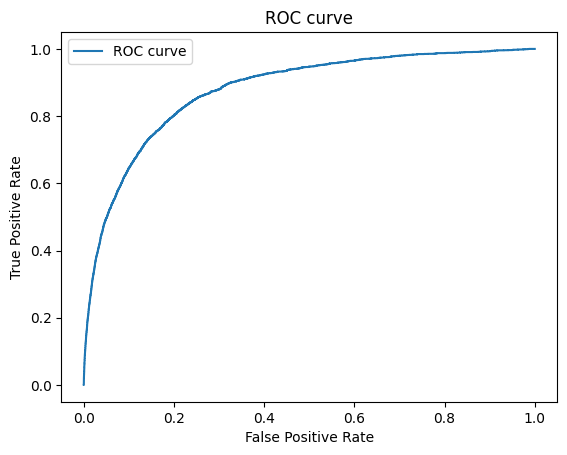

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%
CPU times: user 5.84 s, sys: 1.77 s, total: 7.61 s
Wall time: 6.82 s


In [ ]:
%%time
lr_model = LogisticRegression(
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)

predictions = lr_model.predict_proba(X_test)[:,1]
evaluate(predictions)

## 2-XGBClassifier

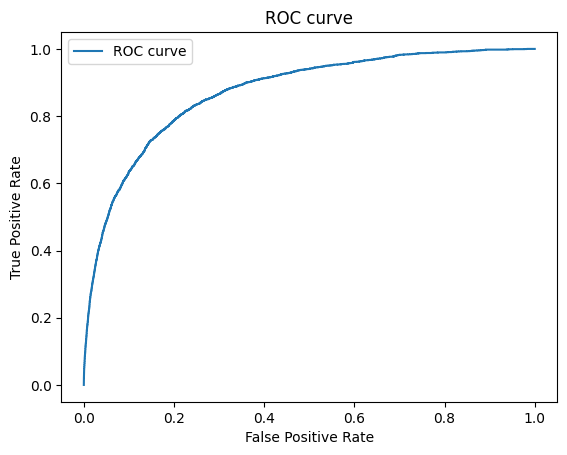

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%
CPU times: user 9.3 s, sys: 194 ms, total: 9.5 s
Wall time: 7.03 s


In [ ]:
%%time

model = xgb.XGBClassifier(
   tree_method='gpu_hist', gpu_id=0,
    scale_pos_weight=89.67005
)
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)[:,1]
evaluate(predictions)

## 3-RandomForestClassifier

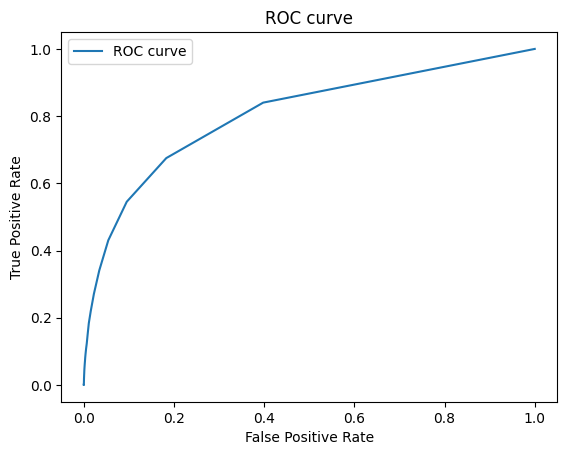

AUC: 0.8055212003111212
TPR:  34.089999999999996% 
FPR:  3.4299999999999997% 
Threshold:  0.05
Predictive Equality:  34.74%
CPU times: user 3min 53s, sys: 501 ms, total: 3min 53s
Wall time: 4min 3s


In [ ]:
%%time
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)[:,1]
evaluate(predictions)

## 4-Neural Network


## Some utility functions for keras models "Neural Network"

In [ ]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# --- Two currently unused metrics ---
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
# compile a model using these specific metrics
def compile_model(model):
    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        f1,
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-2),
        loss="binary_crossentropy",
        metrics=metrics
    )

#
def train_model(model):
    # Use EarlyStopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
        mode='max'
    )

    # Calculate the class wheights for the model, improves predictive equality
    class_weights = {0: 1., 1: np.sum(y_train == 0) / np.sum(y_train == 1)}

    hist = model.fit(
        X_train, y_train,
        class_weight=class_weights,batch_size=512,
        epochs=100, # set lower if you only want to train for short period to get approximat results
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.1 # Use 10% of training set as validation for EarlyStopping
    )
    # return the training history for possible visualization
    return hist

# Combine the compilation and training
def compile_and_train(model):
    compile_model(model)
    return train_model(model)

# Evaluate a model by passing its output into the evaluate-function
def score_keras_model(model):
    # Score the test set
    predictions = model.predict(X_test).flatten()
    evaluate(predictions)

In [ ]:
%%time
# Keras model using dropout and batch normalization
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

CPU times: user 800 ms, sys: 593 ms, total: 1.39 s
Wall time: 3.52 s


In [ ]:
hist = compile_and_train(model)

Epoch 1/100
1398/1398 [==============================] - 22s 9ms/step - loss: 1.0621 - fn: 1684.0000 - fp: 177677.0000 - tn: 529662.0000 - tp: 6467.0000 - precision: 0.0351 - recall: 0.7934 - f1: 0.0694 - val_loss: 0.5570 - val_fn: 0.0000e+00 - val_fp: 21674.0000 - val_tn: 57825.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 12s 9ms/step - loss: 1.0033 - fn: 1563.0000 - fp: 161044.0000 - tn: 546295.0000 - tp: 6588.0000 - precision: 0.0393 - recall: 0.8082 - f1: 0.0757 - val_loss: 0.6653 - val_fn: 0.0000e+00 - val_fp: 24608.0000 - val_tn: 54891.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 12s 9ms/step - loss: 0.9893 - fn: 1524.0000 - fp: 161106.0000 - tn: 546233.0000 - tp: 6627.0000 - precision: 0.0395 - recall: 0.8130 - f1: 0.0762 - val_loss: 0.7241 - val_fn: 0.0000e+

6407/6407 [==============================] - 12s 2ms/step


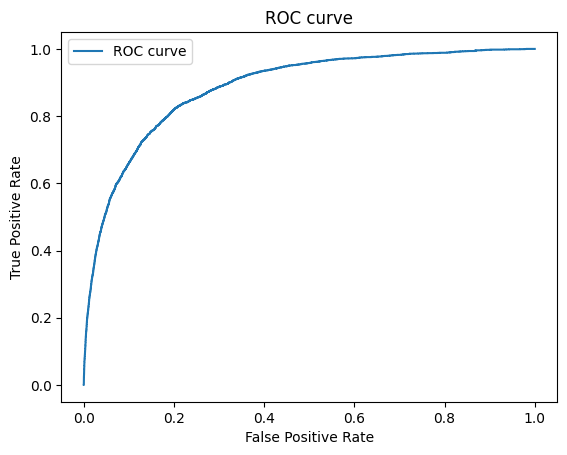

AUC: 0.8861588371621933
TPR:  51.559999999999995% 
FPR:  4.99% 
Threshold:  0.97
Predictive Equality:  81.33%


In [ ]:
score_keras_model(model)

#Our Work

##Hyperparameter tuning for the models

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import  GridSearchCV

###1-LogisticRegression

In [ ]:
# Define hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 500, 1000, 2000, 5000],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}

# Initialize model
lr = LogisticRegression()

# Initialize grid search with 5-fold cross validation
lr_grid_search = GridSearchCV(lr, param_grid=param_grid, cv=3,n_jobs = -1)

# Fit grid search on training data
lr_grid_search.fit(X_train, y_train)

# Get best parameters and corresponding score
best_params = lr_grid_search.best_params_
best_score = lr_grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


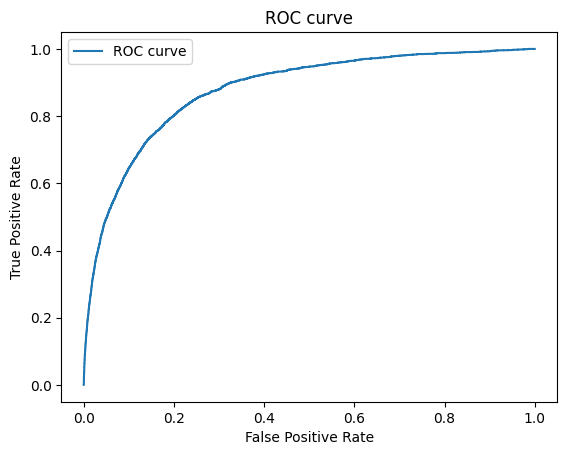

AUC: 0.8779386536129358
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%
--------------------------------------------------------

Best Hyper Parameters:  {'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.8025167189975277
Test accuracy: 0.8328284823741166
--------------------------------------------------------



In [ ]:
# Predict on the test set
y_pred=lr_grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
predictions = lr_grid_search.predict_proba(X_test)[:,1]

# Evaluate predictions and print results
evaluate(predictions)
print("--------------------------------------------------------\n")
print("Best Hyper Parameters: ", best_params)
print("Best Score: ",best_score)
print(f"Test accuracy: {accuracy}")
print("--------------------------------------------------------\n")

###2-XGBClassifier

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb = XGBClassifier()

# Define the most important hyperparameters
param_dist = {
    'tree_method': ['gpu_hist'],
    'n_estimators': [100, 200 ],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}

# Initialize RandomizedSearchCV
xgb_rand_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=3, n_jobs=-1)


# Fit grid search on training data
xgb_rand_search.fit(X_train, y_train)

# Get best parameters and corresponding score
best_params = xgb_rand_search.best_params_
best_score = xgb_rand_search.best_score_

CPU times: user 9.85 s, sys: 583 ms, total: 10.4 s
Wall time: 2min 7s


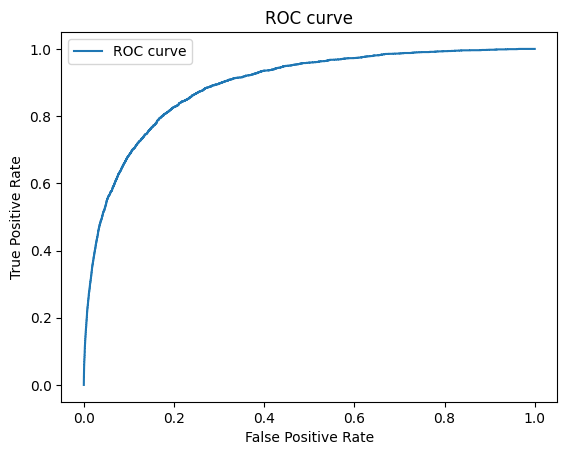

AUC: 0.8921267752731916
TPR:  54.339999999999996% 
FPR:  5.0% 
Threshold:  0.04
Predictive Equality:  28.349999999999998%
--------------------------------------------------------

Best Hyper Parameters:  {'tree_method': 'gpu_hist', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2}
Best Score:  0.9897822485752042
Test accuracy: 0.9860885513460254
--------------------------------------------------------



In [ ]:
# Predict on the test set
y_pred=xgb_rand_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
predictions = xgb_rand_search.predict_proba(X_test)[:,1]

# Evaluate predictions and print results
evaluate(predictions)
print("--------------------------------------------------------\n")
print("Best Hyper Parameters: ", best_params)
print("Best Score: ",best_score)
print(f"Test accuracy: {accuracy}")
print("--------------------------------------------------------\n")

### 3- RandomForestClassifier

In [ ]:
%%time
#Define the parameter distribution for grid Search


param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 15, 20],
    'class_weight': [None, 'balanced'],
}

# Initialize GridSearchCV
rfc = RandomForestClassifier()

rfc_grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=3,n_jobs = -1)

rfc_grid_search.fit(X_train, y_train)



# Get best parameters and corresponding score
best_params = rfc_grid_search.best_params_
best_score = rfc_grid_search.best_score_

CPU times: user 19min 40s, sys: 4.67 s, total: 19min 44s
Wall time: 58min 55s


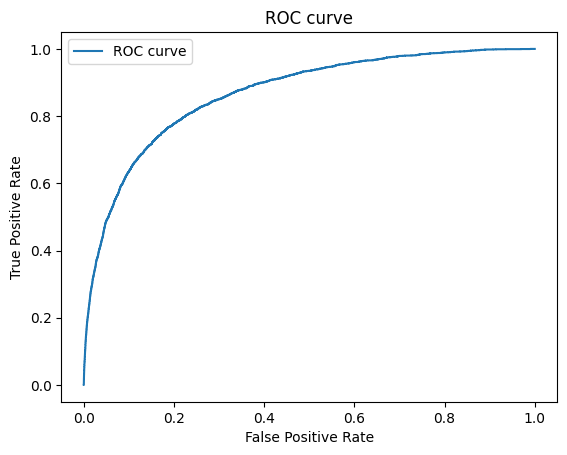

AUC: 0.8669493568946807
TPR:  48.82% 
FPR:  5.0% 
Threshold:  0.03
Predictive Equality:  26.97%
--------------------------------------------------------

Best Hyper Parameters:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 1000}
Best Score:  0.9897470279462661
Test accuracy: 0.9859617288828404
--------------------------------------------------------



In [ ]:
# Predict on the test set
y_pred=rfc_grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
predictions = rfc_grid_search.predict_proba(X_test)[:,1]

# Evaluate predictions and print results
evaluate(predictions)
print("--------------------------------------------------------\n")
print("Best Hyper Parameters: ", best_params)
print("Best Score: ",best_score)
print(f"Test accuracy: {accuracy}")
print("--------------------------------------------------------\n")

### 4- Neural Network

In [ ]:
%%time
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Define the Keras model
def create_model(optimizer='adam', activation='relu', neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Create a KerasClassifier object
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the hyperparameter search space
param_dist = {"optimizer": ['adam', 'sgd'],
              "activation": ['relu', 'tanh'],
              "neurons": [1, 5, 10]}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(estimator=model, verbose=1,param_distributions=param_dist,n_iter=10, cv=3, random_state=500)

# Fit the RandomizedSearchCV object to the data
search.fit(X_train, y_train)

# Access the best hyperparameters
best_params = search.best_params_



Fitting 3 folds for each of 10 candidates, totalling 30 fits
24844/24844 [==============================] - 82s 3ms/step - loss: 0.0565 - accuracy: 0.9876
CPU times: user 43min 38s, sys: 3min 24s, total: 47min 2s
Wall time: 50min 32s


In [ ]:
# Create the Keras model using the best hyperparameters
best_model = create_model(optimizer=best_params['optimizer'], activation=best_params['activation'], neurons=best_params['neurons'])

# Fit the Keras model to the data
best_model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
24844/24844 [==============================] - 88s 4ms/step - loss: 0.0570 - accuracy: 0.9878
Epoch 2/5
24844/24844 [==============================] - 97s 4ms/step - loss: 0.0450 - accuracy: 0.9898
Epoch 3/5
24844/24844 [==============================] - 98s 4ms/step - loss: 0.0448 - accuracy: 0.9898
Epoch 4/5
24844/24844 [==============================] - 94s 4ms/step - loss: 0.0447 - accuracy: 0.9898
Epoch 5/5
24844/24844 [==============================] - 112s 5ms/step - loss: 0.0445 - accuracy: 0.9898


6407/6407 [==============================] - 11s 2ms/step


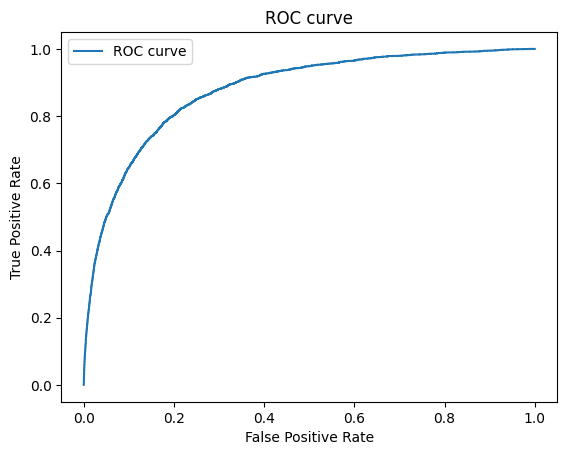

AUC: 0.8786339124096274
TPR:  50.07% 
FPR:  4.99% 
Threshold:  0.04
Predictive Equality:  32.190000000000005%
--------------------------------------------------------

Best Hyper Parameters:  {'optimizer': 'sgd', 'neurons': 10, 'activation': 'tanh'}
Best Score:  0.9897746841112772
--------------------------------------------------------



In [ ]:
# Predict on the test set

#accuracy = accuracy_score(y_test, y_pred)
best_params = search.best_params_
best_score_ = search.best_score_
# Evaluate predictions and print results
score_keras_model(best_model)
print("--------------------------------------------------------\n")
print("Best Hyper Parameters: ", best_params)
print("Best Score: ",best_score_)
#print(f"Test accuracy: {accuracy}")
print("--------------------------------------------------------\n")

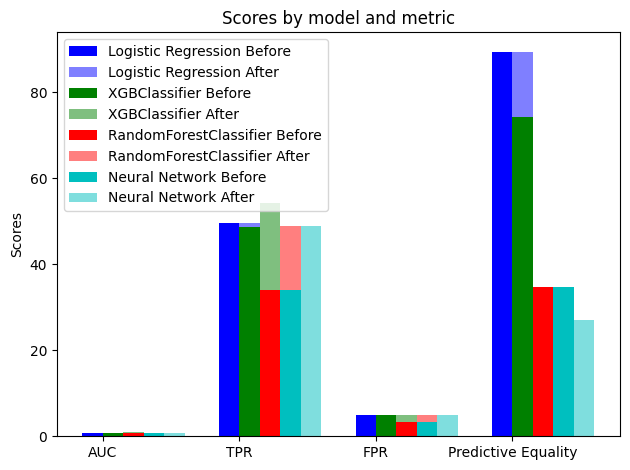

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = {
    'Logistic Regression': {
        'before': {'AUC': 0.87, 'TPR': 49.69, 'FPR': 5.0, 'Predictive Equality': 89.52},
        'after': {'AUC': 0.87, 'TPR': 49.69, 'FPR': 5.0, 'Predictive Equality': 89.52}
    },
    'XGBClassifier': {
        'before': {'AUC': 0.87, 'TPR': 48.78, 'FPR': 5.0, 'Predictive Equality': 74.38},
        'after': {'AUC': 0.89, 'TPR': 54.33, 'FPR': 5.0, 'Predictive Equality': 28.0}
    },
    'RandomForestClassifier': {
        'before': {'AUC': 0.80, 'TPR': 34.0, 'FPR': 3.4, 'Predictive Equality': 34.74},
        'after': {'AUC': 0.86, 'TPR': 48.82, 'FPR': 5.0, 'Predictive Equality': 26.97}
    },
    'Neural Network': {
        'before': {'AUC': 0.80, 'TPR': 34.0, 'FPR': 3.4, 'Predictive Equality': 34.74},
        'after': {'AUC': 0.86, 'TPR': 48.82, 'FPR': 5.0, 'Predictive Equality': 26.97}
    },
}

# Defining the metrics
metrics = ['AUC', 'TPR', 'FPR', 'Predictive Equality']

# The x position for the groups
x = np.arange(len(metrics))

# Creating subplots
fig, ax = plt.subplots()

# Bar width
bar_width = 0.15

# Defining colors for before and after
colors = ['b', 'g', 'r', 'c', 'm']

# Loop over the models
for i, (model_name, model_data) in enumerate(models.items()):
    before_metrics = [model_data['before'][metric] for metric in metrics]
    after_metrics = [model_data['after'][metric] for metric in metrics]

    ax.bar(x - bar_width/2 + i*bar_width, before_metrics, bar_width, label=f'{model_name} Before', color=colors[i])
    ax.bar(x + bar_width/2 + i*bar_width, after_metrics, bar_width, label=f'{model_name} After', color=colors[i], alpha=0.5)

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Adding a legend
fig.tight_layout()
plt.show()


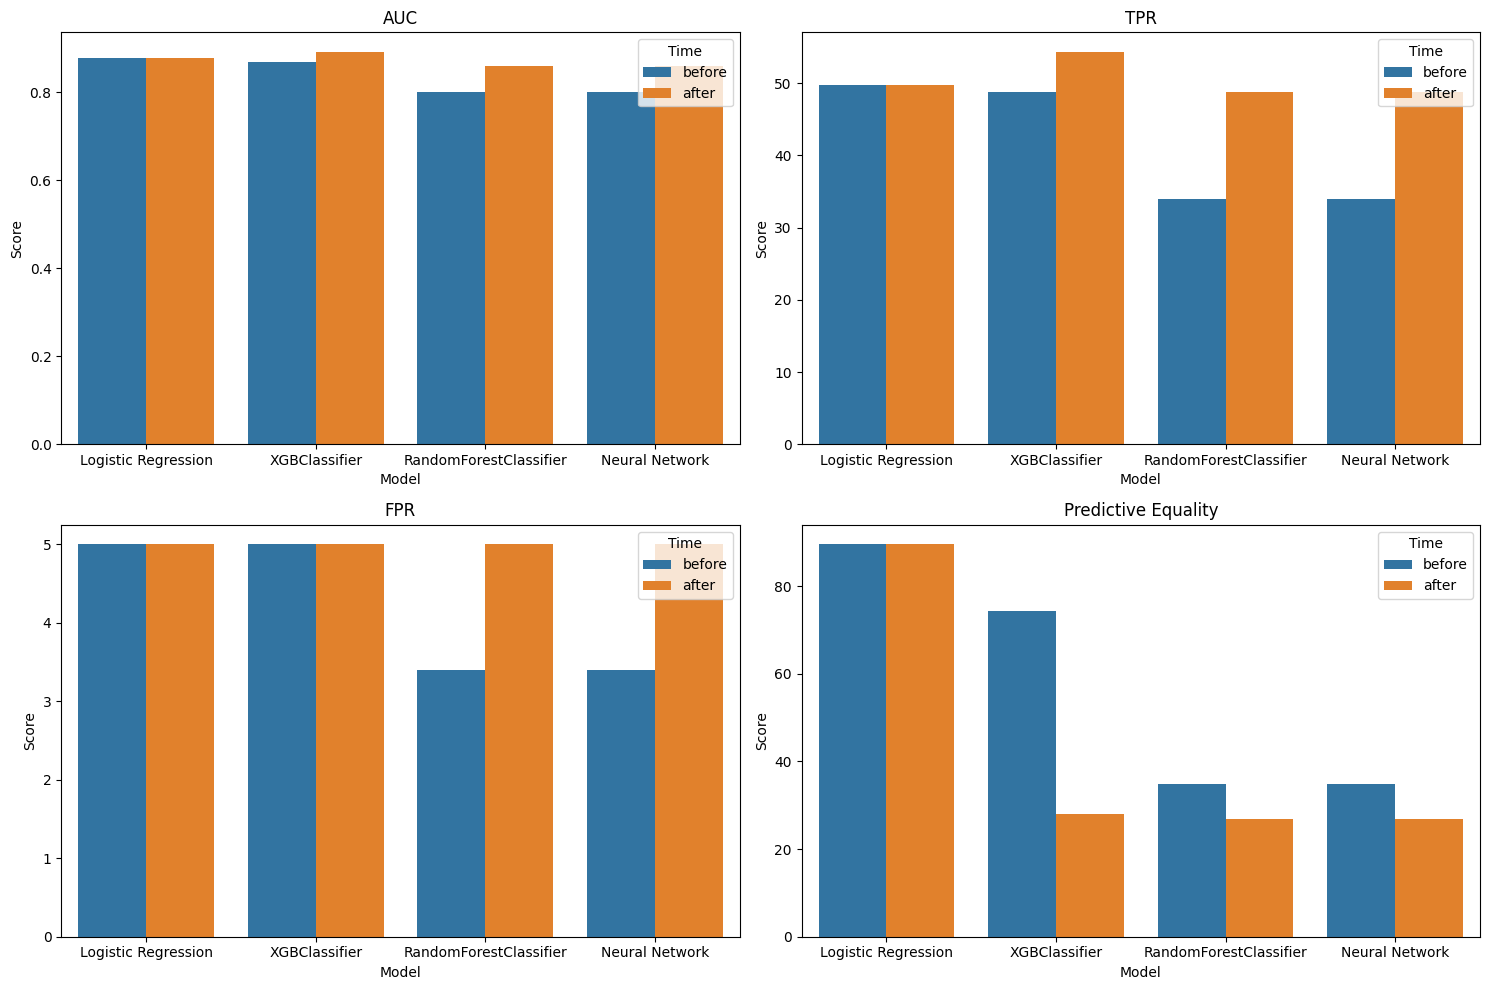

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

models = {
    'Logistic Regression': {
        'before': {'AUC': 0.87, 'TPR': 49.69, 'FPR': 5.0, 'Predictive Equality': 89.52},
        'after': {'AUC': 0.87, 'TPR': 49.69, 'FPR': 5.0, 'Predictive Equality': 89.52}
    },
    'XGBClassifier': {
        'before': {'AUC': 0.87, 'TPR': 48.78, 'FPR': 5.0, 'Predictive Equality': 74.38},
        'after': {'AUC': 0.89, 'TPR': 54.33, 'FPR': 5.0, 'Predictive Equality': 28.0}
    },
    'RandomForestClassifier': {
        'before': {'AUC': 0.80, 'TPR': 34.0, 'FPR': 3.4, 'Predictive Equality': 34.74},
        'after': {'AUC': 0.86, 'TPR': 48.82, 'FPR': 5.0, 'Predictive Equality': 26.97}
    },
    'Neural Network': {
        'before': {'AUC': 0.80, 'TPR': 34.0, 'FPR': 3.4, 'Predictive Equality': 34.74},
        'after': {'AUC': 0.86, 'TPR': 48.82, 'FPR': 5.0, 'Predictive Equality': 26.97}
    },
}

data = []
for model, model_data in models.items():
    for time, time_data in model_data.items():
        for metric, value in time_data.items():
            data.append([model, time, metric, value])

df = pd.DataFrame(data, columns=['Model', 'Time', 'Metric', 'Value'])

# Now we create individual plots for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # flatten the axis array

for ax, metric in zip(axes, metrics):
    sns.barplot(x="Model", y="Value", hue="Time", data=df[df["Metric"]==metric], ax=ax)
    ax.set_title(metric)
    ax.set_ylabel('Score')

plt.tight_layout()
plt.show()


##Helpful functions

###Model Evaluation Functions

In [ ]:
def get_fairness_metrics(
    y_true, y_pred, groups, FIXED_FPR
):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

    # Predictive equality is the differences in FPR (we use ratios in the paper)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

In [ ]:
# plot the false-positive rate of a model compared to the true-positive rate (ROC-Curves)
def plot_roc_modefied(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (modefied data)')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_modified(predictions, y_test_new ,df_groups, FIXED_FPR = 0.05):
    fprs, tprs, thresholds = roc_curve(y_test_new, predictions)
    plot_roc_modefied(fprs, tprs)
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]

    print("AUC:", roc_auc_score(y_test_new, predictions))
    to_pct = lambda x: str(round(x, 4) * 100) + "%"
    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))
    predictive_equality, disparities_df = get_fairness_metrics(y_test_new, predictions, df_groups, FIXED_FPR)
    print("Predictive Equality: ", to_pct(predictive_equality))

In [ ]:
def train_model_new(model,X_train_new,y_train_new):
    # Use EarlyStopping to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
        mode='max'
    )

    # Calculate the class wheights for the model, improves predictive equality
    class_weights = {0: 1., 1: np.sum(y_train_new == 0) / np.sum(y_train_new == 1)}

    hist = model.fit(
        X_train_new, y_train_new,
        class_weight=class_weights,batch_size=512,
        epochs=100, # set lower if you only want to train for short period to get approximat results
        callbacks=[early_stopping],
        verbose=0,
        validation_split=0.1 # Use 10% of training set as validation for EarlyStopping
    )
    # return the training history for possible visualization
    return hist

# Combine the compilation and training
def compile_and_train_new(model,X_train_new,y_train_new):
    compile_model(model)
    return train_model_new(model,X_train_new,y_train_new)

# Evaluate a model by passing its output into the evaluate-function
def score_keras_model_new(model, X_test_new,y_test_new,df_groups):
    # Score the test set
    predictions = model.predict(X_test_new).flatten()
    evaluate_modified(predictions, y_test_new ,df_groups)

In [ ]:
def model_building (X_train_new) :
  model = keras.Sequential([
      keras.layers.BatchNormalization(input_shape=[X_train_new.shape[1]]),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

###Model Comparison

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


def data_comparison (X_train_new, X_test_new, y_train_new, y_test_new, scaling_type):

  df_test = X_test_new
  labels = y_test_new
  df_groups = (df_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

#scaling
  if scaling_type=='robustscaler' :
    scaler = RobustScaler()
    X_train_new = scaler.fit_transform(X_train_new)
    X_test_new = scaler.transform(X_test_new)
  elif scaling_type=='minmaxscaler' :
    scaler = MinMaxScaler()
    X_train_new = scaler.fit_transform(X_train_new)
    X_test_new = scaler.transform(X_test_new)
  elif scaling_type=='standardscaler':
    # Scale data to improve performance on some models
    scaler = StandardScaler()
    X_train_new = scaler.fit_transform(X_train_new)
    X_test_new = scaler.transform(X_test_new)
#modeling

################### Logistic regression #############
  lr_model_new = LogisticRegression(
      class_weight='balanced'
  )
  lr_model_new.fit(X_train_new, y_train_new)
  predictions = lr_model_new.predict_proba(X_test_new)[:,1]
  print ("\n Results for Logistic regression \n")
  evaluate_modified(predictions,y_test_new = y_test_new, df_groups = df_groups)
  ## Old model
  lr_model = LogisticRegression(
      class_weight='balanced'
  )
  lr_model.fit(X_train, y_train)

  predictions = lr_model.predict_proba(X_test)[:,1]
  evaluate(predictions)

############# XGBClassifier ############

# New model
  model_xgb_new = xgb.XGBClassifier(
      tree_method='gpu_hist', gpu_id=0,
      scale_pos_weight=89.67005
  )
  model_xgb_new.fit(X_train_new, y_train_new)
  predictions = model_xgb_new.predict_proba(X_test_new)[:,1]
  print ("\n Results for XGBClassifier \n")
  evaluate_modified(predictions , y_test_new = y_test_new, df_groups = df_groups)


  ## Old model
  model_xgb = xgb.XGBClassifier(
      tree_method='gpu_hist', gpu_id=0,
      scale_pos_weight=89.67005
  )
  model_xgb.fit(X_train, y_train)

  predictions = model_xgb.predict_proba(X_test)[:,1]
  evaluate(predictions)
################ RandomForestClassifier #################
## New model
  rf_model = RandomForestClassifier(class_weight='balanced')
  rf_model.fit(X_train_new, y_train_new)
  predictions = rf_model.predict_proba(X_test_new)[:,1]
  print ("\n Results for RandomForestClassifier \n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)


  ## Old model
  rf_model = RandomForestClassifier(class_weight='balanced')
  rf_model.fit(X_train, y_train)
  predictions = rf_model.predict_proba(X_test)[:,1]

  evaluate(predictions)
#################### DecisionTree #############

#Training on the new processed data
  dt_model = DecisionTreeClassifier() # create a decision tree classifier
  dt_model.fit(X_train_new, y_train_new) # train the model on the training data
  predictions = dt_model.predict_proba(X_test_new)[:, 1] # get the probability of fraud for the test data
  print ("\n Results for DecisionTree classifier\n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)  # evaluate the model using the evaluate function

#Training on the baseline data
  dt_model = DecisionTreeClassifier() # create a decision tree classifier
  dt_model.fit(X_train, y_train) # train the model on the training data
  predictions = dt_model.predict_proba(X_test)[:,1]
  evaluate(predictions)  # evaluate the model using the evaluate function

#################### naive bayes classifier #############
#Training on the new processed data
  naive_bayes_classifier = GaussianNB()
  naive_bayes_classifier.fit(X_train_new, y_train_new)
  predictions = naive_bayes_classifier.predict(X_test_new)
  print ("\n Results for naive bayes classifier \n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)


#Training on the baseline data
  naive_bayes_classifier = GaussianNB()
  naive_bayes_classifier.fit(X_train, y_train)
  predictions = naive_bayes_classifier.predict(X_test)
  evaluate(predictions)


#################### NN model #################
  model_modefied = model_building (X_train_new)
  hist = compile_and_train_new(model_modefied,X_train_new,y_train_new)
  print ("\nmodel one finished training and model 2 started training \n")
  hist_baseline= compile_and_train(model)

  ## New model
  print ("\n Results for Neural Nework model \n")
  score_keras_model_new(model_modefied,X_test_new,y_test_new,df_groups)
  ## Old model
  score_keras_model(model)

##Applying 2 different preprocessing

##Preprocessing

###This preprocessing code performs the following:
- Certain columns containing -1 values (representing missing values) are replaced with None to handle missing data.
- Specific columns are converted to the float data type to prepare them for further processing
- Missing values in selected columns (prev_address_months_count, current_address_months_count, intended_balcon_amount, bank_months_count, session_length_in_minutes) are imputed using the mean value of each column.
- The data type of has_other_cards, foreign_request, and keep_alive_session columns is converted to boolean.
-Several columns (zip_count_4w, bank_branch_count_8w, date_of_birth_distinct_emails_4w, phone_home_valid, phone_mobile_valid, device_distinct_emails_8w) are removed from the DataFrame, because they are not relevant for the analysis.
- Categorical variables are one-hot encoded using Pandas' get_dummies function. This process converts categorical variables into binary columns, making them suitable for modeling.
- VIF is calculated to identify highly correlated features.
- Features with a VIF greater than 5 are considered highly correlated and are dropped from the DataFrame.
- The data is split into training and test sets (X_train_1_preprocessed, y_train_1_preprocessed, X_test_1_preprocessed, y_test_1_prepocessed) for model training and evaluation

In [ ]:
# Load the data into a Pandas DataFrame
processed_data_1 = pd.read_csv('/content/Base.csv')
# processed_data_1.info()
# replacing -1 one values by null as represented in the data sheet
processed_data_1['prev_address_months_count'] = processed_data_1['prev_address_months_count'].replace(-1, None)
processed_data_1['current_address_months_count'] = processed_data_1['current_address_months_count'].replace(-1, None)
processed_data_1['bank_months_count'] = processed_data_1['bank_months_count'].replace(-1, None)
processed_data_1['session_length_in_minutes'] = processed_data_1['session_length_in_minutes'].replace(-1, None)
processed_data_1['intended_balcon_amount'] = processed_data_1['intended_balcon_amount'].apply(lambda x: None if x < 0 else x)

processed_data_1['prev_address_months_count'] = processed_data_1['prev_address_months_count'].astype(float)
processed_data_1['current_address_months_count'] = processed_data_1['current_address_months_count'].astype(float)
processed_data_1['bank_months_count'] = processed_data_1['bank_months_count'].astype(float)
processed_data_1['session_length_in_minutes'] = processed_data_1['session_length_in_minutes'].astype(float)
processed_data_1['intended_balcon_amount'] = processed_data_1['intended_balcon_amount'].astype(float)

processed_data_1.info()
test_df_1 = processed_data_1[processed_data_1['month']>=6].copy()
train_df_1_preprocessed = processed_data_1[processed_data_1['month']<6].copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         287080 non-null   float64
 4   current_address_months_count      995746 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            257477 non-null   float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# Assuming you have a DataFrame named 'data' with missing values

# Create the KNNImputer object

simple_imputer = SimpleImputer(strategy='mean')  # You can adjust the number of neighbors as needed

# Specify the columns in which you want to fill missing values
columns_to_impute  = ['prev_address_months_count', 'current_address_months_count',
                   'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes']

# Fill missing values using KNNImputer for the specified columns
train_df_1_preprocessed[columns_to_impute ] = simple_imputer.fit_transform(train_df_1_preprocessed[columns_to_impute])

train_df_1_preprocessed['has_other_cards'] = train_df_1_preprocessed['has_other_cards'].astype(bool)
train_df_1_preprocessed['foreign_request'] = train_df_1_preprocessed['foreign_request'].astype(bool)
train_df_1_preprocessed['keep_alive_session'] = train_df_1_preprocessed['keep_alive_session'].astype(bool)
train_df_1_preprocessed = train_df_1_preprocessed.drop(['device_fraud_count'], axis=1, errors='ignore')
# Remove unnecessary columns
train_df_1_preprocessed.drop(['zip_count_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'phone_home_valid', 'phone_mobile_valid', 'device_distinct_emails_8w'], axis=1, inplace=True)



# One-hot encode categorical variables
cat_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'has_other_cards', 'foreign_request', 'keep_alive_session']
X_cat = pd.get_dummies(train_df_1_preprocessed[cat_cols], columns=cat_cols)
train_df_1_preprocessed = pd.concat([train_df_1_preprocessed.drop(cat_cols, axis=1), X_cat], axis=1)


# month_column = train_df_1['month']

# Remove highly correlated features
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(train_df_1_preprocessed.drop('fraud_bool', axis=1))
high_vif_cols = vif[vif['VIF'] > 5]['feature']
train_df_1_preprocessed = train_df_1_preprocessed.drop(high_vif_cols, axis=1)



from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif




test_df_1[columns_to_impute ] = simple_imputer.transform(test_df_1[columns_to_impute ])

# Identify the columns present in the test set but missing in the train set
missing_columns = set(test_df_1.columns) - set(train_df_1_preprocessed.columns)

# Drop the missing columns from the test set
test_df_1.drop(columns=missing_columns, inplace=True)

y_train_1_preprocessed = train_df_1_preprocessed['fraud_bool']
X_train_1_preprocessed = train_df_1_preprocessed.drop('fraud_bool', axis=1)

X_test_1_preprocessed = test_df_1.drop('fraud_bool', axis=1)
y_test_1_prepocessed = test_df_1['fraud_bool']

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)



 Results for Logistic regression 



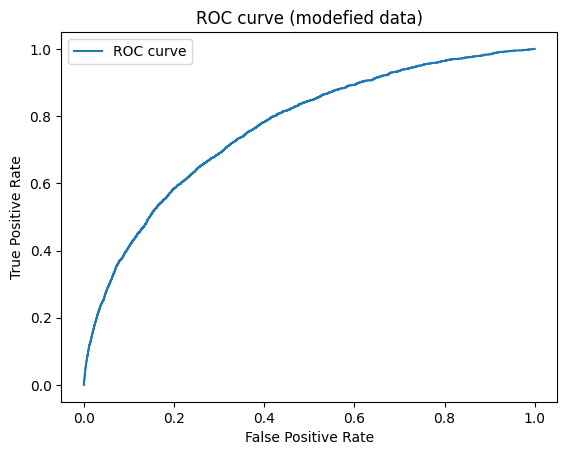

AUC: 0.7664341847703623
TPR:  27.939999999999998% 
FPR:  5.0% 
Threshold:  0.74
Predictive Equality:  99.86%


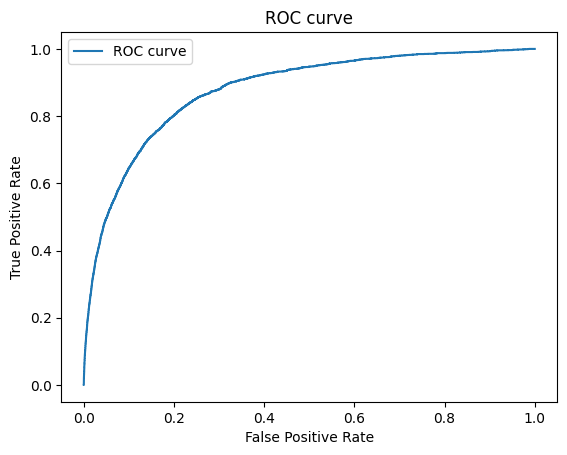

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



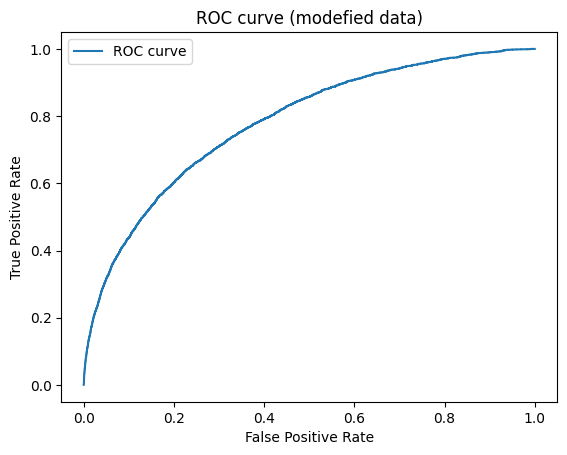

AUC: 0.7808113062100963
TPR:  31.65% 
FPR:  4.99% 
Threshold:  0.74
Predictive Equality:  83.36%


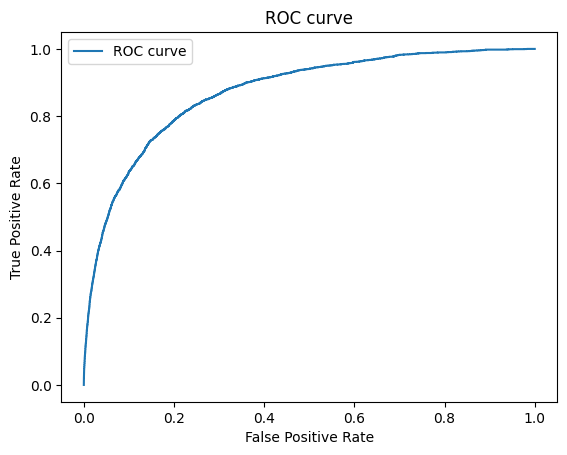

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



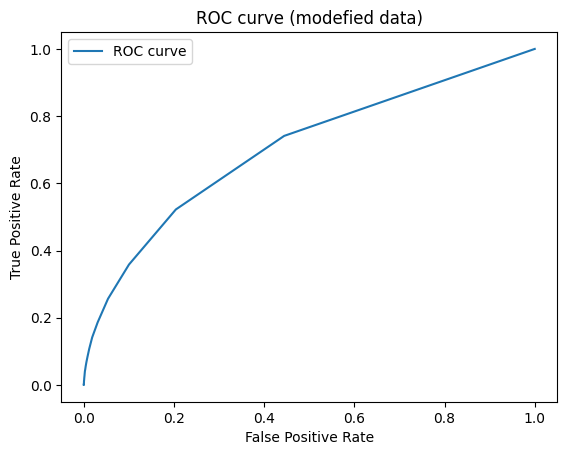

AUC: 0.7042331701273191
TPR:  18.62% 
FPR:  3.0700000000000003% 
Threshold:  0.05
Predictive Equality:  32.95%


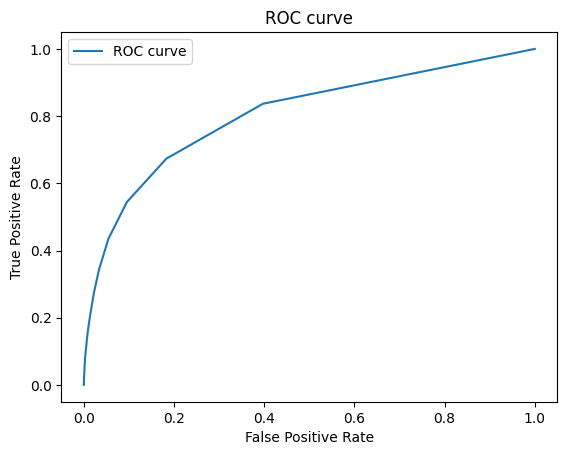

AUC: 0.8040941345264361
TPR:  34.29% 
FPR:  3.36% 
Threshold:  0.05
Predictive Equality:  35.55%

 Results for DecisionTree classifier



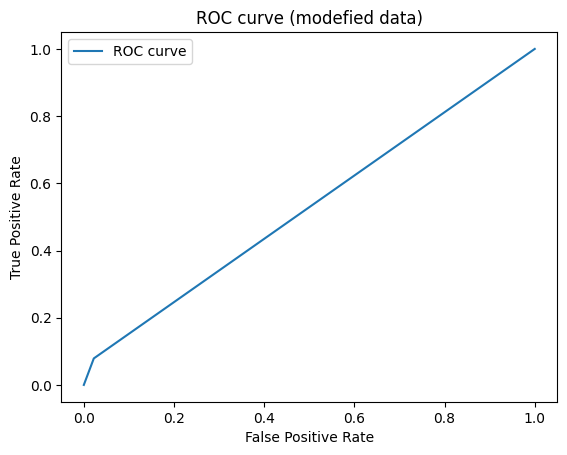

AUC: 0.5283726119655212
TPR:  7.89% 
FPR:  2.21% 
Threshold:  1.0
Predictive Equality:  35.089999999999996%


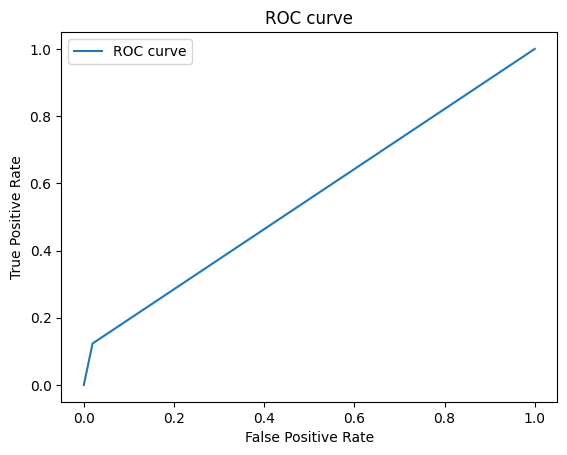

AUC: 0.5519534520489088
TPR:  12.33% 
FPR:  1.94% 
Threshold:  1.0
Predictive Equality:  42.75%

 Results for naive bayes classifier 



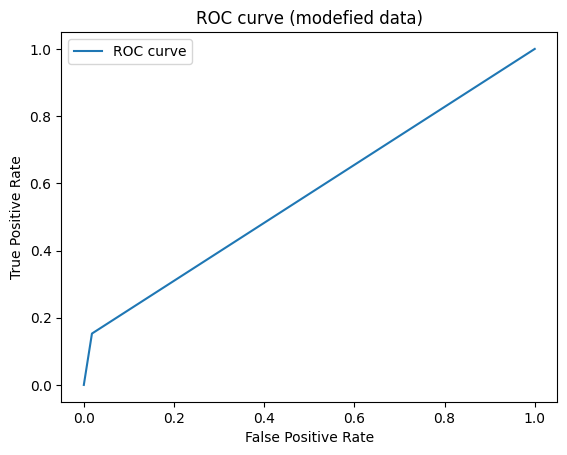

AUC: 0.5674256328666173
TPR:  15.290000000000001% 
FPR:  1.7999999999999998% 
Threshold:  1
Predictive Equality:  18.85%


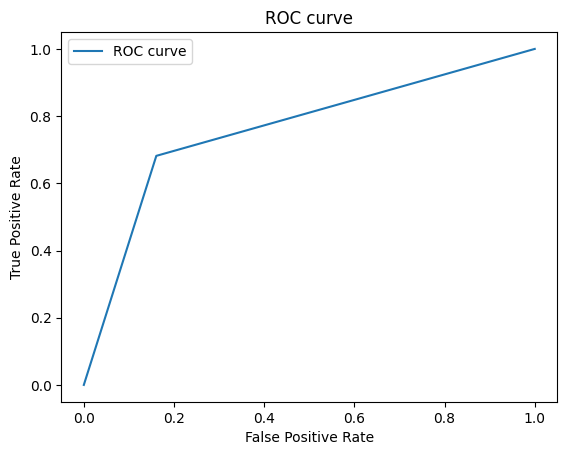

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 19s 10ms/step - loss: 1.0692 - fn: 1658.0000 - fp: 184697.0000 - tn: 522642.0000 - tp: 6493.0000 - precision: 0.0340 - recall: 0.7966 - f1: 0.0678 - val_loss: 0.3890 - val_fn: 0.0000e+00 - val_fp: 12348.0000 - val_tn: 67151.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 14s 10ms/step - loss: 0.9994 - fn: 1640.0000 - fp: 150501.0000 - tn: 556838.0000 - tp: 6511.0000 - precision: 0.0415 - recall: 0.7988 - f1: 0.0798 - val_loss: 0.5697 - val_fn: 0.0000e+00 - val_fp: 18681.0000 - val_tn: 60818.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 14s 10ms/step - l

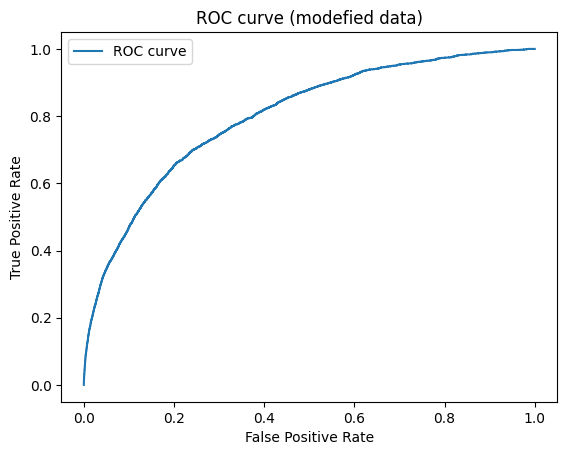

AUC: 0.8003111367302465
TPR:  34.47% 
FPR:  4.9799999999999995% 
Threshold:  0.93
Predictive Equality:  99.98%
6407/6407 [==============================] - 13s 2ms/step


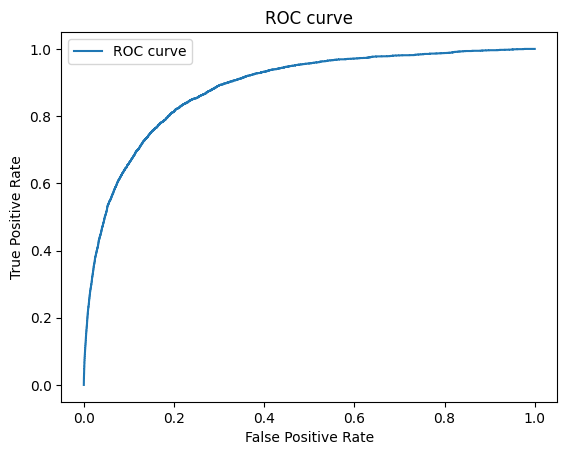

AUC: 0.8848774793890566
TPR:  51.49% 
FPR:  4.99% 
Threshold:  0.82
Predictive Equality:  96.38%


In [ ]:
data_comparison(X_train_1_preprocessed, X_test_1_preprocessed, y_train_1_preprocessed, y_test_1_prepocessed, 'standardscaler')

##Apply other preprocessing

###Data Exploration

In [ ]:
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from collections import Counter

In [ ]:
# Load Base.csv
processed_data_2 = pd.read_csv('/content/Base.csv')
processed_data_2.head(5)

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -1.331345           AA           769  ...                0   
1               -0.816224           AB           366  ...                0   
2               -0.755728           AC           870  ...                0   
3               -1.205124           AB           810  ...                1   
4               -0.773276           AB           890  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                 1500.0                0  INTERNET   

   session_length_in_minutes  device_os  keep_alive_session  \
0                   3.888115    windows                   0   
1                  31.798819    windows                   0   
2                   4.728705      other                   0   
3                   2.047904      linux                   0   
4                   3.775225  macintosh                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      7  
1                          1                  0      7  
2                          1                  0      7  
3                          1                  0      7  
4                          1                  0      7  

[5 rows x 32 columns]

In [ ]:
processed_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

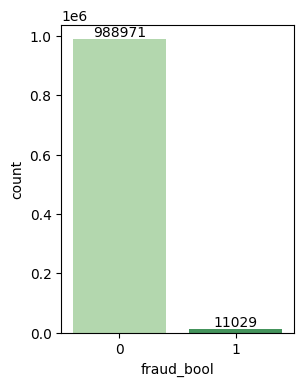

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud_bool',data=processed_data_2, palette="Greens")
for i in ax.containers:
    ax.bar_label(i,)

####**Check -(Ve)**

In [ ]:
# show some negative values in installments
processed_data_2[processed_data_2["prev_address_months_count"] < 0]["prev_address_months_count"]
# processed_data_2[processed_data_2["current_address_months_count"] < 0]["current_address_months_count"]
# processed_data_2[processed_data_2["intended_balcon_amount"] < 0]["intended_balcon_amount"]
# processed_data_2[processed_data_2["velocity_6h"] < 0]["velocity_6h"]
# processed_data_2[processed_data_2["credit_risk_score"] < 0]["credit_risk_score"]
# processed_data_2[processed_data_2["bank_months_count"] < 0]["bank_months_count"]

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
999994   -1
999995   -1
999997   -1
999998   -1
999999   -1
Name: prev_address_months_count, Length: 712920, dtype: int64

In [ ]:
# Replace all -ve values in multiple columns with NaN
columns_to_replace = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count']  # Add all the feature column names here
processed_data_2[columns_to_replace] = processed_data_2[columns_to_replace].applymap(lambda x: np.nan if x < 0 else x)

# Check if any NaN values exist in the specified columns
print(processed_data_2[columns_to_replace].isna().sum())

prev_address_months_count       712920
current_address_months_count      4254
intended_balcon_amount          742523
bank_months_count               253635
dtype: int64


In [ ]:
# checking the nulls
processed_data_2.isnull().sum().sort_values(ascending=False)

intended_balcon_amount              742523
prev_address_months_count           712920
bank_months_count                   253635
current_address_months_count          4254
fraud_bool                               0
source                                   0
phone_mobile_valid                       0
has_other_cards                          0
proposed_credit_limit                    0
foreign_request                          0
device_os                                0
session_length_in_minutes                0
housing_status                           0
keep_alive_session                       0
device_distinct_emails_8w                0
device_fraud_count                       0
phone_home_valid                         0
credit_risk_score                        0
email_is_free                            0
income                                   0
employment_status                        0
date_of_birth_distinct_emails_4w         0
bank_branch_count_8w                     0
velocity_4w

In [ ]:
# Create a list of column names with missing values to fill
columns_to_fill = ["prev_address_months_count", "current_address_months_count", "intended_balcon_amount", "bank_months_count"]

# Fill missing values in the specified columns with their respective means
for column in columns_to_fill:
    processed_data_2[column] = processed_data_2[column].fillna(processed_data_2[column].mean())

In [ ]:
# check the null values again to make sure they are all handled
processed_data_2.isnull().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

####**Check outliers**

In [ ]:
# check the numerical columns
numeric_columns = processed_data_2.select_dtypes(exclude=['object']).columns

# Check the outliers in each numerical column
outlier_counts = pd.Series({col: ((processed_data_2[col] < processed_data_2[col].quantile(0.25) - 1.5*(processed_data_2[col].quantile(0.75) - processed_data_2[col].quantile(0.25))) | (processed_data_2[col] > processed_data_2[col].quantile(0.75) + 1.5*(processed_data_2[col].quantile(0.75) - processed_data_2[col].quantile(0.25)))).sum() for col in processed_data_2.select_dtypes(include=['float64']).columns})

# Sort the outlier counts in descending order
outlier_counts = outlier_counts.sort_values(ascending=False)

# Print features with the most outliers
print('Features with the most outliers:')
print(outlier_counts.head())

Features with the most outliers:
prev_address_months_count    287080
intended_balcon_amount       257477
proposed_credit_limit        241742
days_since_request            94834
session_length_in_minutes     78789
dtype: int64


In [ ]:
def IQR_method (processed_data_2,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(processed_data_2[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(processed_data_2[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = processed_data_2[(processed_data_2[column] < Q1 - outlier_step) | (processed_data_2[column] > Q3 + outlier_step )].index
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = processed_data_2[processed_data_2[column] < Q1 - outlier_step]
    out2 = processed_data_2[processed_data_2[column] > Q3 + outlier_step]

    # print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

# detecting outliers
Outliers_IQR = IQR_method(processed_data_2,1,numeric_columns)

# dropping outliers
processed_data_2 = processed_data_2.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

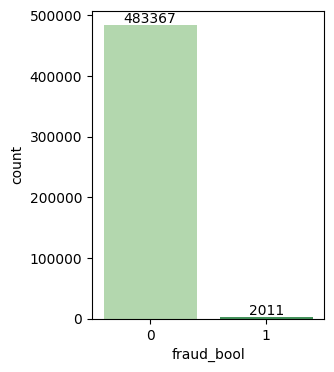

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud_bool',data=processed_data_2, palette="Greens")
for i in ax.containers:
    ax.bar_label(i,)

####**Check correlation**


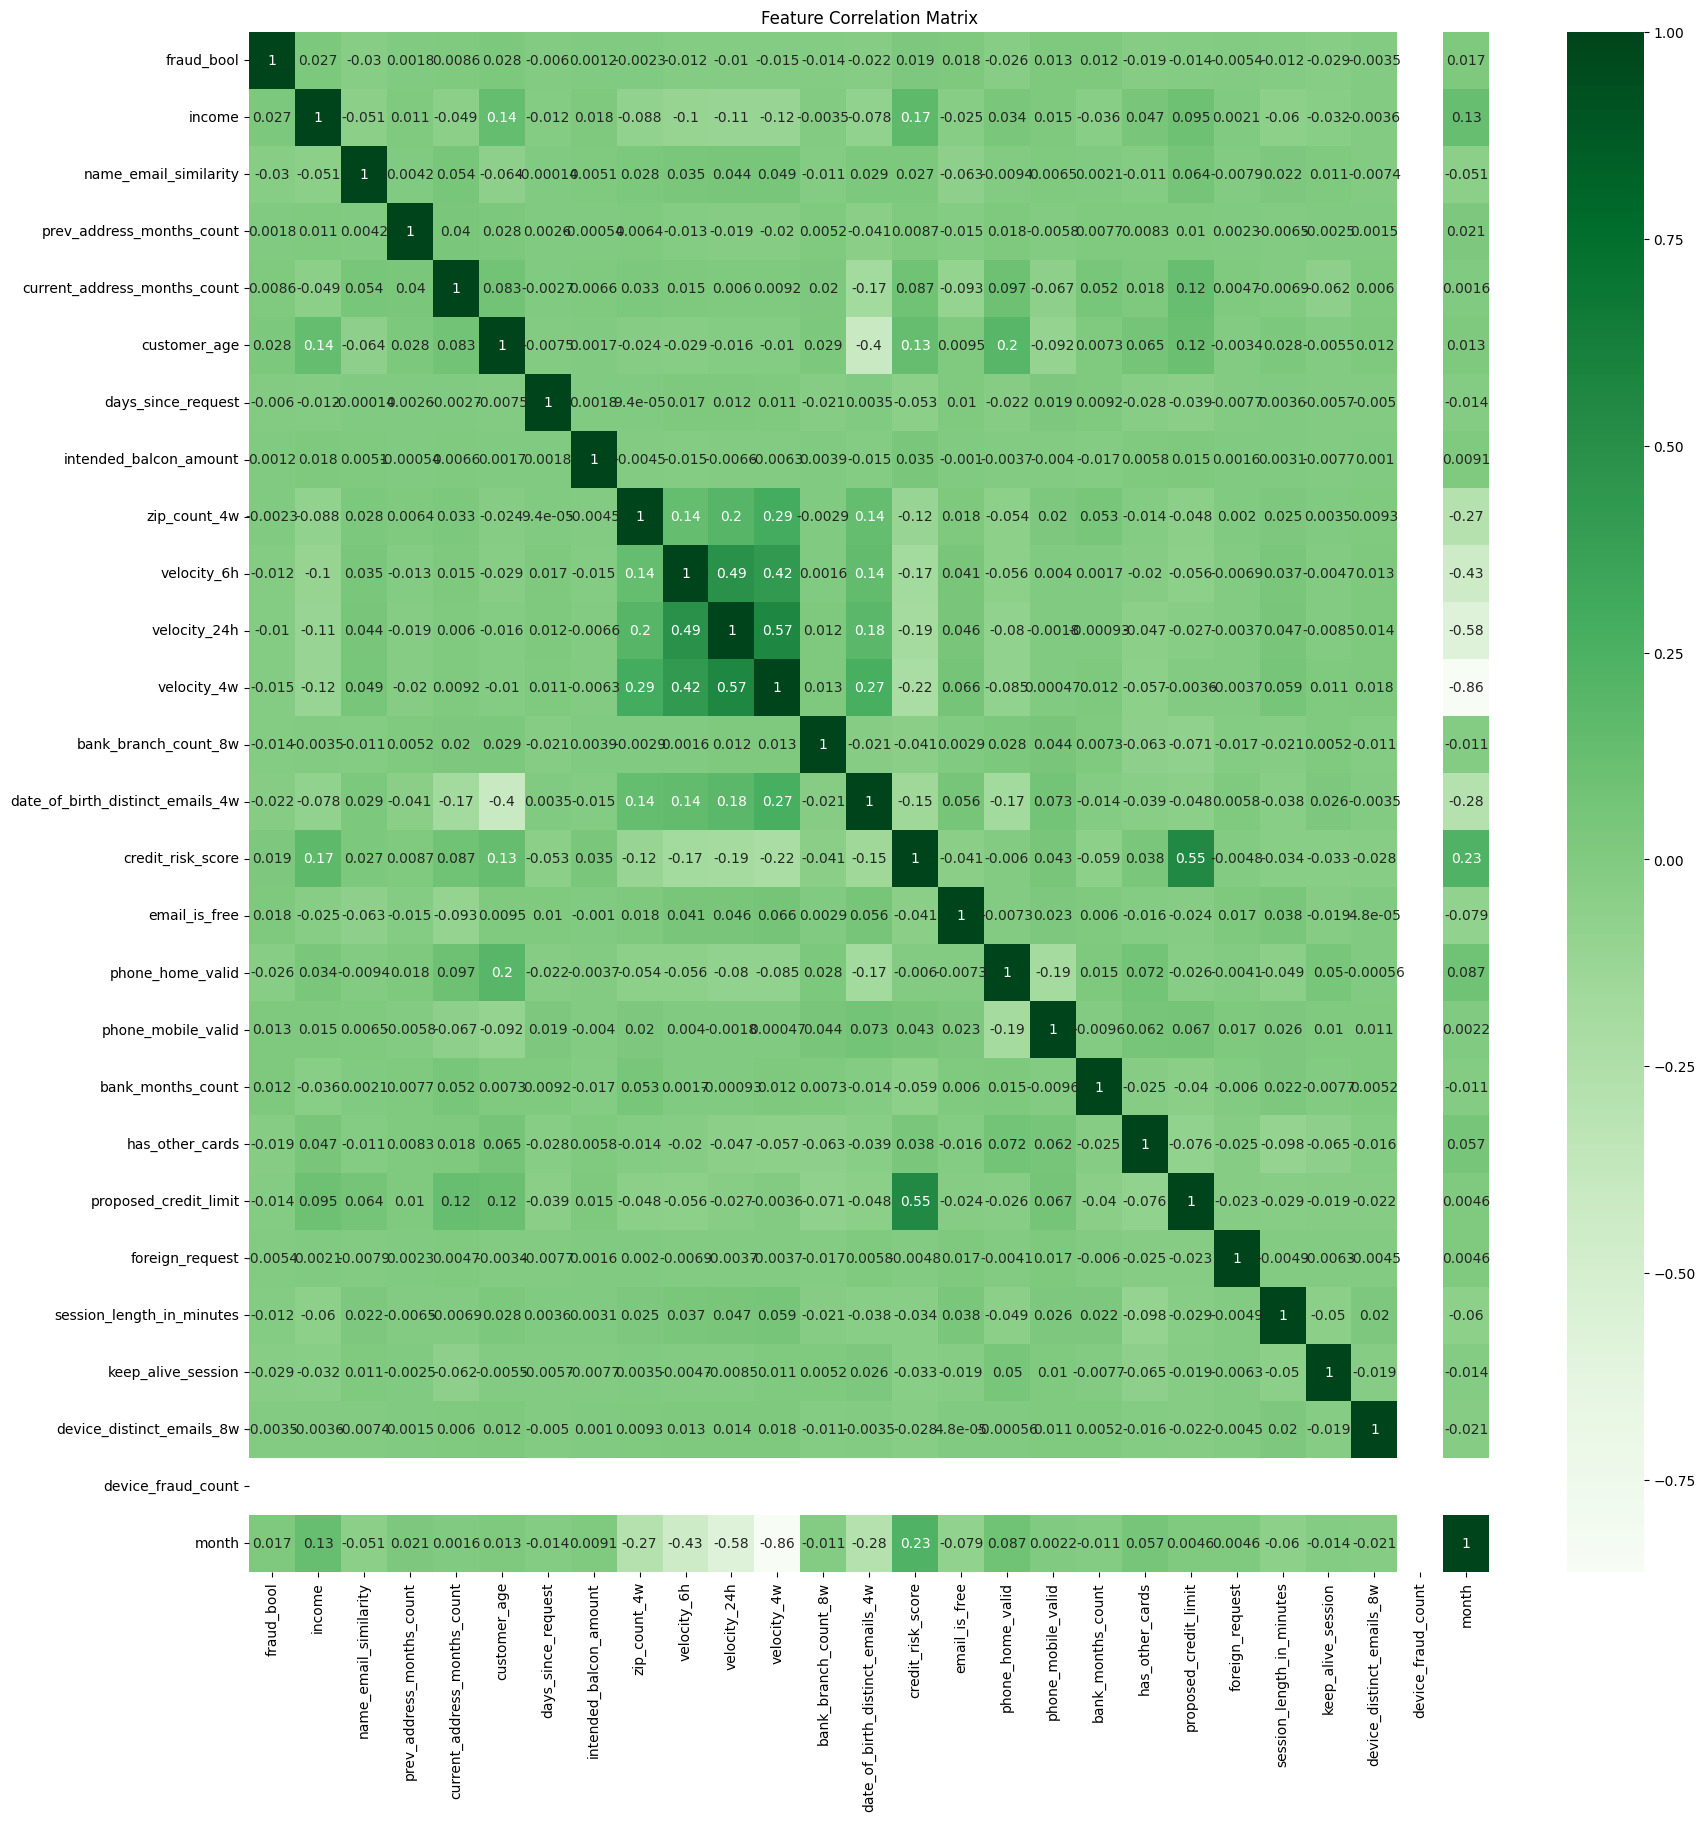

In [ ]:
# getting the correlation between the features
import seaborn as sns
corr = processed_data_2.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='Greens')
plt.title('Feature Correlation Matrix')
plt.show()

### **Drop unnecessary columns**

In [ ]:
# Remove "device_fraud_count", it's 0 for all entries
print(processed_data_2['device_fraud_count'].value_counts()) # It's 0 for all rows
processed_data_2 = processed_data_2.drop(['device_fraud_count'], axis=1, errors='ignore')

#remove high correlated features
processed_data_2.drop(columns = ['proposed_credit_limit','velocity_24h'], axis=1, inplace=True)

0    485378
Name: device_fraud_count, dtype: int64


### **Split Data**

In [ ]:
# Split data into features and target
X = processed_data_2.drop(['fraud_bool'], axis=1)
y = processed_data_2['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train_2_preprocessed = X[X['month']<6].copy()
X_test_2_preprocessed = X[X['month']>=6].copy()
y_train_2_preprocessed = y[X['month']<6].copy()
y_test_2_preprocessed = y[X['month']>=6].copy()

X_train_2_preprocessed.drop('month', axis=1, inplace=True)
X_test_2_preprocessed.drop('month', axis=1, inplace=True)

In [ ]:
s = (X_train_2_preprocessed.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source device_os
0                AD                CA             BB  INTERNET   windows
1                AD                CA             BC  INTERNET   windows
2                AB                CA             BA  INTERNET   windows
3                AD                CA             BA  INTERNET   windows
4                AD                CD             BC  INTERNET   windows
...             ...               ...            ...       ...       ...
485373           AB                CA             BE  INTERNET     linux
485374           AB                CF             BB  INTERNET   windows
485375           AB                CF             BC  INTERNET     other
485376           AD                CE             BE  INTERNET     other
485377           AB                CA             BC  INTERNET     linux

[485378 rows x 5 columns]


###**Encode categorical features using TargetEncoder**

In [ ]:
!pip install category_encoders
import category_encoders as ce
from category_encoders import TargetEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Combine X_train and y_train for target encoding
train_data = X_train_2_preprocessed.copy()
train_data['fraud_bool'] = y_train_2_preprocessed

# List of categorical columns
categorical_columns = list(train_data.select_dtypes(include='object').columns)

# Initialize the target encoder
target_encoder = ce.TargetEncoder(cols=categorical_columns)

# Fit and transform the target encoder on the training data
X_train_encoded = target_encoder.fit_transform(train_data[categorical_columns], train_data['fraud_bool'])

# Update the encoded values in the original X_train data
X_train_2_preprocessed[categorical_columns] = X_train_encoded

# Now, apply the target encoding to the test data using the previously fitted encoder
X_test_encoded = target_encoder.transform(X_test_2_preprocessed[categorical_columns])

# Update the encoded values in the original X_test data
X_test_2_preprocessed[categorical_columns] = X_test_encoded

In [ ]:
X_train_2_preprocessed.head(2)

income  name_email_similarity  prev_address_months_count  \
57880     0.8               0.153411                  60.719967   
57881     0.9               0.064424                  60.719967   

       current_address_months_count  customer_age  days_since_request  \
57880                         105.0            30            0.003467   
57881                         275.0            50            0.013670   

       intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
57880               36.582496      0.005091          1779  1147.615990  ...   
57881               36.582496      0.003349           530  3674.359522  ...   

       phone_home_valid  phone_mobile_valid  bank_months_count  \
57880                 0                   1          14.862618   
57881                 1                   1          31.000000   

       has_other_cards  foreign_request    source  session_length_in_minutes  \
57880                0                0  0.003584                   3.911696   
57881                0                0  0.003584                   1.582359   

       device_os  keep_alive_session  device_distinct_emails_8w  
57880   0.001977                   0                          1  
57881   0.005406                   1                          1  

[2 rows x 27 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Results for Logistic regression 



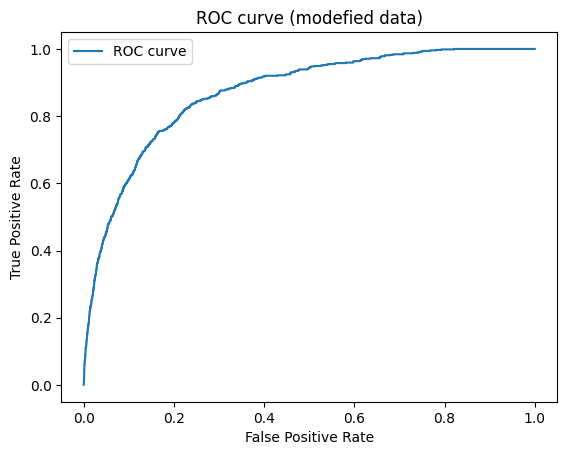

AUC: 0.87116827623914
TPR:  45.49% 
FPR:  4.97% 
Threshold:  0.83
Predictive Equality:  90.4%


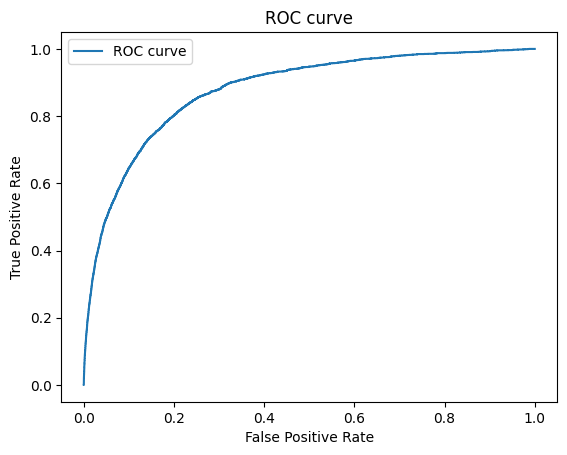

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



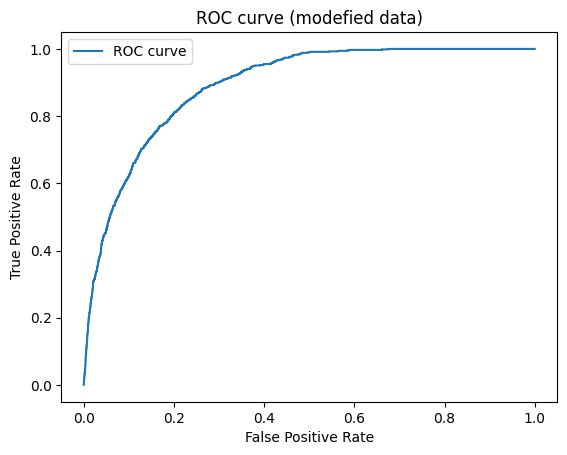

AUC: 0.8912278892252838
TPR:  46.22% 
FPR:  5.0% 
Threshold:  0.36
Predictive Equality:  85.66%


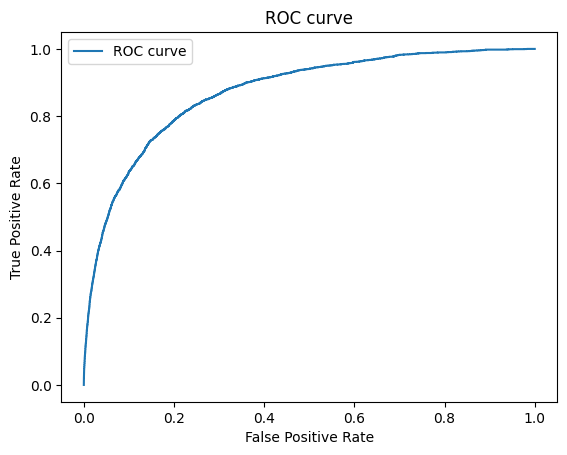

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



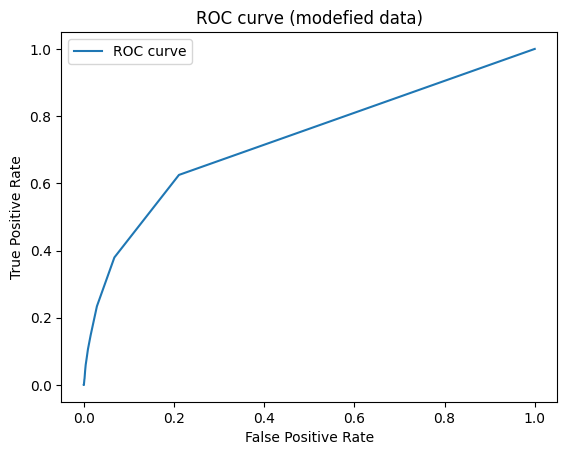

AUC: 0.7288383880633337
TPR:  23.400000000000002% 
FPR:  2.9000000000000004% 
Threshold:  0.03
Predictive Equality:  50.370000000000005%


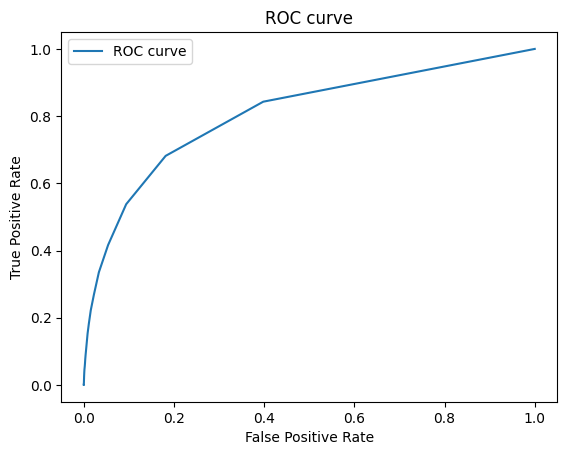

AUC: 0.8071048140243098
TPR:  33.53% 
FPR:  3.34% 
Threshold:  0.05
Predictive Equality:  32.629999999999995%

 Results for DecisionTree classifier



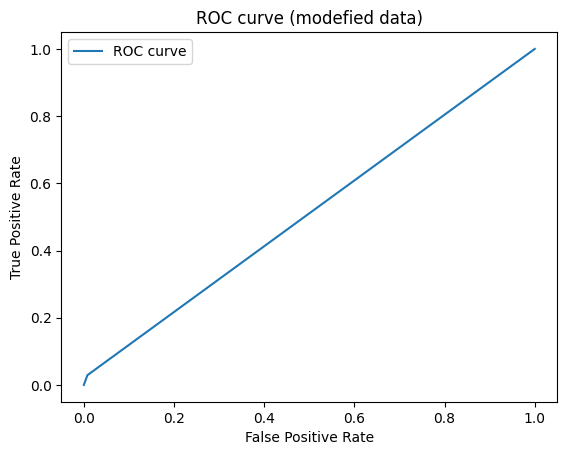

AUC: 0.510524694742926
TPR:  2.91% 
FPR:  0.8% 
Threshold:  1.0
Predictive Equality:  37.68%


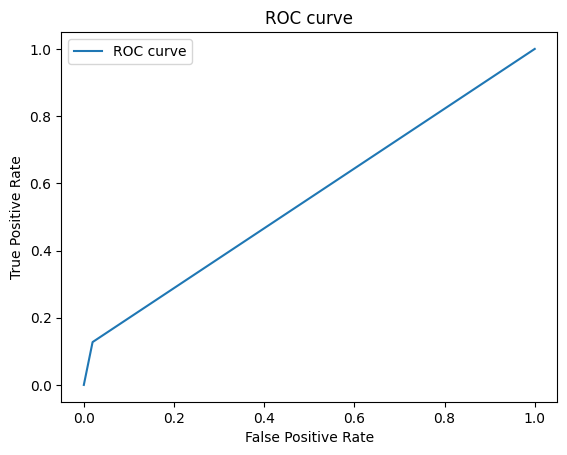

AUC: 0.5540357595280385
TPR:  12.75% 
FPR:  1.94% 
Threshold:  1.0
Predictive Equality:  43.19%

 Results for naive bayes classifier 



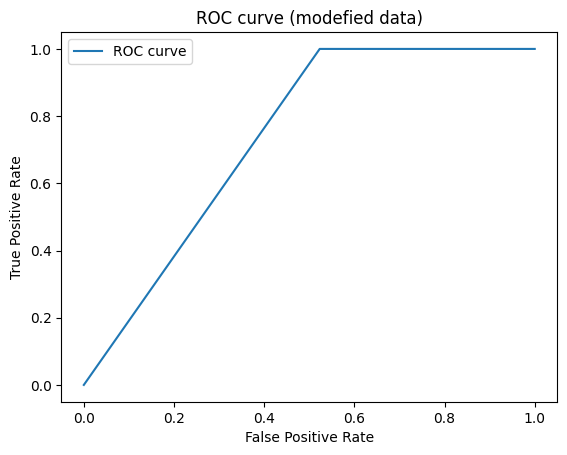

AUC: 0.7384513441878077
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  97.43%


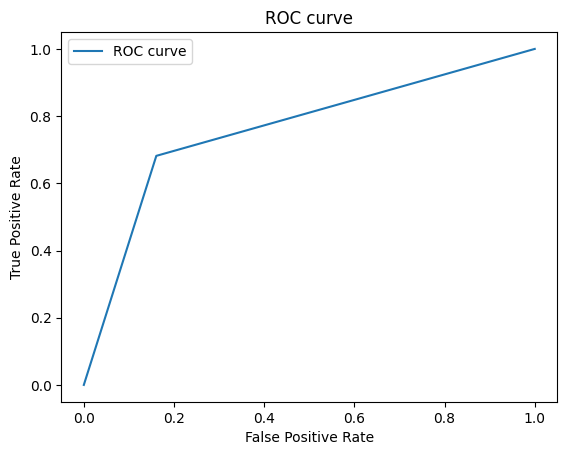

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%


In [ ]:
data_comparison (X_train_2_preprocessed, X_test_2_preprocessed, y_train_2_preprocessed, y_test_2_preprocessed, scaling_type='robustscaler')

## SMOTE

In [ ]:
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from collections import Counter

In [ ]:
# load data
df_smote = pd.read_csv('/content/Base.csv')
df_smote.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -1.331345           AA           769  ...                0   
1               -0.816224           AB           366  ...                0   
2               -0.755728           AC           870  ...                0   
3               -1.205124           AB           810  ...                1   
4               -0.773276           AB           890  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                 1500.0                0  INTERNET   

   session_length_in_minutes  device_os  keep_alive_session  \
0                   3.888115    windows                   0   
1                  31.798819    windows                   0   
2                   4.728705      other                   0   
3                   2.047904      linux                   0   
4                   3.775225  macintosh                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      7  
1                          1                  0      7  
2                          1                  0      7  
3                          1                  0      7  
4                          1                  0      7  

[5 rows x 32 columns]

In [ ]:
# Remove "device_fraud_count", it's 0 for all entries
print(df_smote['device_fraud_count'].value_counts()) # It's 0 for all rows
df_smote = df_smote.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:
labels=["Genuine","Fraud"]

fraud_or_not = df_smote["fraud_bool"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df_smote['fraud_bool'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

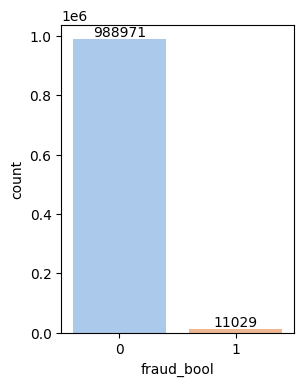

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud_bool',data=df_smote,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
# Split data into features and target
X = df_smote.drop(['fraud_bool'], axis=1)
y = df_smote['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train_smote = X[X['month']<6].copy()
X_test_smote = X[X['month']>=6].copy()
y_train_smote = y[X['month']<6].copy()
y_test_smote = y[X['month']>=6].copy()

X_train_smote.drop('month', axis=1, inplace=True)
X_test_smote.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
s = (X_train_smote.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [ ]:
# One-hot encode categorical variables
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train_smote[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test_smote[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train_smote.index
ohe_cols_test.index = X_test_smote.index

# Remove the object columns from the training and test data
num_X_train = X_train_smote.drop(object_cols, axis=1)
num_X_test = X_test_smote.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train_smote = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test_smote = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train_smote.columns = X_train_smote.columns.astype(str)
X_test_smote.columns = X_test_smote.columns.astype(str)

# See that it replaced all categorical values
X_train_smote.head(2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   
96844     0.8               0.442439                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   
96844                           107            40            0.021131   

       intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...  \
96843               -0.906840          1779   1147.61599   3076.384487  ...   
96844               -1.553115          1195  10788.64257   5790.128646  ...   

        16   17   18   19   20   21   22   23   24   25  
96843  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  
96844  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  

[2 rows x 50 columns]

Applying SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Specify the desired ratio, e.g., 0.7 means 70% of the majority class size
desired_ratio = 0.7

# Calculate the number of instances in the majority class
majority_class_count = y_train_smote.value_counts().max()

# Calculate the number of instances needed for the minority class to achieve the desired ratio
minority_class_count = int(desired_ratio * majority_class_count)

# Create the SMOTE object with the desired ratio
smote = SMOTE(sampling_strategy={1: minority_class_count}, random_state=42)

# Apply SMOTE to balance the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [ ]:
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to balance the classes
# smote = SMOTE(random_state=42)

# X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [ ]:
print('Genuine:', y_train_smote.value_counts()[0], '/', round(y_train_smote.value_counts()[0]/len(y_train_smote) * 100,2), '% of the dataset')
print('Frauds:', y_train_smote.value_counts()[1], '/',round(y_train_smote.value_counts()[1]/len(y_train_smote) * 100,2), '% of the dataset')

Genuine: 786838 / 58.82 % of the dataset
Frauds: 550786 / 41.18 % of the dataset


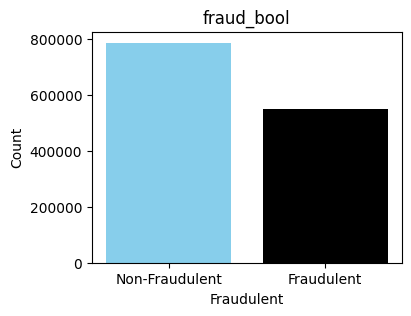

In [ ]:
# Calculate the value counts
value_counts = y_train_smote.value_counts()

# Set the figure size (width, height) in inches
plt.figure(figsize=(4, 3))

# Plotting the data as a bar plot
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'black'])

# Customizing the plot
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('fraud_bool')
plt.xticks(value_counts.index, ['Non-Fraudulent', 'Fraudulent'])  # Using custom x-axis labels

# Display the plot
plt.show()

In [ ]:
print("length of train data ",len(y_train_smote))
print("length of test data ",len(y_test_smote))

length of train data  1337624
length of test data  205011



 Results for Logistic regression 



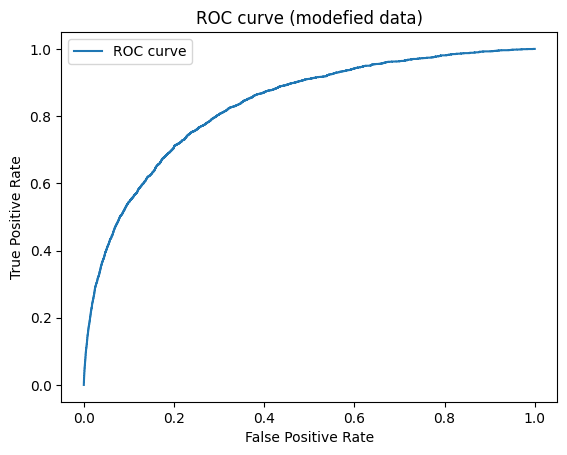

AUC: 0.8328613076081465
TPR:  40.17% 
FPR:  5.0% 
Threshold:  0.74
Predictive Equality:  81.26%


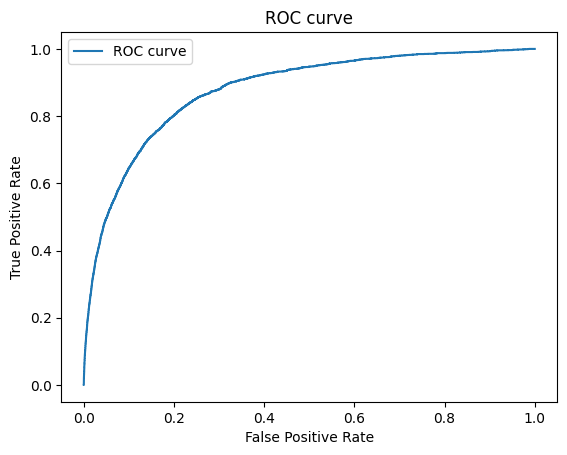

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



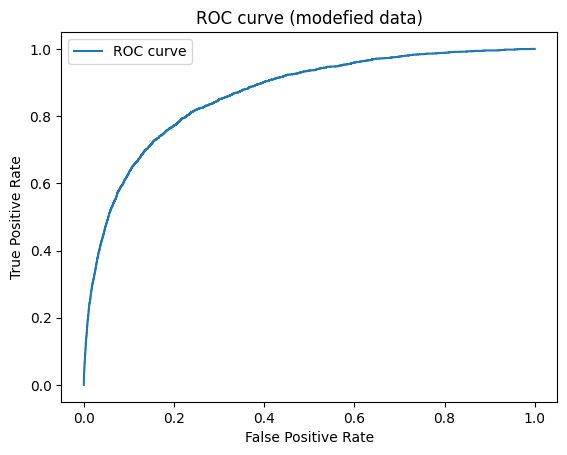

AUC: 0.8654695526621369
TPR:  47.949999999999996% 
FPR:  4.97% 
Threshold:  0.81
Predictive Equality:  76.38000000000001%


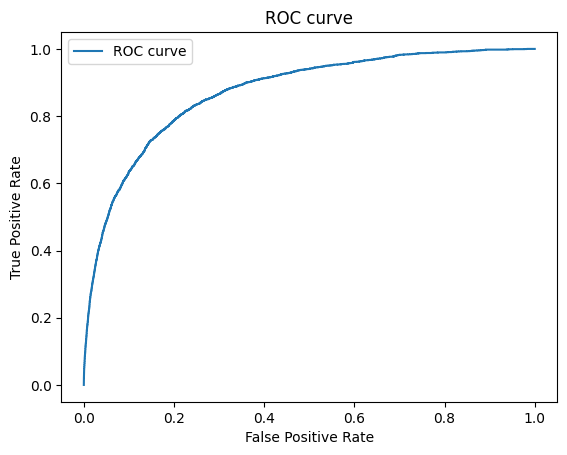

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



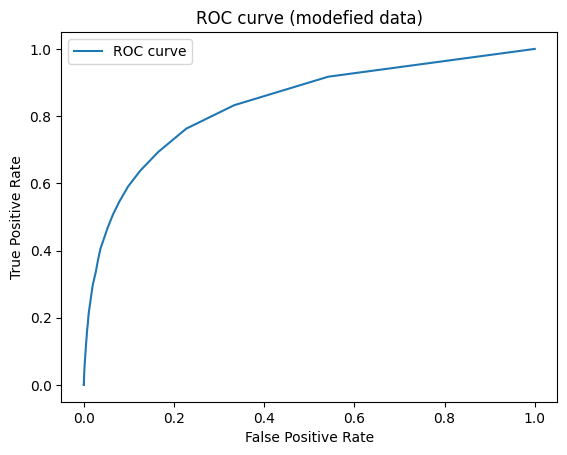

AUC: 0.8354311131064474
TPR:  43.26% 
FPR:  4.390000000000001% 
Threshold:  0.1
Predictive Equality:  44.18%


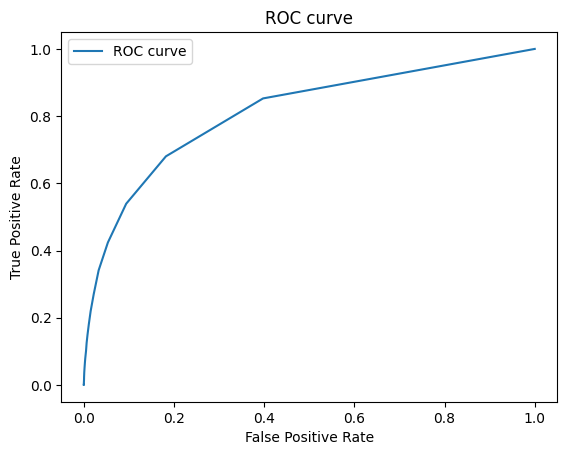

AUC: 0.8113873590622998
TPR:  34.12% 
FPR:  3.29% 
Threshold:  0.05
Predictive Equality:  34.28%

 Results for DecisionTree classifier



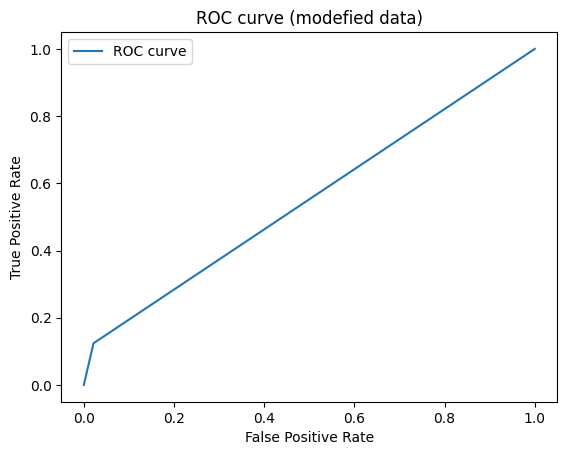

AUC: 0.5512669428838863
TPR:  12.4% 
FPR:  2.15% 
Threshold:  1.0
Predictive Equality:  40.089999999999996%


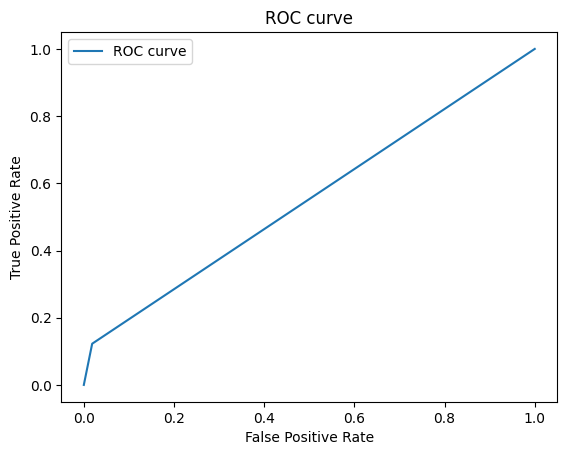

AUC: 0.5520685552584467
TPR:  12.27% 
FPR:  1.8499999999999999% 
Threshold:  1.0
Predictive Equality:  40.93%

 Results for naive bayes classifier 



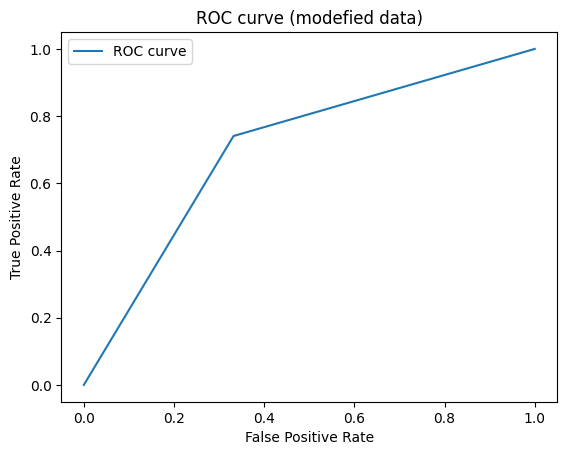

AUC: 0.7043989679120133
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  78.2%


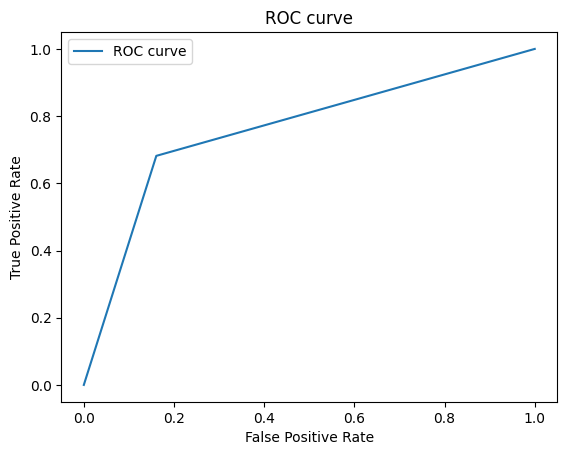

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 18s 10ms/step - loss: 1.0701 - fn: 1805.0000 - fp: 172232.0000 - tn: 535107.0000 - tp: 6346.0000 - precision: 0.0355 - recall: 0.7786 - f1: 0.0715 - val_loss: 0.6266 - val_fn: 0.0000e+00 - val_fp: 23315.0000 - val_tn: 56184.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 14s 10ms/step - loss: 0.9974 - fn: 1674.0000 - fp: 148337.0000 - tn: 559002.0000 - tp: 6477.0000 - precision: 0.0418 - recall: 0.7946 - f1: 0.0802 - val_loss: 0.6181 - val_fn: 0.0000e+00 - val_fp: 25157.0000 - val_tn: 54342.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 14s 10ms/step - l

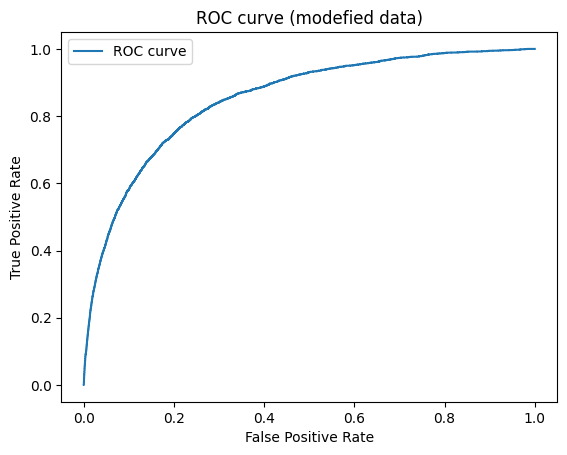

AUC: 0.8521844351052316
TPR:  42.67% 
FPR:  5.0% 
Threshold:  0.29
Predictive Equality:  60.540000000000006%
6407/6407 [==============================] - 14s 2ms/step


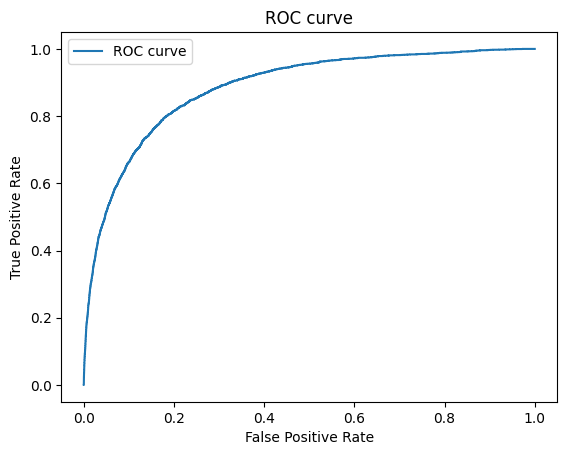

AUC: 0.8851152295720965
TPR:  51.53% 
FPR:  4.9799999999999995% 
Threshold:  0.92
Predictive Equality:  99.14%


In [ ]:
data_comparison (X_train_smote, X_test_smote, y_train_smote, y_test_smote, scaling_type='standardscaler')

##ADASYN

In [ ]:
# Load Base.csv
df_adasyn= pd.read_csv('/content/Base.csv')
# Remove "device_fraud_count", it's 0 for all entries
print(df_adasyn['device_fraud_count'].value_counts()) # It's 0 for all rows
df_adasyn = df_adasyn.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:
df_adasyn.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           1     0.9               0.166828                         -1   
1           1     0.9               0.296286                         -1   
2           1     0.9               0.044985                         -1   
3           1     0.9               0.159511                         -1   
4           1     0.9               0.596414                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            88            50            0.020925   
1                           144            50            0.005418   
2                           132            40            3.108549   
3                            22            50            0.019079   
4                           218            50            0.004441   

   intended_balcon_amount payment_type  zip_count_4w  ...  bank_months_count  \
0               -1.331345           AA           769  ...                 24   
1               -0.816224           AB           366  ...                 15   
2               -0.755728           AC           870  ...                 -1   
3               -1.205124           AB           810  ...                 31   
4               -0.773276           AB           890  ...                 31   

   has_other_cards  proposed_credit_limit  foreign_request    source  \
0                0                  500.0                0  INTERNET   
1                0                 1500.0                0  INTERNET   
2                0                  200.0                0  INTERNET   
3                1                  200.0                0  INTERNET   
4                0                 1500.0                0  INTERNET   

  session_length_in_minutes  device_os  keep_alive_session  \
0                  3.888115    windows                   0   
1                 31.798819    windows                   0   
2                  4.728705      other                   0   
3                  2.047904      linux                   0   
4                  3.775225  macintosh                   1   

  device_distinct_emails_8w  month  
0                         1      7  
1                         1      7  
2                         1      7  
3                         1      7  
4                         1      7  

[5 rows x 31 columns]

In [ ]:
df_adasyn.fraud_bool.value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

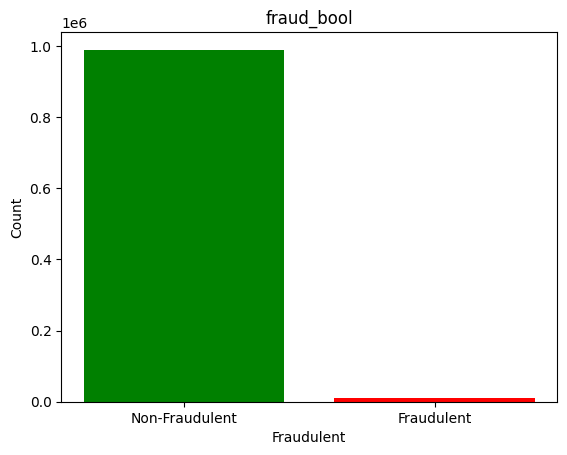

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the value counts
value_counts = df_adasyn['fraud_bool'].value_counts()

# Plotting the data as a bar plot
plt.bar(value_counts.index, value_counts.values, color=['green', 'red'])

# Customizing the plot
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('fraud_bool')
plt.xticks(value_counts.index, ['Non-Fraudulent', 'Fraudulent'])  # Using custom x-axis labels

# Display the plot
plt.show()


In [ ]:
# Split data into features and target
X = df_adasyn.drop(['fraud_bool'], axis=1)
y = df_adasyn['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train_adasyn = X[X['month']<6].copy()
X_test_adasyn = X[X['month']>=6].copy()
y_train_adasyn = y[X['month']<6].copy()
y_test_adasyn = y[X['month']>=6].copy()

X_train_adasyn.drop('month', axis=1, inplace=True)
X_test_adasyn.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
s = (X_train_adasyn.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [ ]:
X_train_adasyn.head()

income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   
96844     0.8               0.442439                         -1   
96845     0.9               0.328328                         -1   
96846     0.7               0.033834                         -1   
96847     0.9               0.150643                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   
96844                           107            40            0.021131   
96845                            79            70            0.009110   
96846                            28            30            0.004707   
96847                           164            40            0.012221   

       intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
96843               -0.906840           AC          1779   1147.615990  ...   
96844               -1.553115           AC          1195  10788.642570  ...   
96845               -0.801146           AC           845   8504.451753  ...   
96846               -1.171706           AB          1697   6011.217859  ...   
96847               -0.227823           AB          1474   8378.324044  ...   

       phone_mobile_valid  bank_months_count  has_other_cards  \
96843                   1                 -1                0   
96844                   1                 -1                0   
96845                   1                 -1                0   
96846                   1                 28                0   
96847                   1                  5                0   

       proposed_credit_limit foreign_request    source  \
96843                  200.0               0  INTERNET   
96844                  200.0               0  INTERNET   
96845                 2000.0               0  INTERNET   
96846                 1000.0               0  INTERNET   
96847                 1500.0               0  INTERNET   

       session_length_in_minutes device_os  keep_alive_session  \
96843                   3.911696     linux                   0   
96844                  23.696737     other                   0   
96845                   2.803927   windows                   0   
96846                   5.262441   windows                   1   
96847                   5.728984   windows                   0   

       device_distinct_emails_8w  
96843                          1  
96844                          2  
96845                          1  
96846                          2  
96847                          1  

[5 rows x 29 columns]

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train_adasyn[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test_adasyn[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train_adasyn.index
ohe_cols_test.index = X_test_adasyn.index

# Remove the object columns from the training and test data
num_X_train = X_train_adasyn.drop(object_cols, axis=1)
num_X_test = X_test_adasyn.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train_adasyn = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test_adasyn = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train_adasyn.columns = X_train_adasyn.columns.astype(str)
X_test_adasyn.columns = X_test_adasyn.columns.astype(str)

# See that it replaced all categorical values
X_train_adasyn.head(1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   

       intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...  \
96843                -0.90684          1779   1147.61599   3076.384487  ...   

        16   17   18   19   20   21   22   23   24   25  
96843  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  

[1 rows x 50 columns]

In [ ]:
from imblearn.over_sampling import ADASYN

# X is the feature matrix and y is the target vector
adasyn = ADASYN(random_state=42,sampling_strategy='auto', n_neighbors=5)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_adasyn, y_train_adasyn)

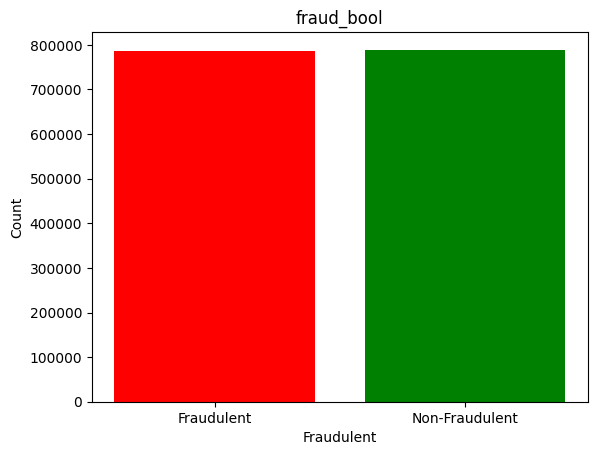

In [ ]:
# Calculate the value counts
value_counts = y_train_adasyn.value_counts()

# Plotting the data as a bar plot
plt.bar(value_counts.index, value_counts.values, color=['green', 'red'])

# Customizing the plot
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('fraud_bool')
plt.xticks(value_counts.index, ['Non-Fraudulent', 'Fraudulent'])  # Using custom x-axis labels

# Display the plot
plt.show()

In [ ]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_train_adasyn))

Resampled dataset shape Counter({1: 789108, 0: 786838})


In [ ]:
print("length of train data ",len(y_train_adasyn))
print("length of test data ",len(y_test_adasyn))

length of train data  1575946
length of test data  205011



 Results for Logistic regression 



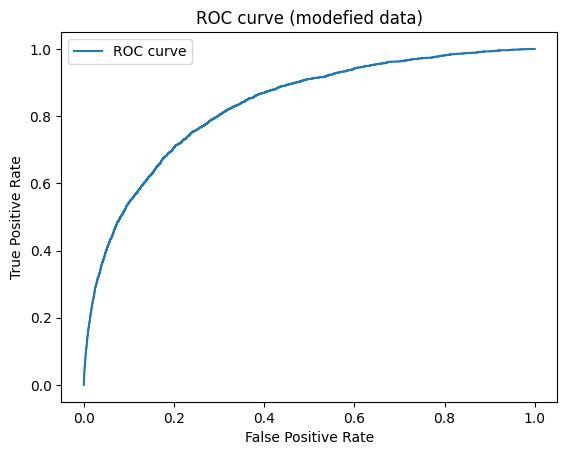

AUC: 0.8319788359164796
TPR:  40.06% 
FPR:  4.99% 
Threshold:  0.74
Predictive Equality:  81.44%


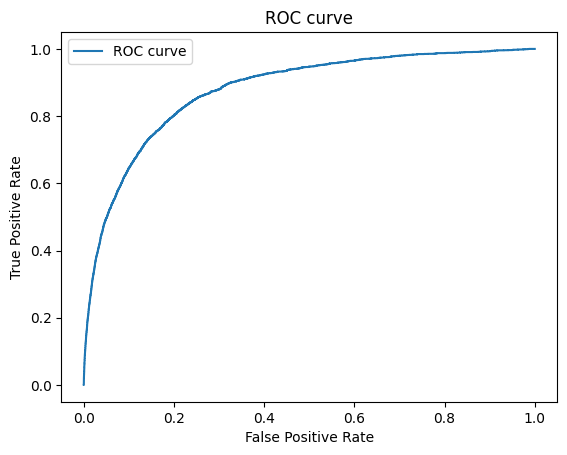

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



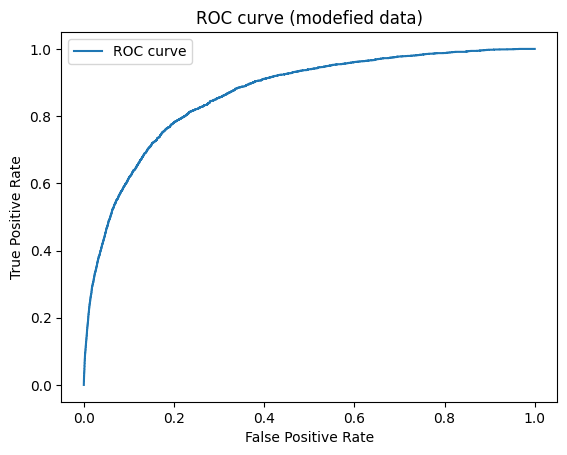

AUC: 0.8662556065069852
TPR:  46.489999999999995% 
FPR:  4.99% 
Threshold:  0.82
Predictive Equality:  74.42999999999999%


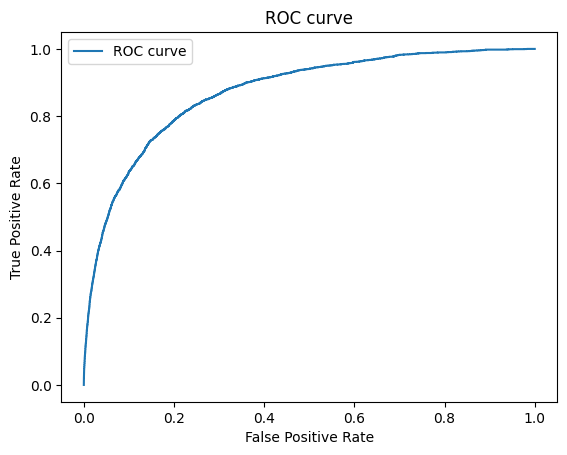

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



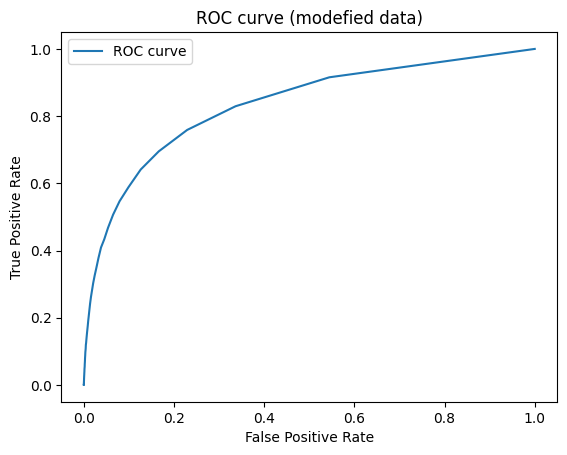

AUC: 0.8333299036725375
TPR:  43.33% 
FPR:  4.53% 
Threshold:  0.1
Predictive Equality:  44.769999999999996%


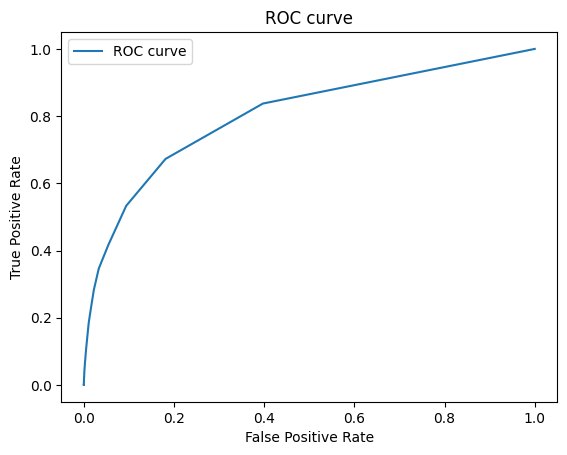

AUC: 0.8036299871942181
TPR:  34.61% 
FPR:  3.3099999999999996% 
Threshold:  0.05
Predictive Equality:  34.36%

 Results for DecisionTree classifier



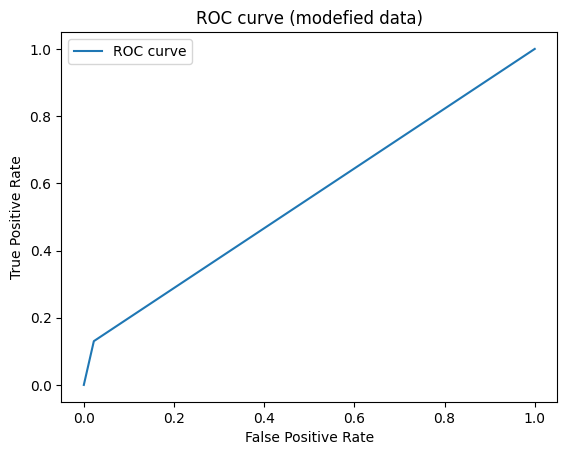

AUC: 0.5540280189403362
TPR:  13.03% 
FPR:  2.22% 
Threshold:  1.0
Predictive Equality:  38.66%


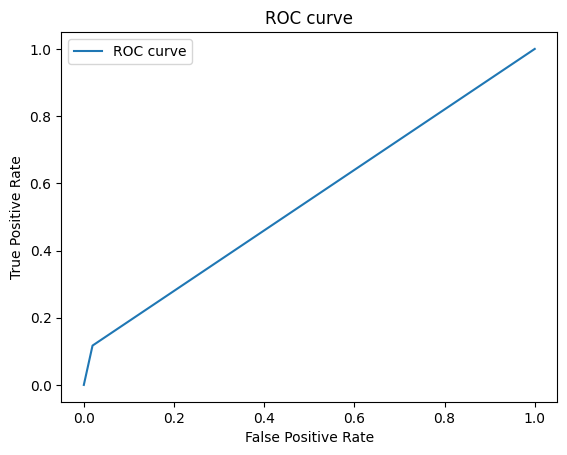

AUC: 0.5488856472544495
TPR:  11.709999999999999% 
FPR:  1.9300000000000002% 
Threshold:  1.0
Predictive Equality:  41.52%

 Results for naive bayes classifier 



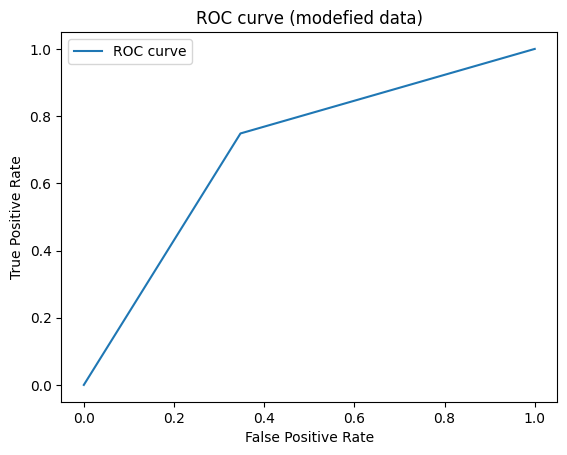

AUC: 0.7005157438585999
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  79.52%


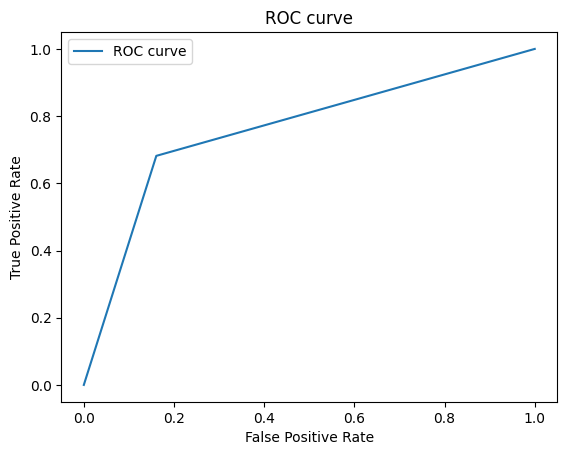

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 17s 9ms/step - loss: 1.0122 - fn: 1569.0000 - fp: 161208.0000 - tn: 546131.0000 - tp: 6582.0000 - precision: 0.0392 - recall: 0.8075 - f1: 0.0756 - val_loss: 0.5732 - val_fn: 0.0000e+00 - val_fp: 21006.0000 - val_tn: 58493.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9902 - fn: 1627.0000 - fp: 149370.0000 - tn: 557969.0000 - tp: 6524.0000 - precision: 0.0418 - recall: 0.8004 - f1: 0.0802 - val_loss: 0.6287 - val_fn: 0.0000e+00 - val_fp: 23379.0000 - val_tn: 56120.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - loss

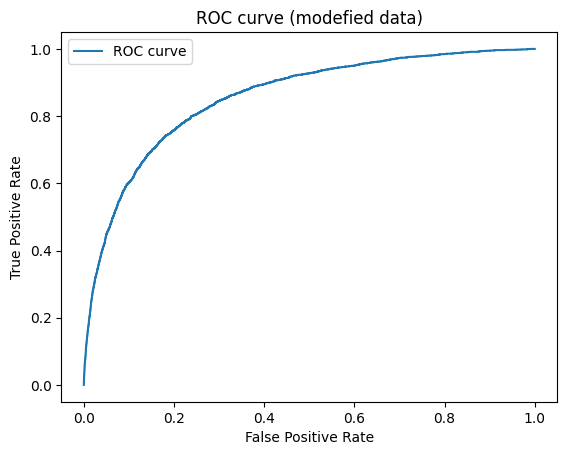

AUC: 0.8558936308756342
TPR:  44.79% 
FPR:  5.0% 
Threshold:  0.21
Predictive Equality:  48.53%
6407/6407 [==============================] - 14s 2ms/step


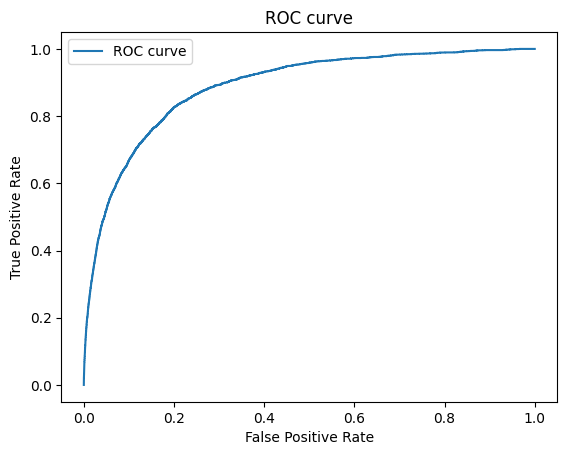

AUC: 0.8874803529943148
TPR:  52.190000000000005% 
FPR:  5.0% 
Threshold:  0.96
Predictive Equality:  81.51%


In [ ]:
data_comparison (X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn, scaling_type='standardscaler')

##Borderline SMOTE


In [ ]:
# Load Base.csv
df_base0001 = pd.read_csv('Base.csv')
# Remove "device_fraud_count", it's 0 for all entries
print(df_base0001['device_fraud_count'].value_counts()) # It's 0 for all rows
df_base0001 = df_base0001.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:
# Count the number non-frauds and frauds
df_base0001['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [ ]:
# Split data into features and target
X0001 = df_base0001.drop(['fraud_bool'], axis=1)
y0001 = df_base0001['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train0001 = X0001[X0001['month']<6]
X_test0001 = X0001[X0001['month']>=6]
y_train0001 = y0001[X0001['month']<6]
y_test0001 = y0001[X0001['month']>=6]

X_train0001.drop('month', axis=1, inplace=True)
X_test0001.drop('month', axis=1, inplace=True)

<ipython-input-40-dc9b12c557cb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train0001.drop('month', axis=1, inplace=True)
<ipython-input-40-dc9b12c557cb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test0001.drop('month', axis=1, inplace=True)


In [ ]:
s0001 = (X_train0001.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols0001 = list(s0001[s0001].index) # All the columns containing these features
print(X0001[object_cols0001])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [ ]:
ohe0001 = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train0001 = pd.DataFrame(ohe0001.fit_transform(X_train0001[object_cols]))
ohe_cols_test0001 = pd.DataFrame(ohe0001.transform(X_test0001[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train0001.index = X_train0001.index
ohe_cols_test0001.index = X_test0001.index

# Remove the object columns from the training and test data
num_X_train0001 = X_train0001.drop(object_cols, axis=1)
num_X_test0001 = X_test0001.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train0001 = pd.concat([num_X_train0001, ohe_cols_train0001], axis=1)
X_test0001 = pd.concat([num_X_test0001, ohe_cols_test0001], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train0001.columns = X_train0001.columns.astype(str)
X_test0001.columns = X_test0001.columns.astype(str)

# See that it replaced all categorical values
X_train0001.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   
96844     0.8               0.442439                         -1   
96845     0.9               0.328328                         -1   
96846     0.7               0.033834                         -1   
96847     0.9               0.150643                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   
96844                           107            40            0.021131   
96845                            79            70            0.009110   
96846                            28            30            0.004707   
96847                           164            40            0.012221   

       intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  ...  \
96843               -0.906840          1779   1147.615990   3076.384487  ...   
96844               -1.553115          1195  10788.642570   5790.128646  ...   
96845               -0.801146           845   8504.451753   5912.163054  ...   
96846               -1.171706          1697   6011.217859   5505.127811  ...   
96847               -0.227823          1474   8378.324044   4930.672316  ...   

        16   17   18   19   20   21   22   23   24   25  
96843  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  
96844  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  
96845  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
96846  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
96847  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 50 columns]

In [ ]:
# Import BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE

# Create an instance of BorderlineSMOTE with kind='borderline-1'
bs = BorderlineSMOTE(kind='borderline-1', random_state=42)

# Fit and resample the training data
X_train_res0001, y_train_res0001 = bs.fit_resample(X_train0001, y_train0001)

# Check the new class distribution
print(y_train_res0001.value_counts())

1    786838
0    786838
Name: fraud_bool, dtype: int64


In [ ]:
X_train0001['16'].value_counts()

0.0    655780
1.0    139209
Name: 16, dtype: int64

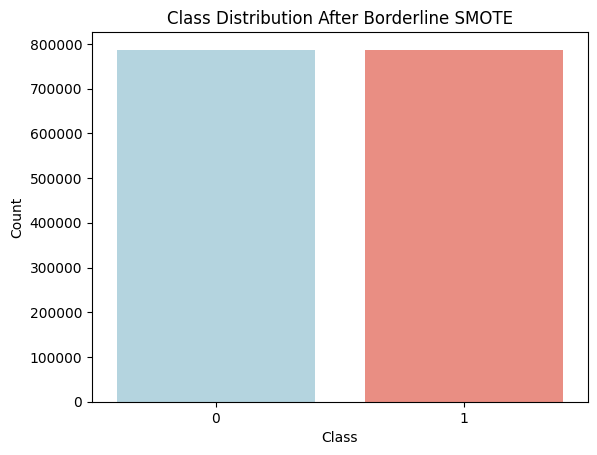

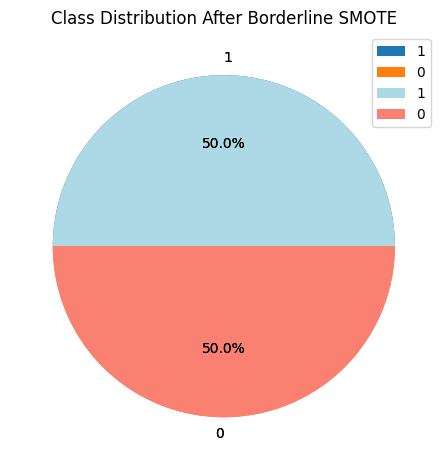

In [ ]:
import seaborn as sns
# Set the color palette for the plots
colors = ['lightblue', 'salmon']

# Plot a bar chart of the class distribution
sns.countplot(x=y_train_res0001)
sns.countplot(x=y_train_res0001, palette=colors)
plt.title('Class Distribution After Borderline SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot a pie chart of the class distribution
plt.pie(y_train_res0001.value_counts(), labels=y_train_res0001.unique(), autopct='%1.1f%%')
plt.pie(y_train_res0001.value_counts(), labels=y_train_res0001.unique(), autopct='%1.1f%%', colors=colors)
plt.title('Class Distribution After Borderline SMOTE')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


 Results for Logistic regression 



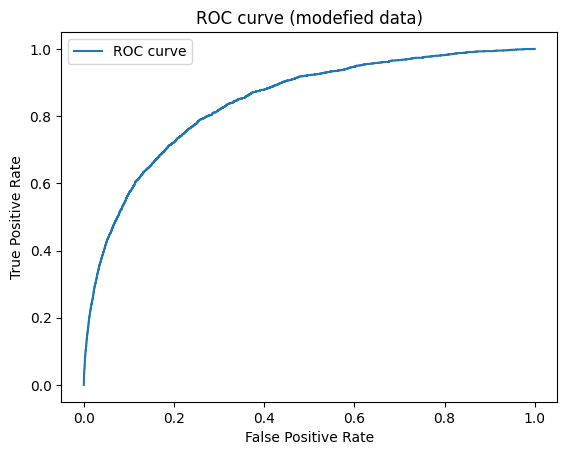

AUC: 0.8426619883514934
TPR:  42.36% 
FPR:  4.99% 
Threshold:  0.71
Predictive Equality:  81.47999999999999%


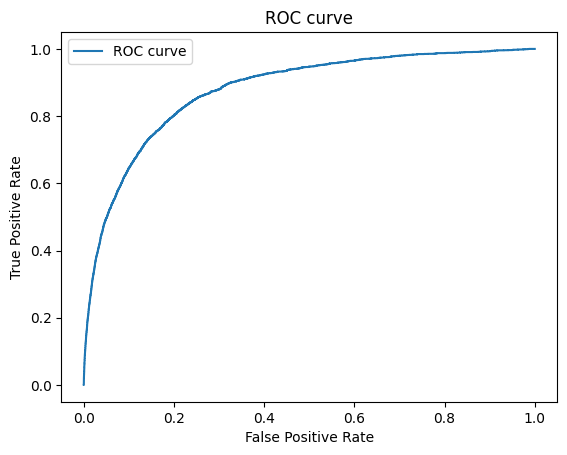

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



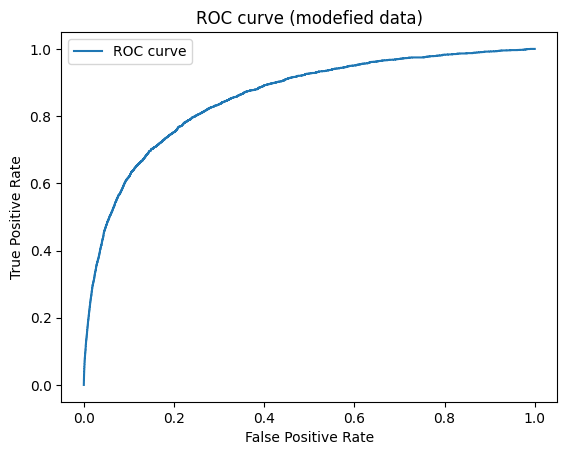

AUC: 0.856070842718144
TPR:  47.53% 
FPR:  4.9799999999999995% 
Threshold:  0.82
Predictive Equality:  74.53999999999999%


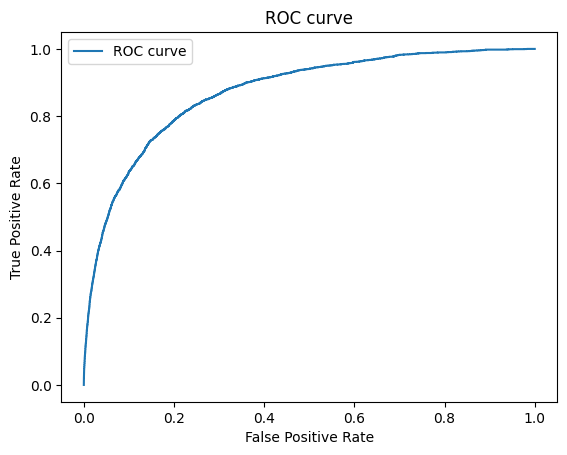

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



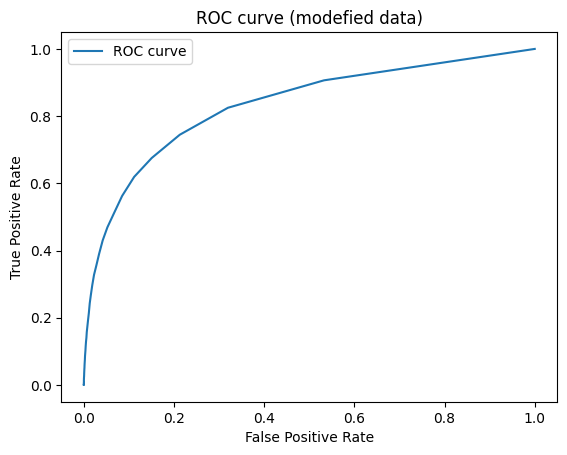

AUC: 0.8323964099391457
TPR:  43.02% 
FPR:  4.18% 
Threshold:  0.09
Predictive Equality:  40.9%


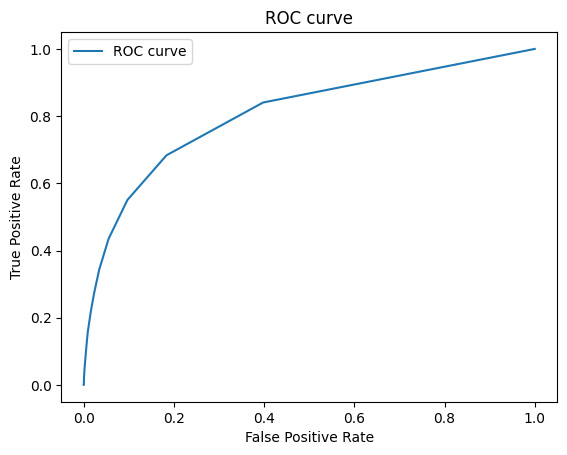

AUC: 0.8071139272212239
TPR:  34.260000000000005% 
FPR:  3.4000000000000004% 
Threshold:  0.05
Predictive Equality:  34.2%

 Results for DecisionTree classifier



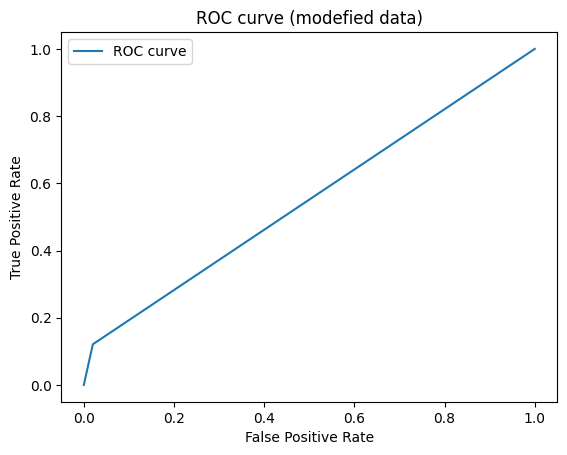

AUC: 0.5504677052865656
TPR:  12.09% 
FPR:  2.0% 
Threshold:  1.0
Predictive Equality:  44.92%


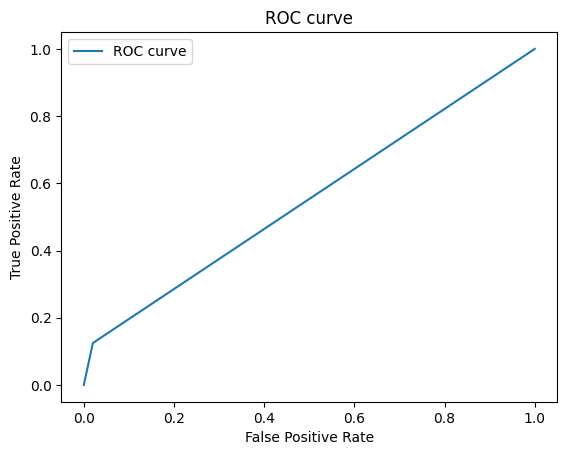

AUC: 0.552349071200126
TPR:  12.47% 
FPR:  2.0% 
Threshold:  1.0
Predictive Equality:  42.66%

 Results for naive bayes classifier 



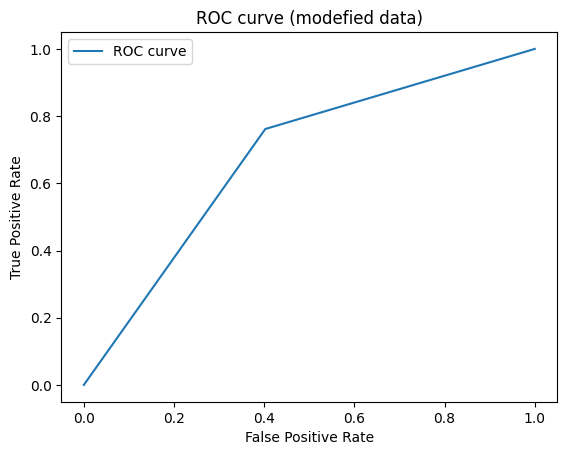

AUC: 0.6795812255760005
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  85.15%


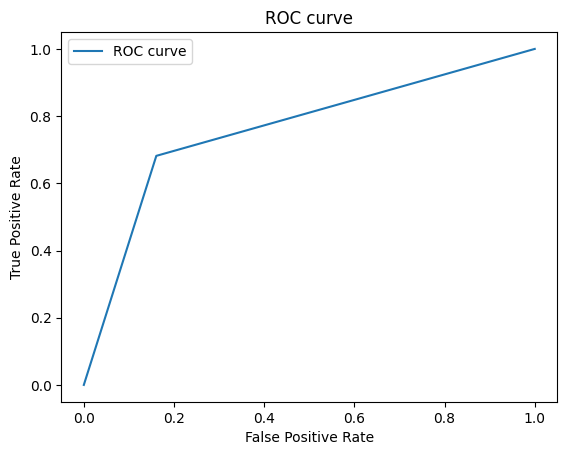

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 19s 10ms/step - loss: 1.0655 - fn: 1639.0000 - fp: 183944.0000 - tn: 523395.0000 - tp: 6512.0000 - precision: 0.0342 - recall: 0.7989 - f1: 0.0681 - val_loss: 0.7759 - val_fn: 0.0000e+00 - val_fp: 31778.0000 - val_tn: 47721.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 1.0023 - fn: 1528.0000 - fp: 167771.0000 - tn: 539568.0000 - tp: 6623.0000 - precision: 0.0380 - recall: 0.8125 - f1: 0.0736 - val_loss: 0.4575 - val_fn: 0.0000e+00 - val_fp: 18874.0000 - val_tn: 60625.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - los

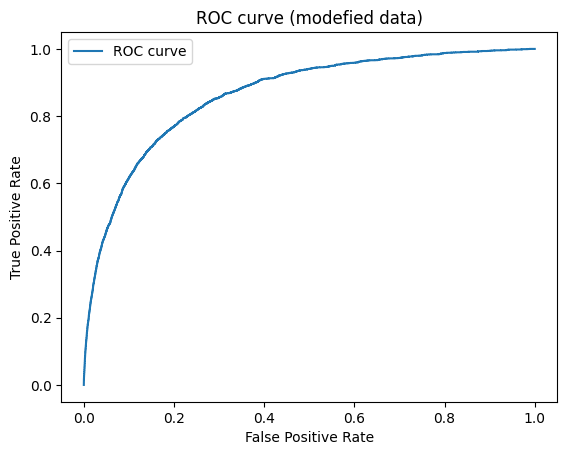

AUC: 0.8638806668231469
TPR:  45.73% 
FPR:  5.0% 
Threshold:  0.23
Predictive Equality:  53.11%
6407/6407 [==============================] - 14s 2ms/step


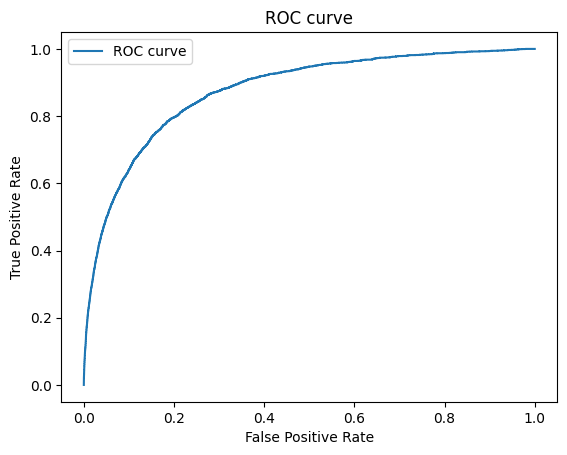

AUC: 0.8756249097812414
TPR:  49.72% 
FPR:  4.9799999999999995% 
Threshold:  0.9
Predictive Equality:  91.07%


In [ ]:
data_comparison (X_train_res0001, X_test0001, y_train_res0001, y_test0001, scaling_type='standardscaler')

##Random Over-Sampling "ROS"

In [ ]:
# improt nesseary pakages
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

import seaborn as sns
import matplotlib.pyplot as plt

###Load Data

In [ ]:
df_enn= pd.read_csv('/content/Base.csv')

###Data Exploration

In [ ]:
df_enn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
df_enn.head().T

0            1            2  \
fraud_bool                                   1            1            1   
income                                     0.9          0.9          0.9   
name_email_similarity                 0.166828     0.296286     0.044985   
prev_address_months_count                   -1           -1           -1   
current_address_months_count                88          144          132   
customer_age                                50           50           40   
days_since_request                    0.020925     0.005418     3.108549   
intended_balcon_amount               -1.331345    -0.816224    -0.755728   
payment_type                                AA           AB           AC   
zip_count_4w                               769          366          870   
velocity_6h                       10650.765523   534.047319  4048.534263   
velocity_24h                        3134.31963  2670.918292  2893.621498   
velocity_4w                         3863.64774  3124.298166  3159.590679   
bank_branch_count_8w                         1          718            1   
date_of_birth_distinct_emails_4w             6            3           14   
employment_status                           CA           CA           CB   
credit_risk_score                          185          259          177   
email_is_free                                0            1            1   
housing_status                              BA           BA           BA   
phone_home_valid                             1            0            0   
phone_mobile_valid                           0            0            1   
bank_months_count                           24           15           -1   
has_other_cards                              0            0            0   
proposed_credit_limit                    500.0       1500.0        200.0   
foreign_request                              0            0            0   
source                                INTERNET     INTERNET     INTERNET   
session_length_in_minutes             3.888115    31.798819     4.728705   
device_os                              windows      windows        other   
keep_alive_session                           0            0            0   
device_distinct_emails_8w                    1            1            1   
device_fraud_count                           0            0            0   
month                                        7            7            7   

                                            3            4  
fraud_bool                                  1            1  
income                                    0.9          0.9  
name_email_similarity                0.159511     0.596414  
prev_address_months_count                  -1           -1  
current_address_months_count               22          218  
customer_age                               50           50  
days_since_request                   0.019079     0.004441  
intended_balcon_amount              -1.205124    -0.773276  
payment_type                               AB           AB  
zip_count_4w                              810          890  
velocity_6h                       3457.064063  5020.341679  
velocity_24h                      4054.908412  2728.237159  
velocity_4w                       3022.261812  3087.670952  
bank_branch_count_8w                     1921         1990  
date_of_birth_distinct_emails_4w            6            2  
employment_status                          CA           CA  
credit_risk_score                         110          295  
email_is_free                               1            1  
housing_status                             BA           BA  
phone_home_valid                            0            1  
phone_mobile_valid                          1            0  
bank_months_count                          31           31  
has_other_cards                             1            0  
proposed_credit_limit                   200.0       1500.0  
foreign_req

In [ ]:
# # Loop through each column in the dataframe
# for col in df_enn.columns:
#     # Print the name of the column
#     print("\nColumn Name:", col)
#     # Print the value counts of each unique value found in the column
#     print(df_enn[col].value_counts())

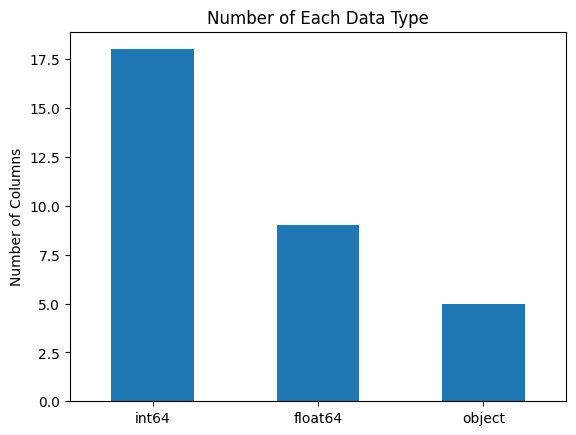

In [ ]:
# Calculate the number of each data type
data_type_counts = df_enn.dtypes.value_counts()

# Create a bar plot
#plt.figure(figsize=(10, 6))
data_type_counts.plot(kind='bar')
plt.title('Number of Each Data Type')
plt.ylabel('Number of Columns')
plt.xticks(rotation=0)
plt.show()#

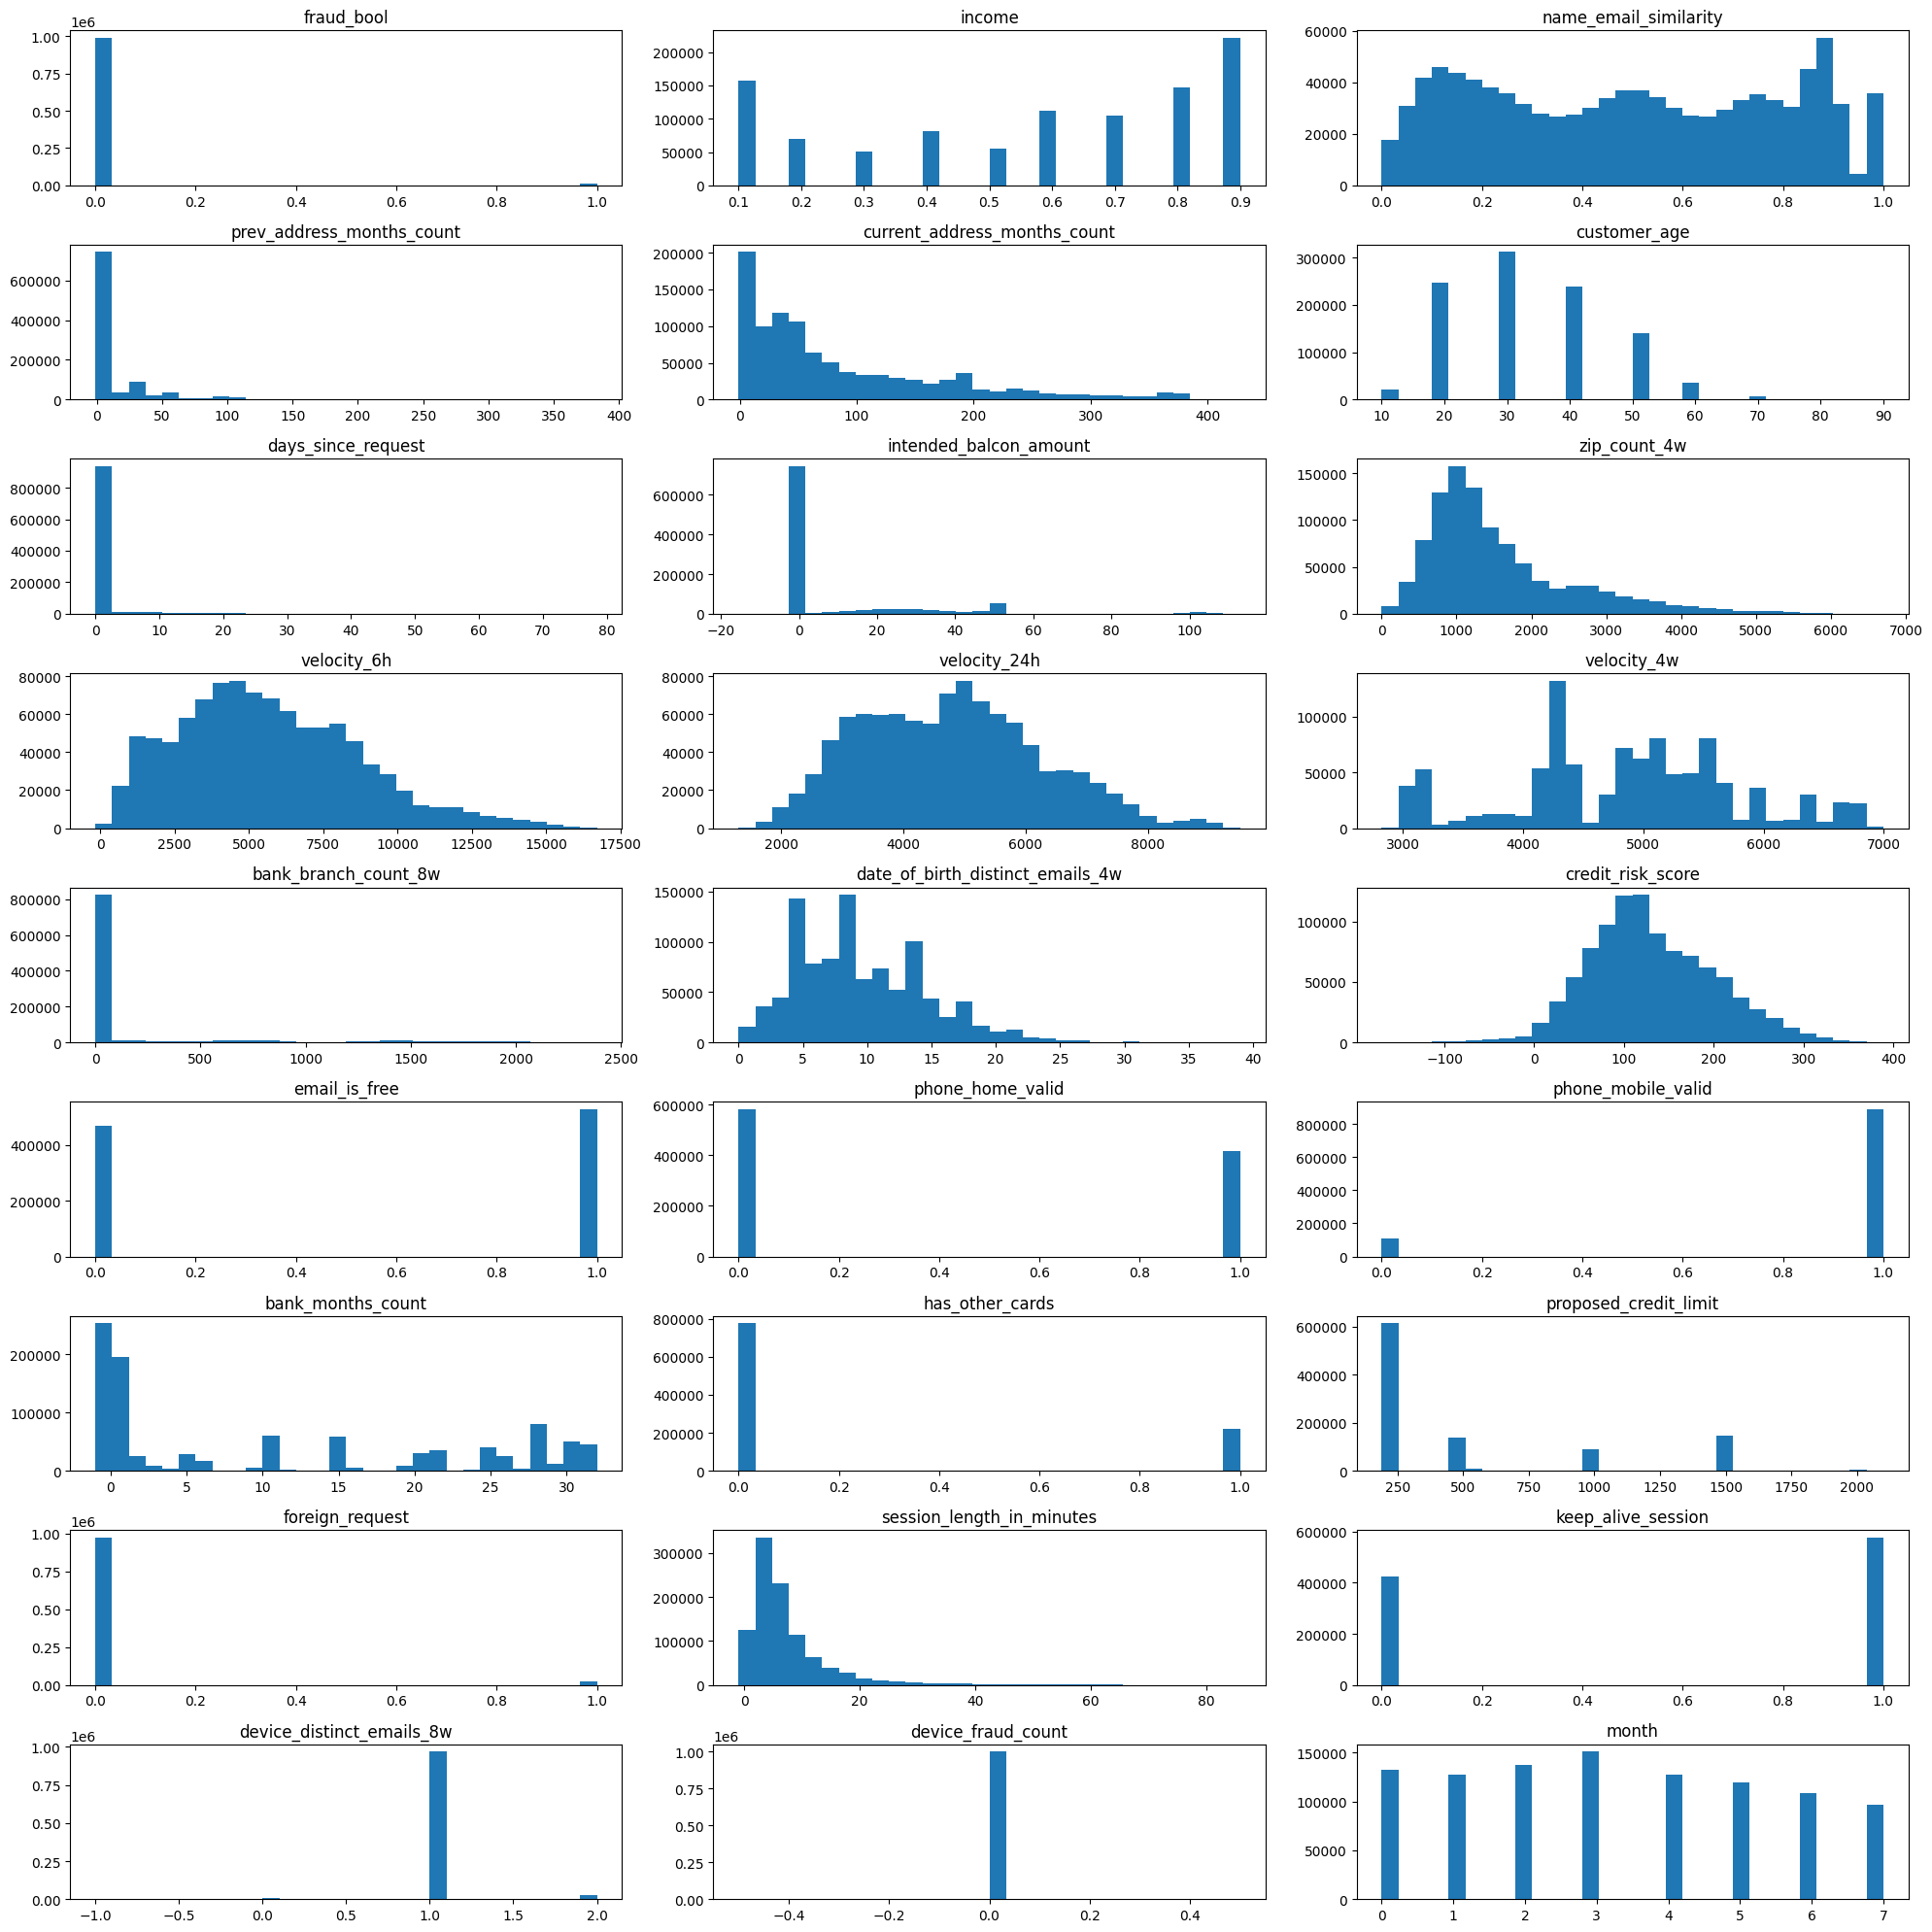

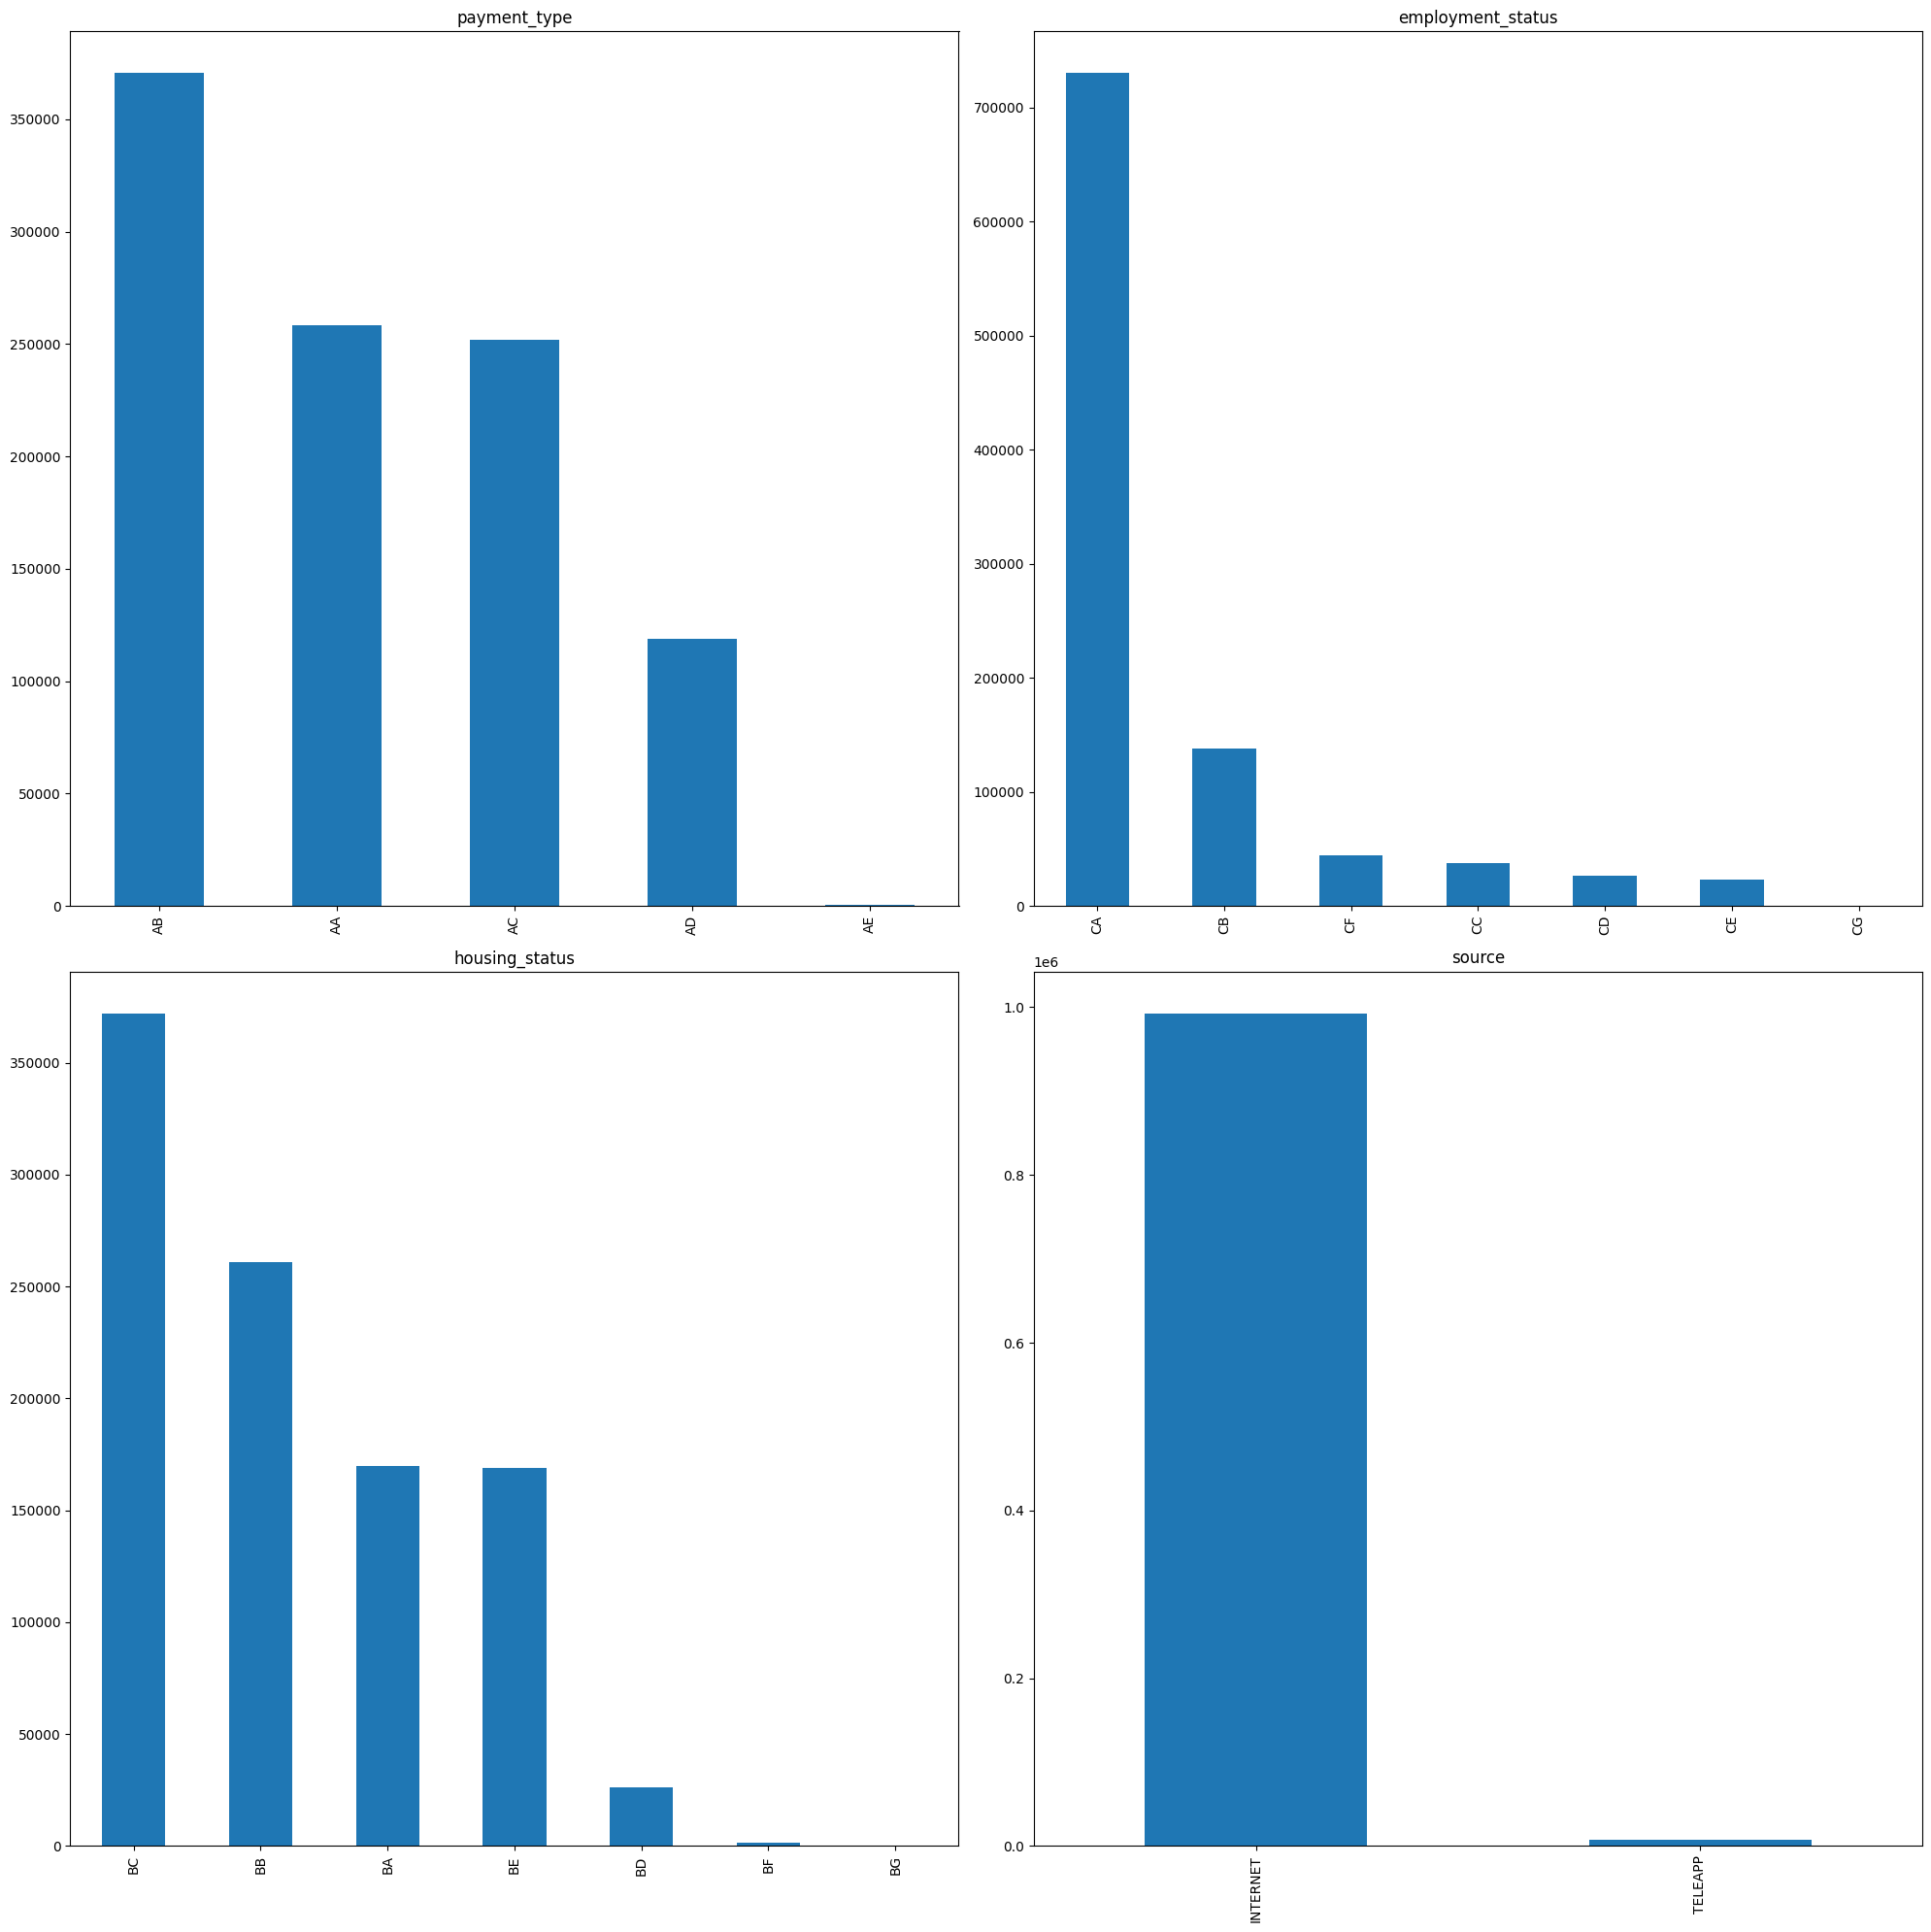

In [ ]:
# Let's visualize each of the columns in a histogram or bar chart depending on the type of the data

# Separate the dataset into numerical and categorical data
numerical_data = df_enn.select_dtypes(include=['int64', 'float64'])
categorical_data = df_enn.select_dtypes(include=['object'])

# Set up the matplotlib figure
fig, axes = plt.subplots(len(numerical_data.columns)//3, 3, figsize=(20, 20))

# Flatten the axes array and delete any extra plots
axes = axes.flatten()
for ax in axes[len(numerical_data.columns):]:
    fig.delaxes(ax)

# Plot a histogram for each numerical column
for ax, col in zip(axes, numerical_data.columns):
    ax.hist(numerical_data[col], bins=30)
    ax.set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()

# Set up the matplotlib figure for categorical columns
fig, axes = plt.subplots(len(categorical_data.columns)//2, 2, figsize=(20, 20))

# Flatten the axes array and delete any extra plots
axes = axes.flatten()
for ax in axes[len(categorical_data.columns):]:
    fig.delaxes(ax)

# Plot a bar chart for each categorical column
for ax, col in zip(axes, categorical_data.columns):
    categorical_data[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()


 the size of  the data before handel  outliers is (1000000, 32)
 the size of  the data after handel  outliers is (203590, 32)


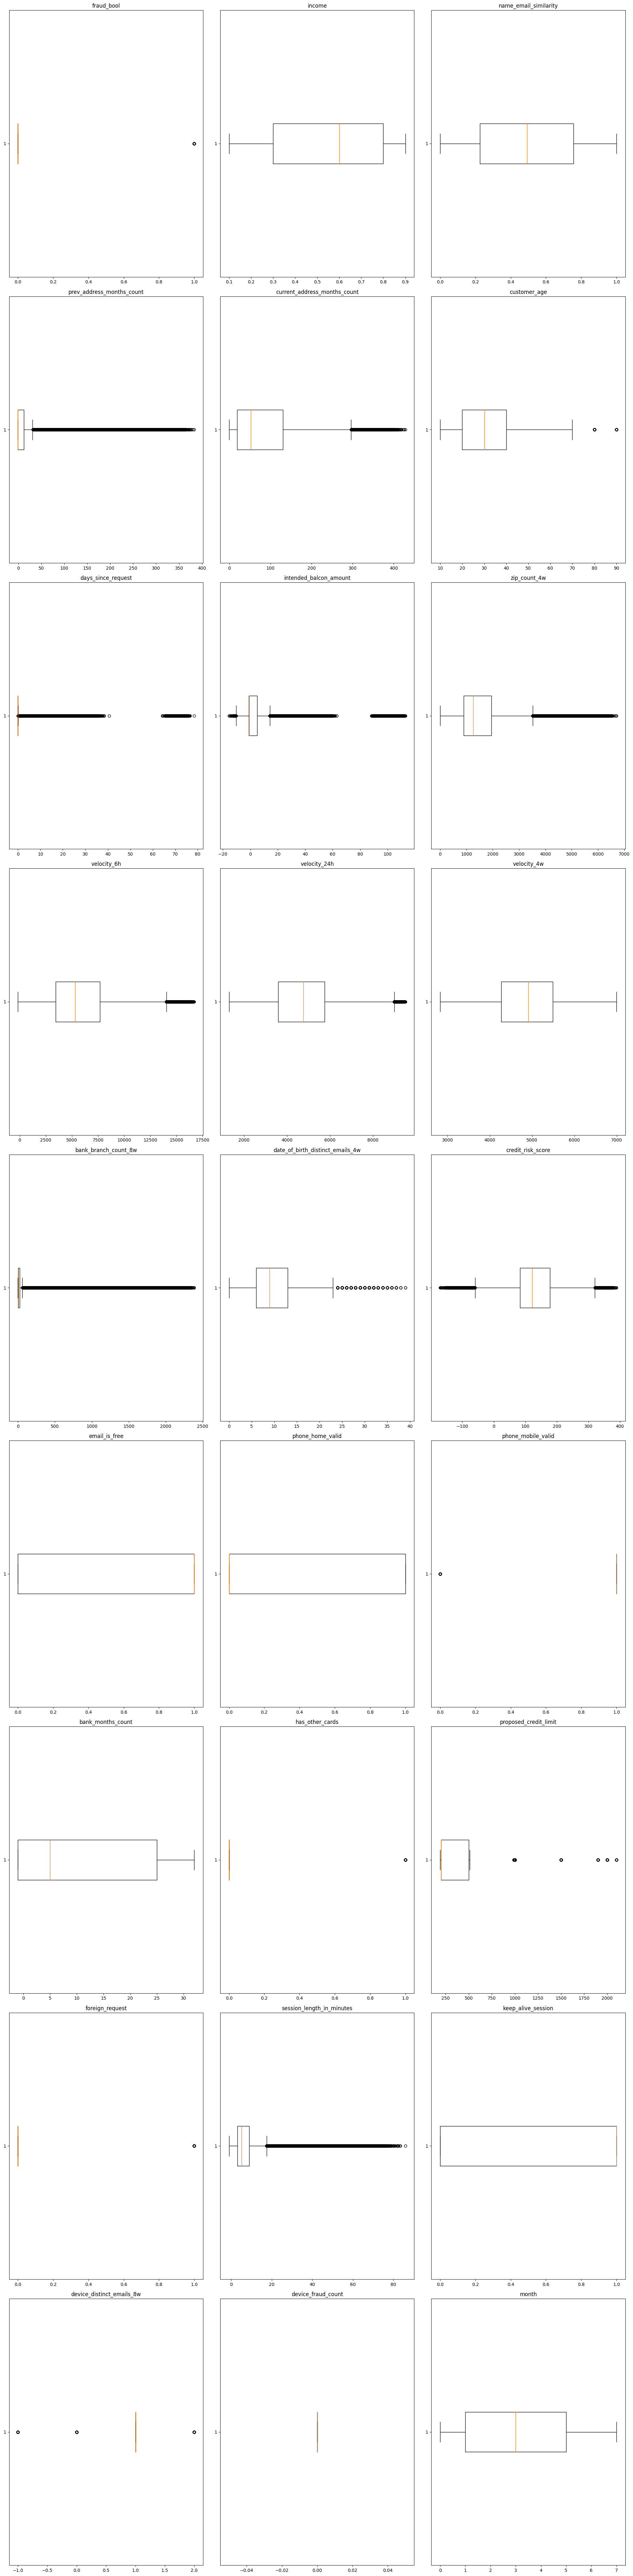

In [ ]:


# Identify the numerical columns
numerical_cols = df_enn.select_dtypes(include=['int64', 'float64']).columns
print(f" the size of  the data before handel  outliers is {df_enn.shape}")
# Remove outliers
data_no_outliers = df_enn.copy()
for col in numerical_cols:
    Q1 = data_no_outliers[col].quantile(0.25)
    Q3 = data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    # Filter out the outliers by keeping only valid values
    data_no_outliers = data_no_outliers[~((data_no_outliers[col] < (Q1 - 1.5 * IQR)) | (data_no_outliers[col] > (Q3 + 1.5 * IQR)))]


print(f" the size of  the data after handel  outliers is {data_no_outliers.shape}")
# Create box plots for all the numerical columns after removing the outliers
fig, axs = plt.subplots(len(numerical_cols)//3, 3, figsize=(20, 3*len(numerical_cols)))

# Flatten the axes array and delete any extra plots
axs = axs.flatten()
for ax in axs[len(numerical_cols):]:
    fig.delaxes(ax)

# Plot a box plot for each numerical column
for ax, col in zip(axs, numerical_cols):
    ax.boxplot(df_enn[col], vert=False) #If you want to   handel  outliers  replace df_enn with  data_no_outliers
    ax.set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()






 the size of  the data before handel  outliers is (1000000, 32)
 the size of  the data after handel  outliers is (203590, 32)


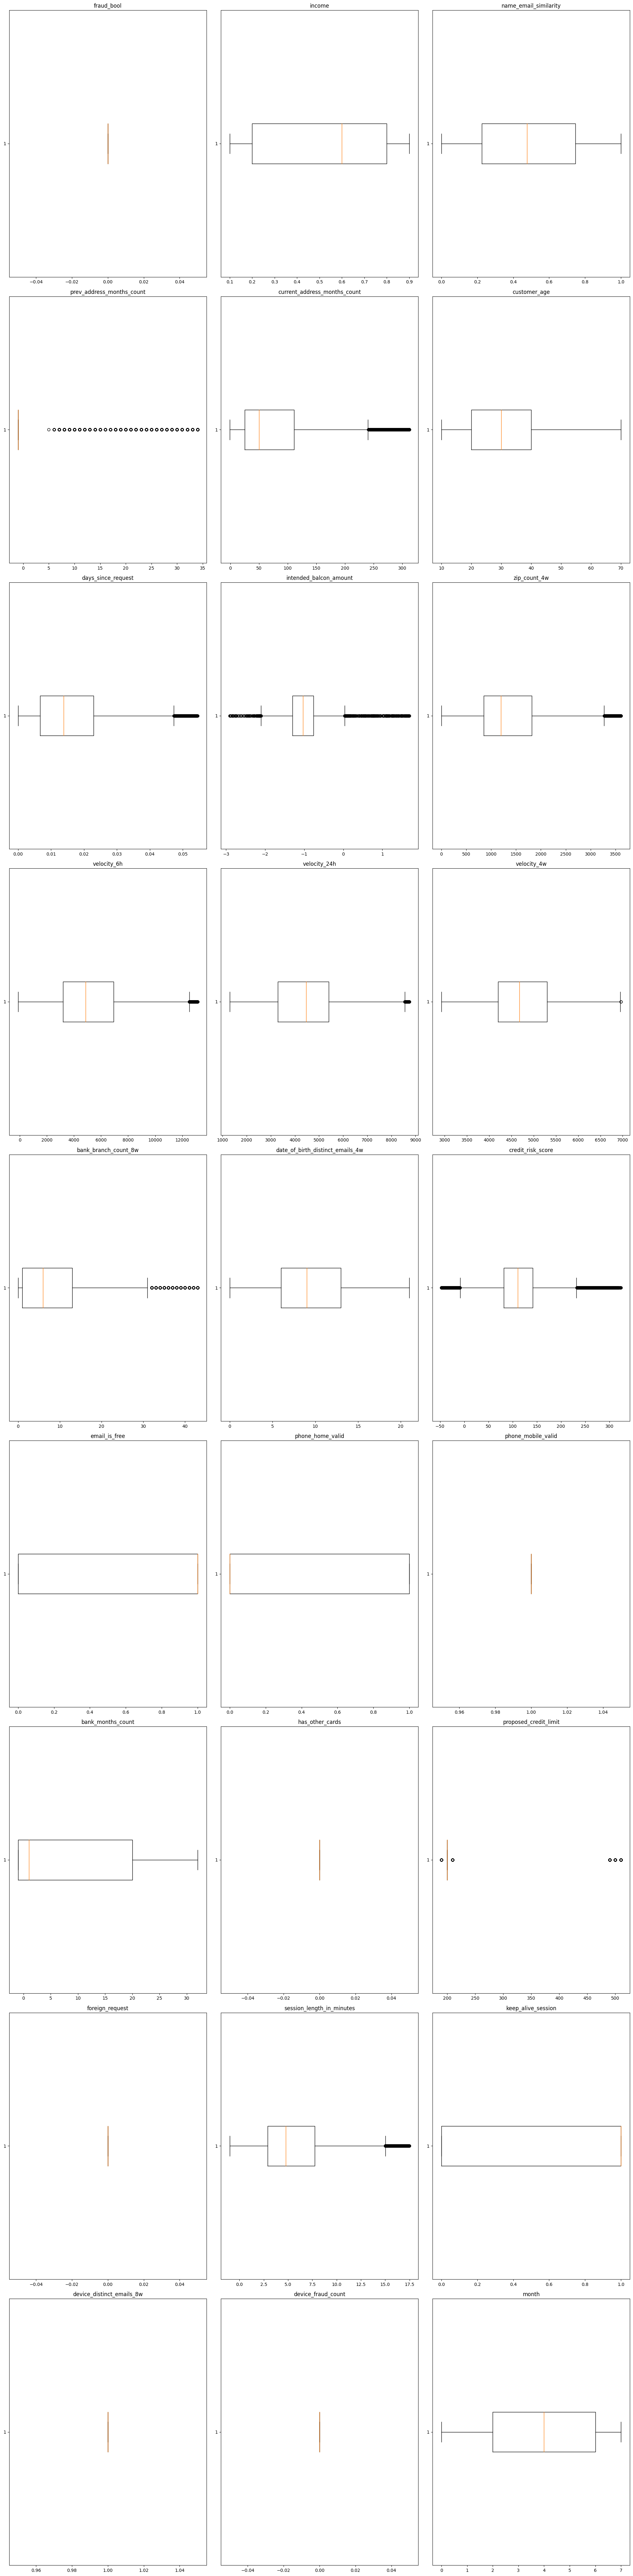

In [ ]:


# Identify the numerical columns
numerical_cols = df_enn.select_dtypes(include=['int64', 'float64']).columns
print(f" the size of  the data before handel  outliers is {df_enn.shape}")
# Remove outliers
data_no_outliers = df_enn.copy()
for col in numerical_cols:
    Q1 = data_no_outliers[col].quantile(0.25)
    Q3 = data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    # Filter out the outliers by keeping only valid values
    data_no_outliers = data_no_outliers[~((data_no_outliers[col] < (Q1 - 1.5 * IQR)) | (data_no_outliers[col] > (Q3 + 1.5 * IQR)))]


print(f" the size of  the data after handel  outliers is {data_no_outliers.shape}")
# Create box plots for all the numerical columns after removing the outliers
fig, axs = plt.subplots(len(numerical_cols)//3, 3, figsize=(20, 3*len(numerical_cols)))

# Flatten the axes array and delete any extra plots
axs = axs.flatten()
for ax in axs[len(numerical_cols):]:
    fig.delaxes(ax)

# Plot a box plot for each numerical column
for ax, col in zip(axs, numerical_cols):
    ax.boxplot(data_no_outliers[col], vert=False) #If you want to   handel  outliers  replace df_enn with  data_no_outliers
    ax.set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()






###Data pre-processing

In [ ]:
df_enn.shape

(1000000, 32)

In [ ]:
# Remove "device_fraud_count",  it contian only one unique value
print(df_enn['device_fraud_count'].value_counts()) # It's 0 for all rows

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:
df_enn = df_enn.drop(['device_fraud_count'], axis=1, errors='ignore')

In [ ]:
df_enn['fraud_bool'].value_counts(normalize = True)

0    0.988971
1    0.011029
Name: fraud_bool, dtype: float64

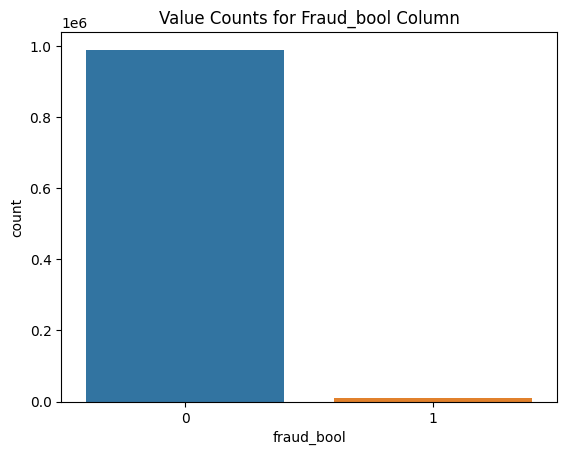

In [ ]:
sns.countplot(x='fraud_bool', data=df_enn)
plt.title('Value Counts for Fraud_bool Column')
plt.show()

In [ ]:
# Split data into features and target
X = df_enn.drop(['fraud_bool'], axis=1)
y = df_enn['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train_enn = X[X['month']<6].copy()
X_test_enn = X[X['month']>=6].copy()
y_train_enn= y[X['month']<6].copy()
y_test_enn= y[X['month']>=6].copy()

X_train_enn.drop('month', axis=1, inplace=True) ## why he drop month column ???????
X_test_enn.drop('month', axis=1, inplace=True)

In [ ]:
print(f"The shape of the Original data frame after spliting {df_enn.shape}")
print(f"The shape of the X_train  data frame after spliting {X_train_enn.shape}")
print(f"The shape of the X_test   data frame after spliting {X_test_enn.shape}")

The shape of the Original data frame after spliting (1000000, 31)
The shape of the X_train  data frame after spliting (794989, 29)
The shape of the X_test   data frame after spliting (205011, 29)


In [ ]:
s = (X_train_enn.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols].head())

  payment_type employment_status housing_status    source  device_os
0           AA                CA             BA  INTERNET    windows
1           AB                CA             BA  INTERNET    windows
2           AC                CB             BA  INTERNET      other
3           AB                CA             BA  INTERNET      linux
4           AB                CA             BA  INTERNET  macintosh


In [ ]:
print(f" Number of columns before Encodeing step is : {X_train_enn.shape[1]}")

 Number of columns before Encodeing step is : 29


In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train_enn[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test_enn[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train_enn.index
ohe_cols_test.index = X_test_enn.index

# Remove the object columns from the training and test data
num_X_train = X_train_enn.drop(object_cols, axis=1)
num_X_test = X_test_enn.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train_enn = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test_enn = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train_enn.columns = X_train_enn.columns.astype(str)
X_test_enn.columns = X_test_enn.columns.astype(str)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# See that it replaced all categorical values
X_train_enn.head(5)

income  name_email_similarity  prev_address_months_count  \
96843     0.8               0.153411                         -1   
96844     0.8               0.442439                         -1   
96845     0.9               0.328328                         -1   
96846     0.7               0.033834                         -1   
96847     0.9               0.150643                         -1   

       current_address_months_count  customer_age  days_since_request  \
96843                           105            30            0.003467   
96844                           107            40            0.021131   
96845                            79            70            0.009110   
96846                            28            30            0.004707   
96847                           164            40            0.012221   

       intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  ...  \
96843               -0.906840          1779   1147.615990   3076.384487  ...   
96844               -1.553115          1195  10788.642570   5790.128646  ...   
96845               -0.801146           845   8504.451753   5912.163054  ...   
96846               -1.171706          1697   6011.217859   5505.127811  ...   
96847               -0.227823          1474   8378.324044   4930.672316  ...   

        16   17   18   19   20   21   22   23   24   25  
96843  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  
96844  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  
96845  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
96846  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
96847  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 50 columns]

In [ ]:
print(f"The shape of the X_train  data frame after spliting {X_train_enn.shape}")
print(f"The shape of the X_test   data frame after spliting {X_test_enn.shape}")

The shape of the X_train  data frame after spliting (794989, 50)
The shape of the X_test   data frame after spliting (205011, 50)


### Random Over-Sampling

#### Random Over-Sampling is a technique used to address class imbalance in a dataset by randomly duplicating instances from the minority class until it reaches the same number as the majority class. This increases the prevalence of the minority class, helping to improve the model's performance on it. However, it can also lead to overfitting due to the creation of exact replicas of instances.

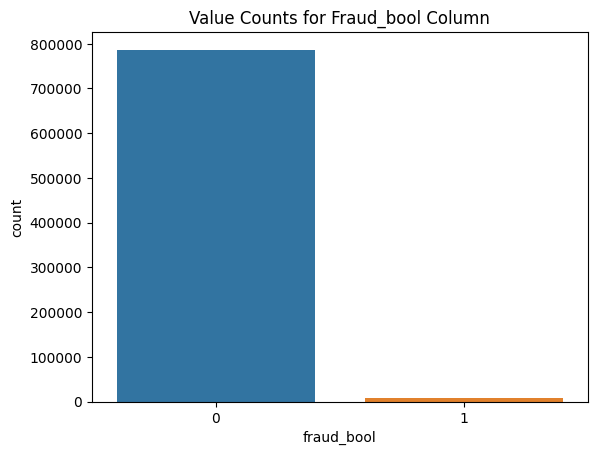

In [ ]:
sns.countplot(x=y_train_enn)
plt.title('Value Counts for Fraud_bool Column')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )
# Apply ENN cleaning
X_train_ros, y_train_ros = randomover.fit_resample(X_train_enn, y_train_enn)

# Check the new class distribution
print(y_train_ros.value_counts()/len(y_train_ros))

1    0.5
0    0.5
Name: fraud_bool, dtype: float64


In [ ]:
# Check the new class distribution
print(y_train_ros.value_counts()/len(y_train_ros))

1    0.5
0    0.5
Name: fraud_bool, dtype: float64


In [ ]:
X_train_ros['16'].value_counts()

0.0    1391953
1.0     181723
Name: 16, dtype: int64

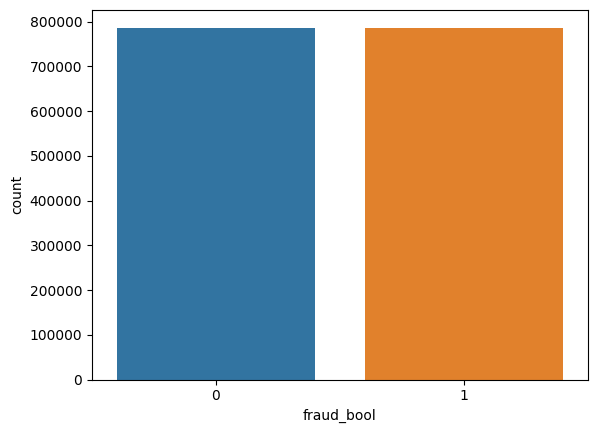

In [ ]:
# Plot a bar chart of the class distribution
sns.countplot(x=y_train_ros)
plt.show()

### Model Evaluation

In [ ]:

print(f"The shape of the X_train  data frame after spliting {X_train.shape}")
print(f"The shape of the y_train  data frame after spliting {y_train.shape}\n")

print(f"The shape of the X_test   data frame after spliting {X_test.shape}")
print(f"The shape of the y_test   data frame after spliting {y_test.shape}\n")


print(f"The shape of the X_train  data frame after resampling  {X_train_ros.shape}")
print(f"The shape of the X_train  data frame after resampling {y_train_ros.shape}\n")


The shape of the X_train  data frame after spliting (794989, 50)
The shape of the y_train  data frame after spliting (794989,)

The shape of the X_test   data frame after spliting (205011, 50)
The shape of the y_test   data frame after spliting (205011,)

The shape of the X_train  data frame after resampling  (1573676, 50)
The shape of the X_train  data frame after resampling (1573676,)




 Results for Logistic regression 



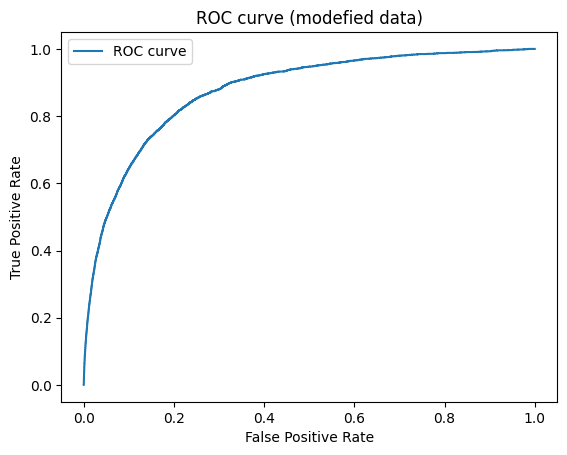

AUC: 0.8779059017991465
TPR:  49.69% 
FPR:  4.9799999999999995% 
Threshold:  0.76
Predictive Equality:  89.5%


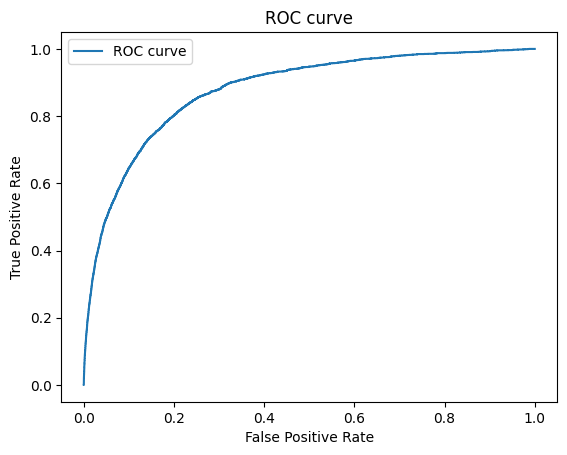

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



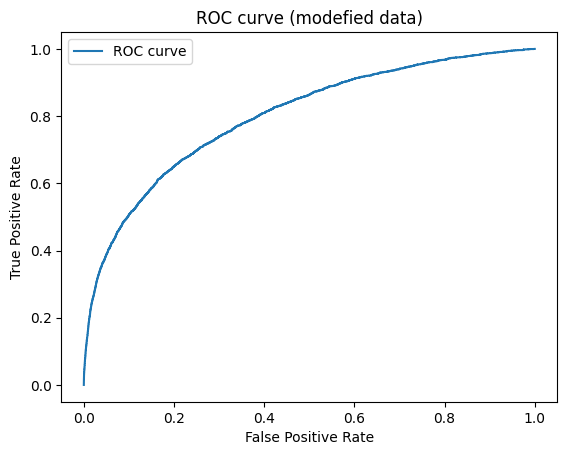

AUC: 0.7994155044923994
TPR:  38.78% 
FPR:  5.0% 
Threshold:  0.99
Predictive Equality:  86.59%


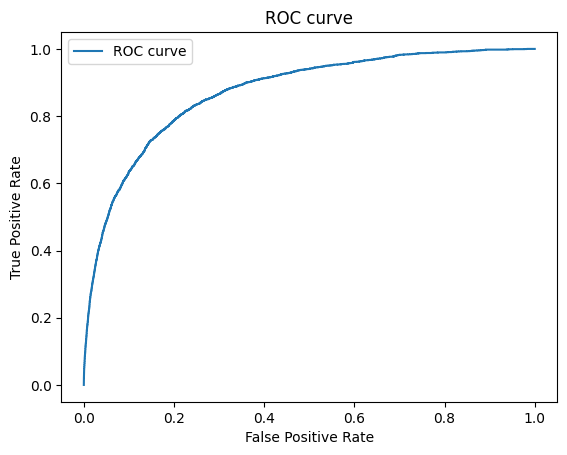

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



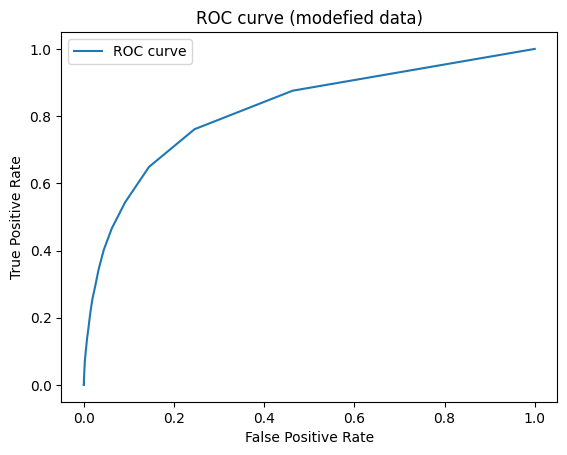

AUC: 0.8183182422700261
TPR:  40.17% 
FPR:  4.42% 
Threshold:  0.06
Predictive Equality:  37.980000000000004%


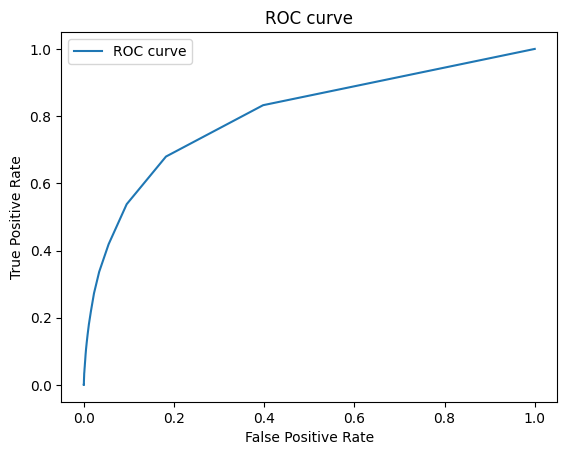

AUC: 0.8022422113812891
TPR:  33.67% 
FPR:  3.4099999999999997% 
Threshold:  0.05
Predictive Equality:  35.199999999999996%

 Results for DecisionTree classifier



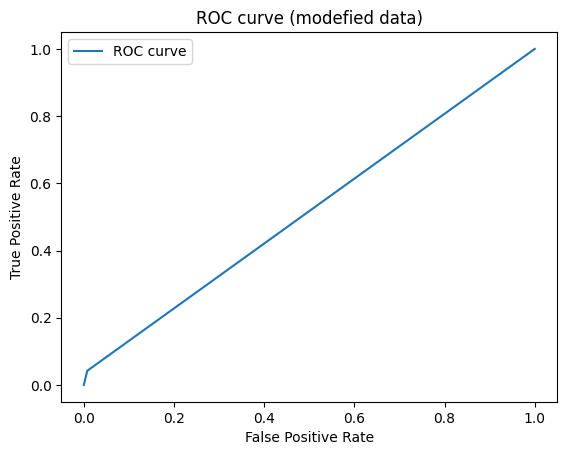

AUC: 0.5172220641768671
TPR:  4.2% 
FPR:  0.76% 
Threshold:  1.0
Predictive Equality:  50.64999999999999%


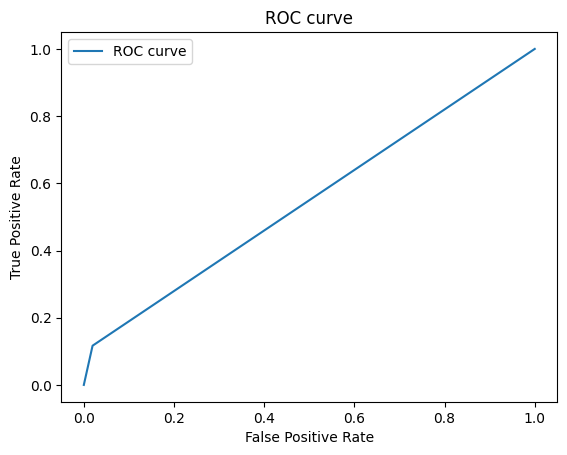

AUC: 0.5486698639757508
TPR:  11.67% 
FPR:  1.94% 
Threshold:  1.0
Predictive Equality:  41.980000000000004%

 Results for naive bayes classifier 



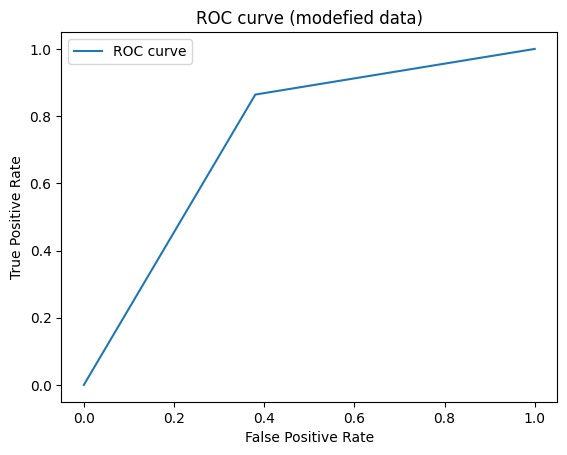

AUC: 0.7419139067047986
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  52.82%


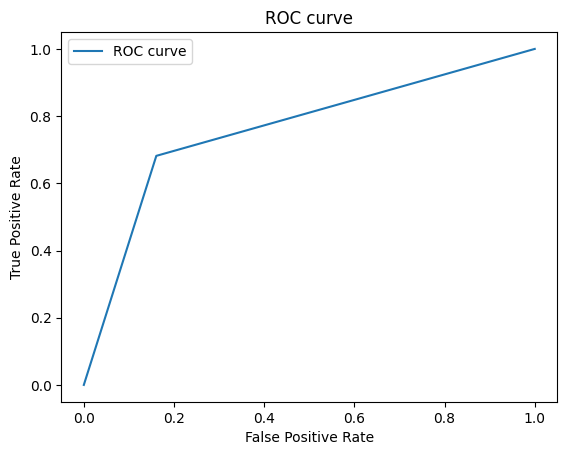

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 19s 10ms/step - loss: 1.0700 - fn: 1756.0000 - fp: 177174.0000 - tn: 530165.0000 - tp: 6395.0000 - precision: 0.0348 - recall: 0.7846 - f1: 0.0700 - val_loss: 0.6716 - val_fn: 0.0000e+00 - val_fp: 25904.0000 - val_tn: 53595.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 14s 10ms/step - loss: 1.0014 - fn: 1684.0000 - fp: 149207.0000 - tn: 558132.0000 - tp: 6467.0000 - precision: 0.0415 - recall: 0.7934 - f1: 0.0797 - val_loss: 0.5778 - val_fn: 0.0000e+00 - val_fp: 21716.0000 - val_tn: 57783.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - lo

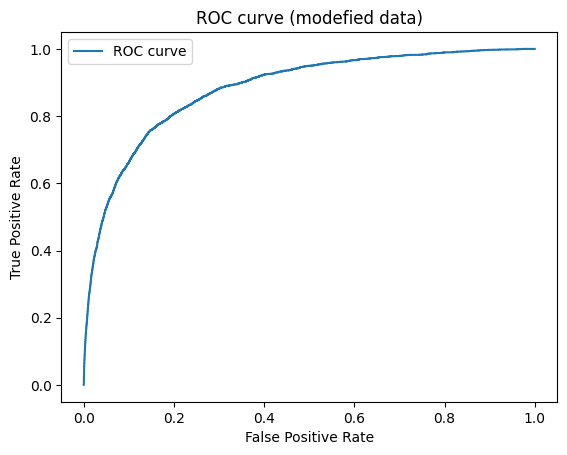

AUC: 0.8821995446017837
TPR:  52.78% 
FPR:  4.9799999999999995% 
Threshold:  0.77
Predictive Equality:  81.87%
6407/6407 [==============================] - 14s 2ms/step


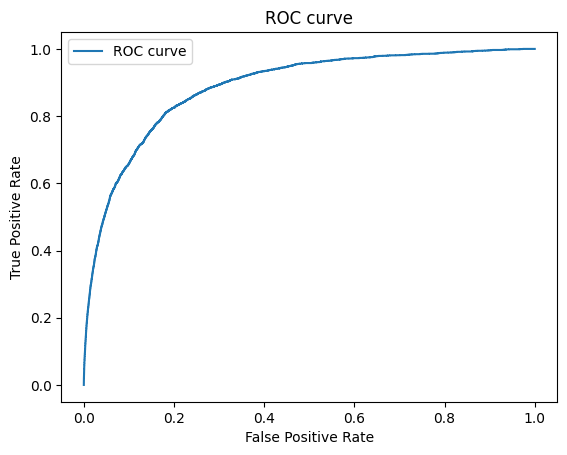

AUC: 0.8875212192749593
TPR:  52.080000000000005% 
FPR:  5.0% 
Threshold:  0.94
Predictive Equality:  94.19%


In [ ]:
data_comparison (X_train_ros, X_test_enn, y_train_ros, y_test_enn, scaling_type='standardscaler')

##SMOTENC

In [ ]:
import pandas as pd
unbalanced = pd.read_csv('/content/Base.csv')

test_df_1 = unbalanced[unbalanced['month']>=6].copy()
train_df_1_balanced = unbalanced[unbalanced['month']<6].copy()

In [ ]:

# Load Base.csv
unbalanced= pd.read_csv('/content/Base.csv')
# Remove "device_fraud_count", it's 0 for all entries
print(unbalanced['device_fraud_count'].value_counts()) # It's 0 for all rows
unbalanced = unbalanced.drop(['device_fraud_count'], axis=1, errors='ignore')

0    1000000
Name: device_fraud_count, dtype: int64


In [ ]:

# Split data into features and target
X = unbalanced.drop(['fraud_bool'], axis=1)
y = unbalanced['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train_1_balanced = X[X['month']<6]
X_test_1_b = X[X['month']>=6]
y_train_1_balanced = y[X['month']<6]
y_test_1_b = y[X['month']>=6]

X_train_1_balanced.drop('month', axis=1, inplace=True)
X_test_1_b.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-45-839d9d2e192d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_1_balanced.drop('month', axis=1, inplace=True)
<ipython-input-45-839d9d2e192d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_1_b.drop('month', axis=1, inplace=True)


In [ ]:

from imblearn.over_sampling import SMOTENC
categorical_features = X_train_1_balanced.select_dtypes(include='object').columns.tolist()

categorical_indices = [X_train_1_balanced.columns.get_loc(col) for col in categorical_features]
# categorical_indices = np.array(categorical_indices)
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_1_balanced, y_train_1_balanced = smotenc.fit_resample(X_train_1_balanced, y_train_1_balanced)

In [ ]:

X_train_1_balanced.head()

income  name_email_similarity  prev_address_months_count  \
0     0.8               0.153411                         -1   
1     0.8               0.442439                         -1   
2     0.9               0.328328                         -1   
3     0.7               0.033834                         -1   
4     0.9               0.150643                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                           105            30            0.003467   
1                           107            40            0.021131   
2                            79            70            0.009110   
3                            28            30            0.004707   
4                           164            40            0.012221   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
0               -0.906840           AC          1779   1147.615990  ...   
1               -1.553115           AC          1195  10788.642570  ...   
2               -0.801146           AC           845   8504.451753  ...   
3               -1.171706           AB          1697   6011.217859  ...   
4               -0.227823           AB          1474   8378.324044  ...   

   phone_mobile_valid  bank_months_count  has_other_cards  \
0                   1                 -1                0   
1                   1                 -1                0   
2                   1                 -1                0   
3                   1                 28                0   
4                   1                  5                0   

   proposed_credit_limit foreign_request    source  session_length_in_minutes  \
0                  200.0               0  INTERNET                   3.911696   
1                  200.0               0  INTERNET                  23.696737   
2                 2000.0               0  INTERNET                   2.803927   
3                 1000.0               0  INTERNET                   5.262441   
4                 1500.0               0  INTERNET                   5.728984   

  device_os  keep_alive_session  device_distinct_emails_8w  
0     linux                   0                          1  
1     other                   0                          2  
2   windows                   0                          1  
3   windows                   1                          2  
4   windows                   0                          1  

[5 rows x 29 columns]

In [ ]:

s = (X_train_1_balanced.dtypes == 'object') # list of column-names and wether they contain categorical features
object_cols = list(s[s].index) # All the columns containing these features
print(X[object_cols])

       payment_type employment_status housing_status    source  device_os
0                AA                CA             BA  INTERNET    windows
1                AB                CA             BA  INTERNET    windows
2                AC                CB             BA  INTERNET      other
3                AB                CA             BA  INTERNET      linux
4                AB                CA             BA  INTERNET  macintosh
...             ...               ...            ...       ...        ...
999995           AB                CA             BC  INTERNET      linux
999996           AC                CC             BC  INTERNET    windows
999997           AA                CF             BC  INTERNET      other
999998           AA                CA             BA  INTERNET    windows
999999           AA                CA             BE  INTERNET      linux

[1000000 rows x 5 columns]


In [ ]:

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train_1_balanced[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test_1_b[object_cols]))

# Set the index of the transformed data to match the original data
ohe_cols_train.index = X_train_1_balanced.index
ohe_cols_test.index = X_test_1_b.index

# Remove the object columns from the training and test data
num_X_train = X_train_1_balanced.drop(object_cols, axis=1)
num_X_test = X_test_1_b.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
X_train_1_balanced = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test_1_b = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
X_train_1_balanced.columns = X_train_1_balanced.columns.astype(str)
X_test_1_b.columns = X_test_1_b.columns.astype(str)

# See that it replaced all categorical values
X_train_1_balanced.head(1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


income  name_email_similarity  prev_address_months_count  \
0     0.8               0.153411                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                           105            30            0.003467   

   intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...   16  \
0                -0.90684          1779   1147.61599   3076.384487  ...  0.0   

    17   18   19   20   21   22   23   24   25  
0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  

[1 rows x 50 columns]


 Results for Logistic regression 



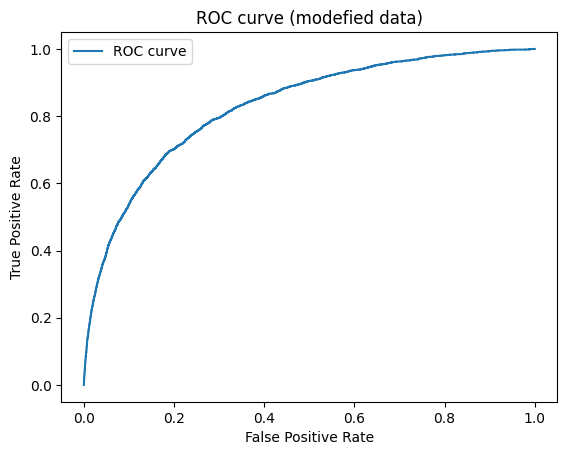

AUC: 0.8288094907010618
TPR:  39.23% 
FPR:  4.99% 
Threshold:  0.63
Predictive Equality:  81.02000000000001%


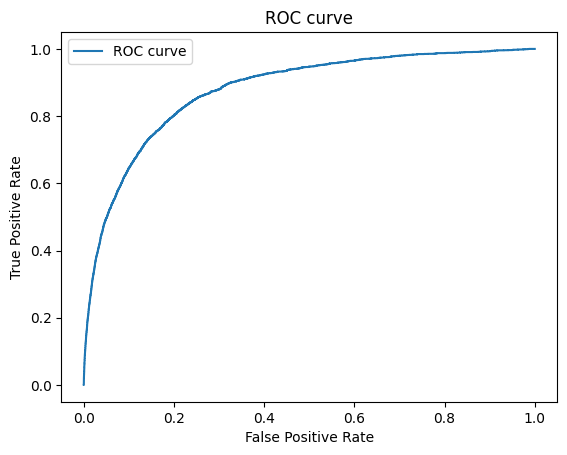

AUC: 0.8779388959897662
TPR:  49.69% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  89.52%

 Results for XGBClassifier 



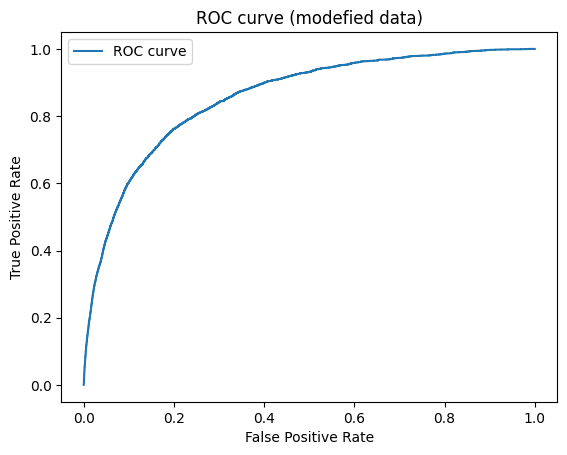

AUC: 0.8565725919792309
TPR:  43.5% 
FPR:  4.97% 
Threshold:  0.91
Predictive Equality:  75.11%


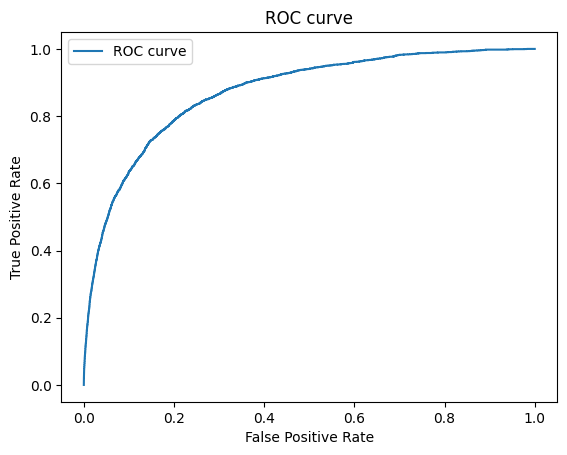

AUC: 0.8718540084797579
TPR:  48.78% 
FPR:  5.0% 
Threshold:  0.71
Predictive Equality:  74.38%

 Results for RandomForestClassifier 



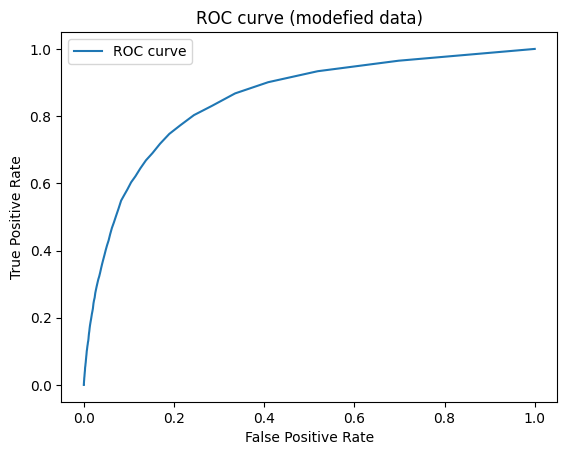

AUC: 0.8496170078221399
TPR:  40.17% 
FPR:  4.859999999999999% 
Threshold:  0.25
Predictive Equality:  61.86000000000001%


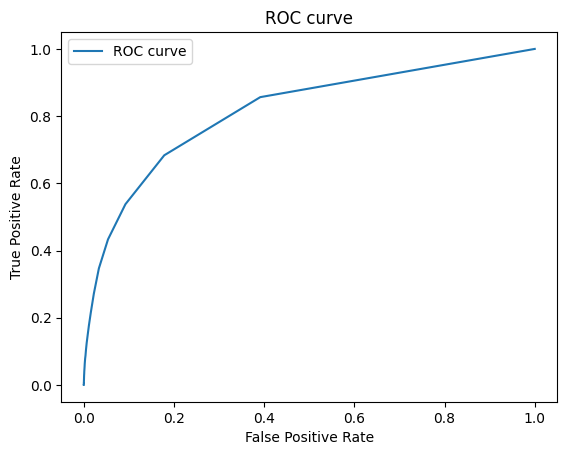

AUC: 0.815350647402437
TPR:  34.68% 
FPR:  3.34% 
Threshold:  0.05
Predictive Equality:  35.77%

 Results for DecisionTree classifier



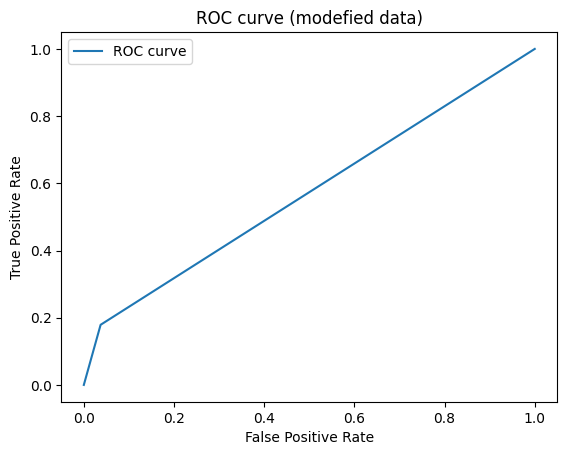

AUC: 0.5708628208096715
TPR:  17.89% 
FPR:  3.7199999999999998% 
Threshold:  1.0
Predictive Equality:  64.13%


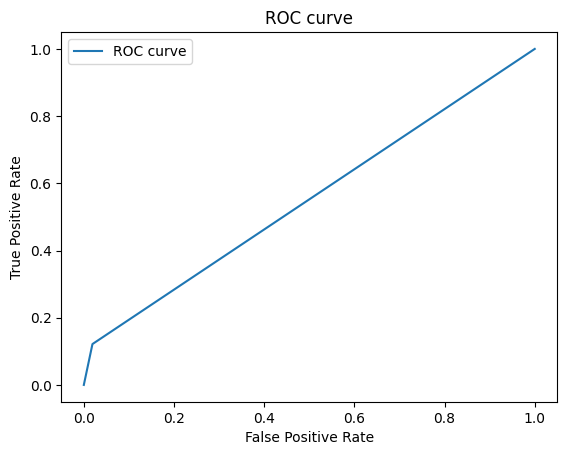

AUC: 0.5512307367705217
TPR:  12.16% 
FPR:  1.92% 
Threshold:  1.0
Predictive Equality:  42.33%

 Results for naive bayes classifier 



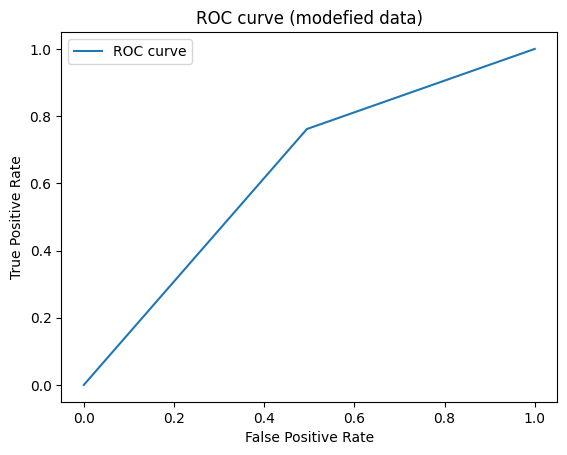

AUC: 0.6334210241244811
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  78.77%


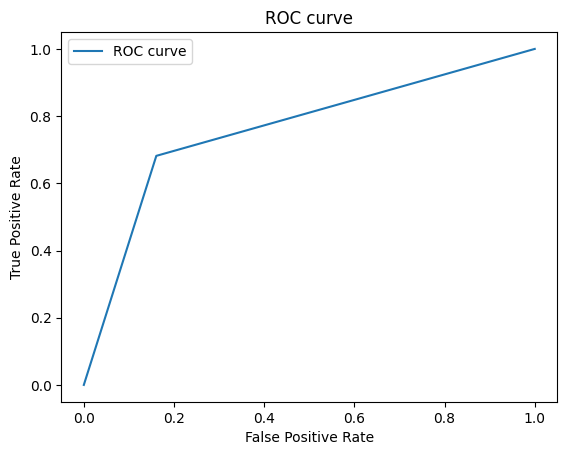

AUC: 0.7604740439735584
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  31.069999999999997%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 17s 10ms/step - loss: 1.0639 - fn: 1754.0000 - fp: 177210.0000 - tn: 530129.0000 - tp: 6397.0000 - precision: 0.0348 - recall: 0.7848 - f1: 0.0716 - val_loss: 0.5046 - val_fn: 0.0000e+00 - val_fp: 18747.0000 - val_tn: 60752.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9940 - fn: 1684.0000 - fp: 149306.0000 - tn: 558033.0000 - tp: 6467.0000 - precision: 0.0415 - recall: 0.7934 - f1: 0.0796 - val_loss: 0.6324 - val_fn: 0.0000e+00 - val_fp: 25270.0000 - val_tn: 54229.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - los

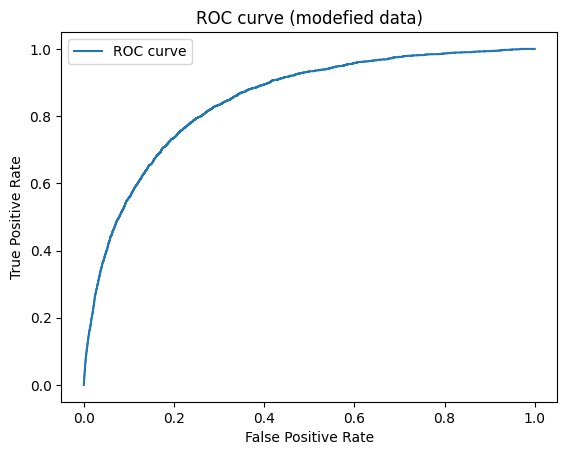

AUC: 0.8476587353965854
TPR:  39.82% 
FPR:  5.0% 
Threshold:  0.44
Predictive Equality:  73.47%
6407/6407 [==============================] - 14s 2ms/step


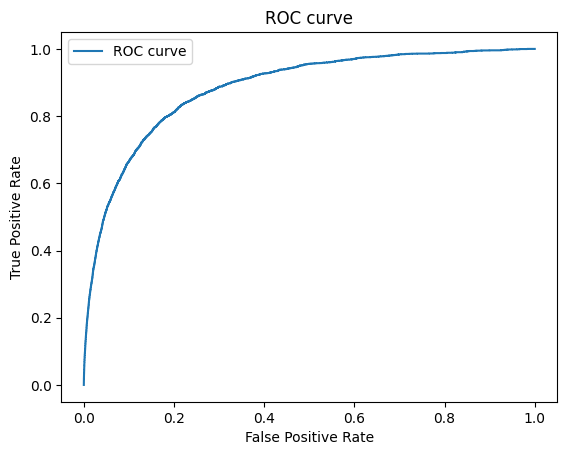

AUC: 0.8841815347175054
TPR:  51.980000000000004% 
FPR:  4.9799999999999995% 
Threshold:  0.9
Predictive Equality:  98.5%


In [ ]:

data_comparison(X_train_1_balanced, X_test_1_b, y_train_1_balanced, y_test_1_b, scaling_type = 'standardscaler')

### Results After Using SMOTENC

### 1. Logistic Regression:

- AUC (Area Under the Curve): 0.8288
- True Positive Rate (TPR): 39.23%
- False Positive Rate (FPR): 4.99%
- Threshold: 0.63
- Predictive Equality: 81.02%

### 2. XGBClassifier:

- AUC: 0.8566
- TPR: 43.5%
- FPR: 4.97%
- Threshold: 0.91
- Predictive Equality: 75.11%

### 3. RandomForestClassifier:

- AUC: 0.8496
- TPR: 40.17%
- FPR: 4.86%
- Threshold: 0.25
- Predictive Equality: 61.86%

### 4. DecisionTree Classifier:

- AUC: 0.5709
- TPR: 17.89%
- FPR: 3.72%
- Threshold: 1.0
- Predictive Equality: 64.13%

### 5. Naive Bayes Classifier:

- AUC: 0.6334
- TPR: 0.0%
- FPR: 0.0%
- Threshold: 2
- Predictive Equality: 78.77%

### 6. Neural Network Model:

- AUC: 0.8477
- TPR: 39.82%
- FPR: 5.0%
- Threshold: 0.44
- Predictive Equality: 73.47%

### 7. Conclusion:
- Best Performing Models: The XGBClassifier and RandomForestClassifier achieved the highest AUC scores of approximately 0.8566 and 0.8496, respectively. These models outperformed the other classifiers in terms of overall classification performance.

-  The Logistic Regression model achieved the best predictive equality with a score of approximately 81.02%.

- Overall, the XGBClassifier and RandomForestClassifier are the top-performing models with reasonably high AUC scores. The Logistic Regression model offers better predictive equality but with a slightly lower AUC compared to XGBClassifier and RandomForestClassifier.

##Applying the best approach on all the five dataset

In [ ]:
def base_processing (df):
# Split data into features and target
  X = df.drop(['fraud_bool'], axis=1)
  y = df['fraud_bool']

# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
  X_train = X[X['month']<6].copy()
  X_test = X[X['month']>=6].copy()
  y_train = y[X['month']<6].copy()
  y_test = y[X['month']>=6].copy()

  X_train.drop('month', axis=1, inplace=True)
  X_test.drop('month', axis=1, inplace=True)

  s = (X_train.dtypes == 'object') # list of column-names and wether they contain categorical features
  object_cols = list(s[s].index) # All the columns containing these features

  ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # ignore any features in the test set that were not present in the training set

# Get one-hot-encoded columns
  ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
  ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

# Set the index of the transformed data to match the original data
  ohe_cols_train.index = X_train.index
  ohe_cols_test.index = X_test.index

# Remove the object columns from the training and test data
  num_X_train = X_train.drop(object_cols, axis=1)
  num_X_test = X_test.drop(object_cols, axis=1)

# Concatenate the numerical data with the transformed categorical data
  X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
  X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

# Newer versions of sklearn require the column names to be strings
  X_train.columns = X_train.columns.astype(str)
  X_test.columns = X_test.columns.astype(str)

# Scale data to improve performance on some models
  # scaler = StandardScaler()

  # X_train = scaler.fit_transform(X_train)
  # X_test = scaler.transform(X_test)

  return X_train,X_test,y_train,y_test

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB


def variante_data_evaluation (X_train_new, X_test_new, y_train_new, y_test_new):

  df_test = X_test_new
  labels = y_test_new
  df_groups = (df_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

  scaler = StandardScaler()
  X_train_new = scaler.fit_transform(X_train_new)
  X_test_new = scaler.transform(X_test_new)

#modeling

################### Logistic regression #############
  lr_model_new = LogisticRegression(
      class_weight='balanced'
  )
  lr_model_new.fit(X_train_new, y_train_new)
  predictions = lr_model_new.predict_proba(X_test_new)[:,1]
  print ("\n Results for Logistic regression \n")
  evaluate_modified(predictions,y_test_new = y_test_new, df_groups = df_groups)
############# XGBClassifier ############
# New model
  model_xgb_new = xgb.XGBClassifier(
      tree_method='gpu_hist', gpu_id=0,
      scale_pos_weight=89.67005
  )
  model_xgb_new.fit(X_train_new, y_train_new)
  predictions = model_xgb_new.predict_proba(X_test_new)[:,1]
  print ("\n Results for XGBClassifier \n")
  evaluate_modified(predictions , y_test_new = y_test_new, df_groups = df_groups)

################ RandomForestClassifier #################
## New model
  rf_model = RandomForestClassifier(class_weight='balanced')
  rf_model.fit(X_train_new, y_train_new)
  predictions = rf_model.predict_proba(X_test_new)[:,1]
  print ("\n Results for RandomForestClassifier \n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)

#################### DecisionTree #############

#Training on the new processed data
  dt_model = DecisionTreeClassifier() # create a decision tree classifier
  dt_model.fit(X_train_new, y_train_new) # train the model on the training data
  predictions = dt_model.predict_proba(X_test_new)[:, 1] # get the probability of fraud for the test data
  print ("\n Results for DecisionTree classifier\n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)  # evaluate the model using the evaluate function


#################### naive bayes classifier #############
#Training on the new processed data
  naive_bayes_classifier = GaussianNB()
  naive_bayes_classifier.fit(X_train_new, y_train_new)
  predictions = naive_bayes_classifier.predict(X_test_new)
  print ("\n Results for naive bayes classifier \n")
  evaluate_modified(predictions, y_test_new = y_test_new, df_groups = df_groups)

#################### NN model #################
  model_modefied = model_building (X_train_new)
  hist = compile_and_train_new(model_modefied,X_train_new,y_train_new)
  print ("\nmodel  finished training \n")
  ## New model
  print ("\n Results for Neural Nework model \n")
  score_keras_model_new(model_modefied,X_test_new,y_test_new,df_groups)


###Variant I

In [ ]:
# Load Base.csv
df_VariantI= pd.read_csv('/content/Variant I.csv')
# Remove "device_fraud_count", it's 0 for all entries
df_VariantI.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.6               0.252681                         -1   
1           0     0.9               0.185206                         -1   
2           0     0.1               0.505509                         -1   
3           0     0.2               0.612030                         -1   
4           0     0.4               0.592596                        319   

   current_address_months_count  customer_age  days_since_request  \
0                           188            20            0.021614   
1                            51            30            0.001696   
2                           187            20            0.011880   
3                            55            20            0.001582   
4                            68            30            0.011189   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -0.266603           AC          2596  ...                0   
1               -1.191015           AD           898  ...                0   
2               -1.252679           AB          2851  ...                0   
3               -3.001035           AA          4035  ...                0   
4               -0.729188           AB          1611  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1000.0                1  INTERNET   
1                 1500.0                0  INTERNET   
2                  500.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                1  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                   7.634858     linux                   0   
1                   5.408299     other                   0   
2                   9.401087     linux                   1   
3                   4.165579     linux                   0   
4                   8.971943     linux                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      5  
1                          1                  0      4  
2                          1                  0      5  
3                          1                  0      1  
4                          1                  0      5  

[5 rows x 32 columns]

In [ ]:
x_train_variantI,x_test_variantI,y_train_variantI,y_test_variantI = base_processing (df_VariantI)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_train_variantI.value_counts()

0    786839
1      8151
Name: fraud_bool, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )
# Apply ENN cleaning
x_train_variantI, y_train_variantI = randomover.fit_resample(x_train_variantI, y_train_variantI)

In [ ]:
y_train_variantI.value_counts()

0    786839
1    786839
Name: fraud_bool, dtype: int64


 Results for Logistic regression 



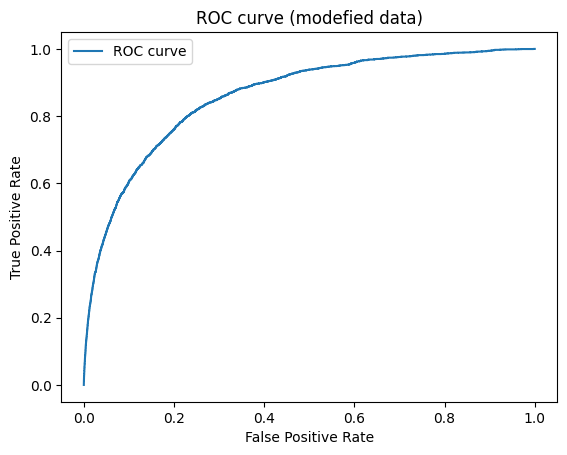

AUC: 0.8611748001880221
TPR:  45.59% 
FPR:  4.99% 
Threshold:  0.76
Predictive Equality:  97.72999999999999%

 Results for XGBClassifier 



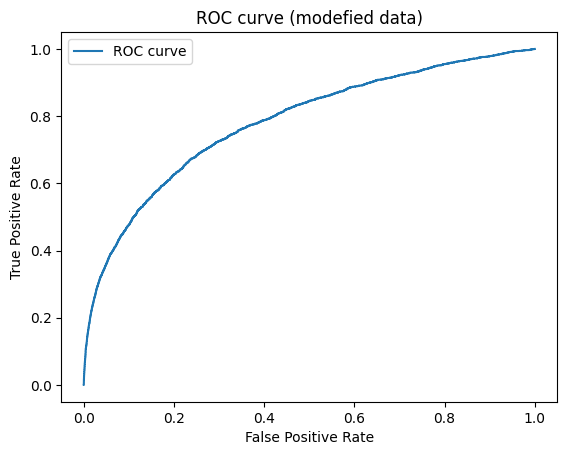

AUC: 0.781462466259775
TPR:  36.0% 
FPR:  5.0% 
Threshold:  0.99
Predictive Equality:  90.02%

 Results for RandomForestClassifier 



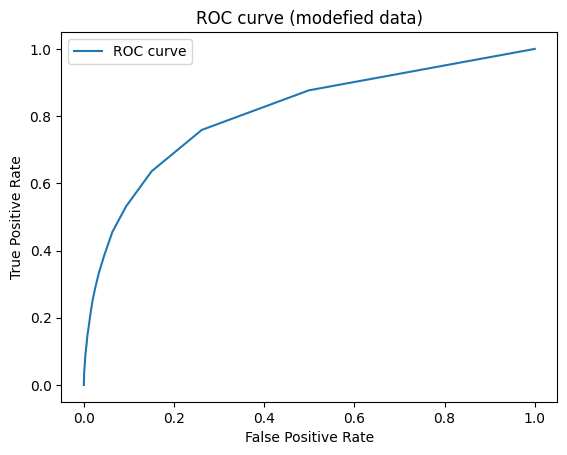

AUC: 0.8088635121804484
TPR:  38.46% 
FPR:  4.51% 
Threshold:  0.06
Predictive Equality:  74.56%

 Results for DecisionTree classifier



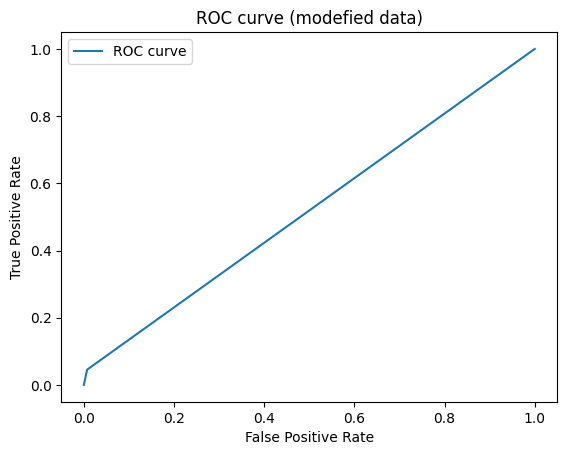

AUC: 0.5190632554673916
TPR:  4.55% 
FPR:  0.74% 
Threshold:  1.0
Predictive Equality:  67.71000000000001%

 Results for naive bayes classifier 



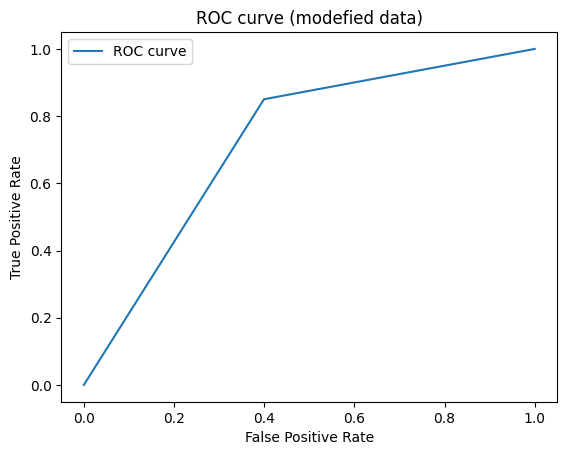

AUC: 0.7253289025162717
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  63.41%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 18s 10ms/step - loss: 1.0782 - fn: 1799.0000 - fp: 174430.0000 - tn: 532909.0000 - tp: 6352.0000 - precision: 0.0351 - recall: 0.7793 - f1: 0.0706 - val_loss: 0.5740 - val_fn: 0.0000e+00 - val_fp: 21330.0000 - val_tn: 58169.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 14s 10ms/step - loss: 1.0047 - fn: 1630.0000 - fp: 153140.0000 - tn: 554199.0000 - tp: 6521.0000 - precision: 0.0408 - recall: 0.8000 - f1: 0.0787 - val_loss: 0.4280 - val_fn: 0.0000e+00 - val_fp: 15691.0000 - val_tn: 63808.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9915 - 

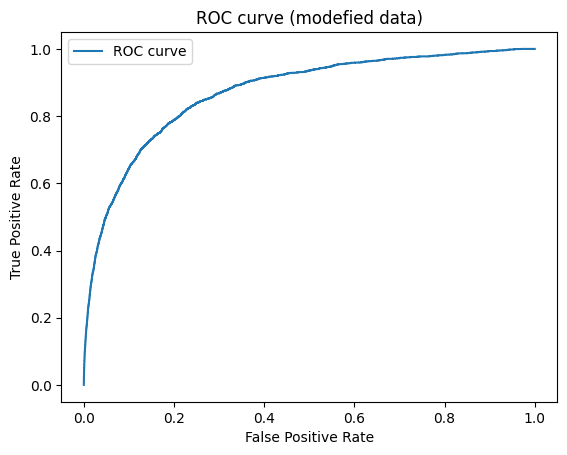

AUC: 0.8717550188788762
TPR:  50.449999999999996% 
FPR:  4.99% 
Threshold:  0.74
Predictive Equality:  96.13000000000001%


In [ ]:
variante_data_evaluation (x_train_variantI, x_test_variantI, y_train_variantI, y_test_variantI)

###Variant II

In [ ]:
# Load Base.csv
df_VariantII= pd.read_csv('/content/Variant II.csv')
# Remove "device_fraud_count", it's 0 for all entries
df_VariantII.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.7               0.123474                         -1   
1           0     0.8               0.166159                         -1   
2           0     0.6               0.328567                         -1   
3           0     0.7               0.503447                         -1   
4           0     0.4               0.339627                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                           149            30            0.027608   
1                            97            50            0.015207   
2                           165            50            0.039634   
3                           201            50            0.011845   
4                            61            50            0.001281   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               21.599012           AA          1034  ...                0   
1               -1.136921           AB          1371  ...                0   
2               24.077611           AA          1451  ...                1   
3               -0.766643           AC          1034  ...                1   
4               -0.938068           AB          1206  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  200.0                0  INTERNET   
1                  200.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  14.851445     other                   0   
1                   9.873092   windows                   1   
2                   9.318093     linux                   0   
3                  59.810853   windows                   1   
4                  19.851689   windows                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      4  
1                          1                  0      5  
2                          1                  0      0  
3                          1                  0      1  
4                          1                  0      2  

[5 rows x 32 columns]

In [ ]:
x_train_variantII,x_test_variantII,y_train_variantII,y_test_variantII = base_processing (df_VariantII)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_train_variantII.value_counts()

0    786839
1      8151
Name: fraud_bool, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )

x_train_variantII, y_train_variantII = randomover.fit_resample(x_train_variantII, y_train_variantII)

In [ ]:
y_train_variantII.value_counts()

0    786839
1    786839
Name: fraud_bool, dtype: int64


 Results for Logistic regression 



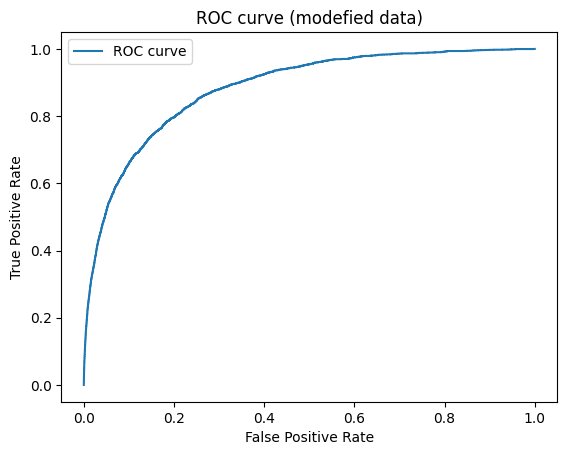

AUC: 0.8827614670695858
TPR:  51.839999999999996% 
FPR:  5.0% 
Threshold:  0.78
Predictive Equality:  82.11%

 Results for XGBClassifier 



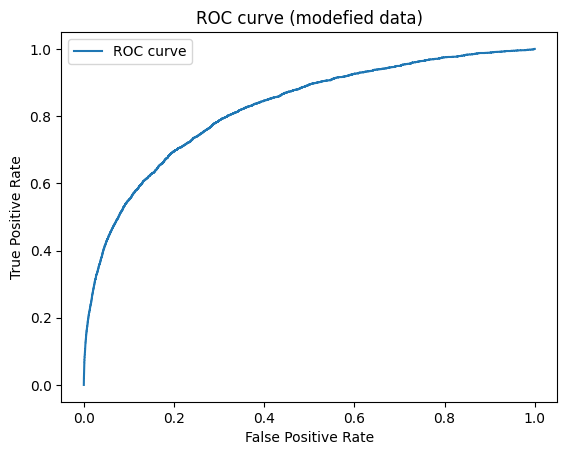

AUC: 0.8234125000599929
TPR:  42.63% 
FPR:  5.0% 
Threshold:  0.99
Predictive Equality:  80.78999999999999%

 Results for RandomForestClassifier 



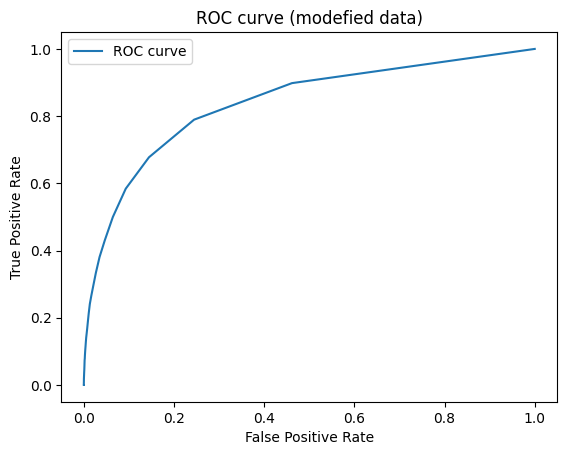

AUC: 0.8373296574086604
TPR:  43.05% 
FPR:  4.65% 
Threshold:  0.06
Predictive Equality:  41.19%

 Results for DecisionTree classifier



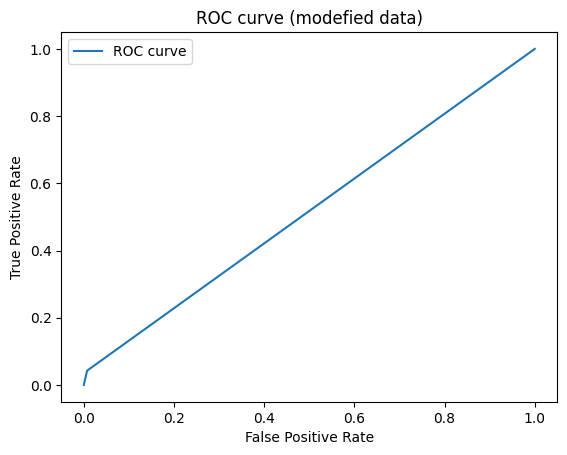

AUC: 0.5175689313144947
TPR:  4.24% 
FPR:  0.73% 
Threshold:  1.0
Predictive Equality:  49.61%

 Results for naive bayes classifier 



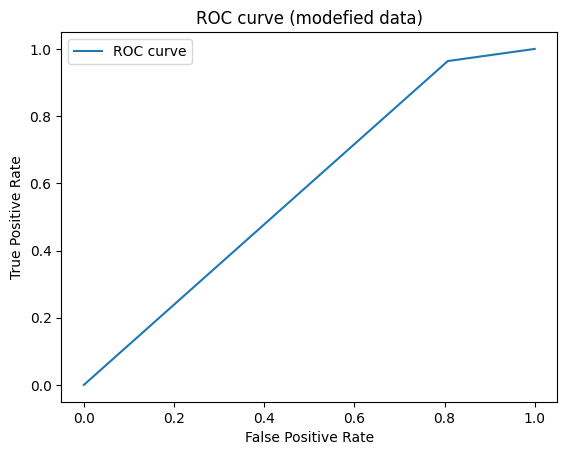

AUC: 0.578381247080548
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  89.72%

model one finished training and model 2 started training 

Epoch 1/100
1398/1398 [==============================] - 18s 10ms/step - loss: 0.9518 - fn: 1581.0000 - fp: 144491.0000 - tn: 562848.0000 - tp: 6570.0000 - precision: 0.0435 - recall: 0.8060 - f1: 0.0836 - val_loss: 0.6174 - val_fn: 0.0000e+00 - val_fp: 25865.0000 - val_tn: 53634.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9451 - fn: 1580.0000 - fp: 144526.0000 - tn: 562813.0000 - tp: 6571.0000 - precision: 0.0435 - recall: 0.8062 - f1: 0.0838 - val_loss: 0.5586 - val_fn: 0.0000e+00 - val_fp: 16025.0000 - val_tn: 63474.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9494 - fn

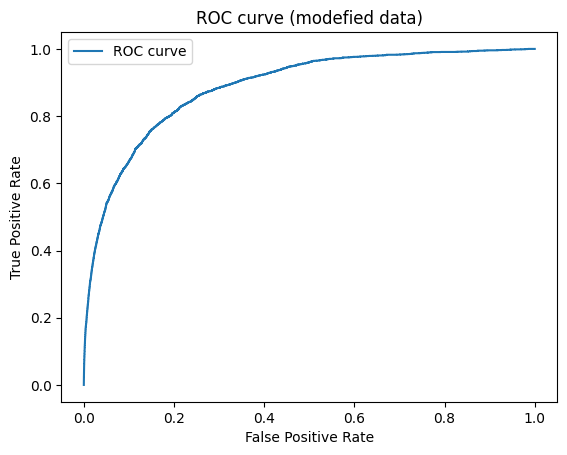

AUC: 0.8870686140364973
TPR:  53.790000000000006% 
FPR:  4.99% 
Threshold:  0.77
Predictive Equality:  62.09%


In [ ]:
variante_data_evaluation (x_train_variantII, x_test_variantII, y_train_variantII, y_test_variantII)

###Vaiant III

In [ ]:
# Load Base.csv
df_VariantIII= pd.read_csv('/content/Variant III.csv')
# Remove "device_fraud_count", it's 0 for all entries
df_VariantIII.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.2               0.369510                        326   
1           0     0.6               0.858929                         -1   
2           0     0.9               0.166457                         -1   
3           0     0.8               0.250290                         23   
4           0     0.1               0.619087                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            20            60            0.022212   
1                           154            50            0.038221   
2                            41            50            0.002588   
3                             9            50            0.004026   
4                            30            30            0.011687   

   intended_balcon_amount payment_type  zip_count_4w  ...  foreign_request  \
0               -0.758101           AB           647  ...                0   
1               -0.781645           AB          1238  ...                0   
2               17.710636           AA           815  ...                0   
3               18.224113           AA          1204  ...                0   
4               -1.434154           AB          1182  ...                0   

     source  session_length_in_minutes  device_os  keep_alive_session  \
0  INTERNET                  19.450933      other                   1   
1  INTERNET                   3.641099    windows                   1   
2  INTERNET                   3.850864  macintosh                   0   
3  INTERNET                   5.182197    windows                   1   
4  INTERNET                   4.346861    windows                   1   

  device_distinct_emails_8w  device_fraud_count  month        x1        x2  
0                         2                   0      3 -0.282223 -0.137122  
1                         1                   0      5 -0.145247  1.614553  
2                         1                   0      4 -0.029179  1.089166  
3                         1                   0      2  2.178365  1.301696  
4                         1                   0      7  1.472099  0.367675  

[5 rows x 34 columns]

In [ ]:
x_train_variantIII,x_test_variantIII,y_train_variantIII,y_test_variantIII = base_processing (df_VariantIII)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_train_variantIII.value_counts()

0    749950
1      8378
Name: fraud_bool, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )

x_train_variantIII, y_train_variantIII = randomover.fit_resample(x_train_variantIII, y_train_variantIII)

In [ ]:
y_train_variantIII.value_counts()

0    749950
1    749950
Name: fraud_bool, dtype: int64


 Results for Logistic regression 



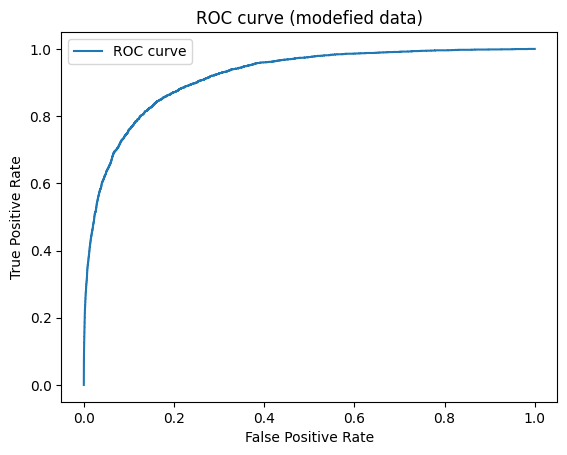

AUC: 0.9190395125243058
TPR:  63.46000000000001% 
FPR:  4.9799999999999995% 
Threshold:  0.76
Predictive Equality:  74.56%

 Results for XGBClassifier 



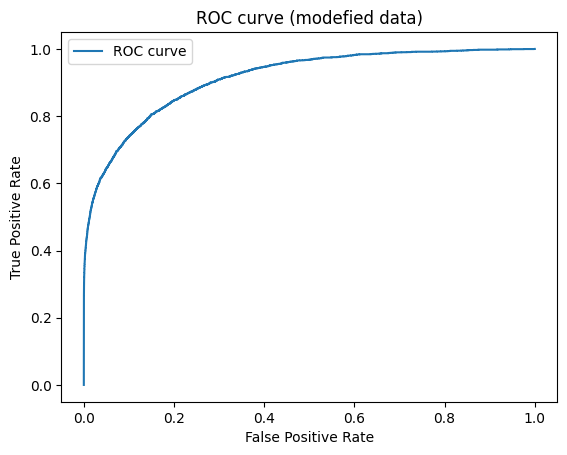

AUC: 0.9133552188278102
TPR:  64.44% 
FPR:  5.0% 
Threshold:  0.98
Predictive Equality:  57.9%

 Results for RandomForestClassifier 



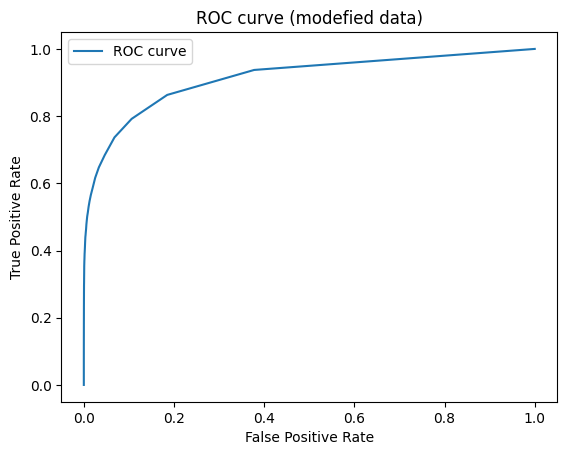

AUC: 0.913096460496752
TPR:  68.4% 
FPR:  4.64% 
Threshold:  0.05
Predictive Equality:  49.71%

 Results for DecisionTree classifier



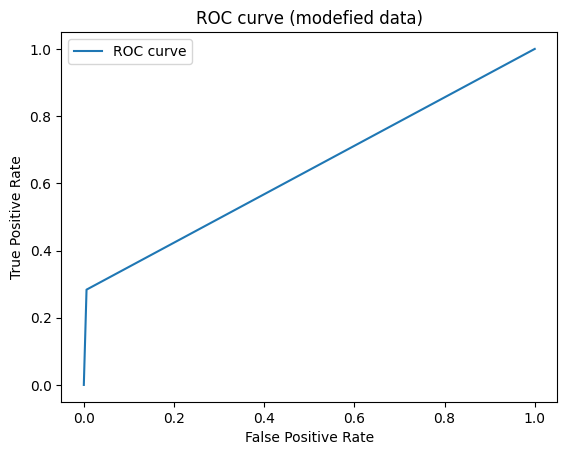

AUC: 0.6387737642381605
TPR:  28.360000000000003% 
FPR:  0.6% 
Threshold:  1.0
Predictive Equality:  52.580000000000005%

 Results for naive bayes classifier 



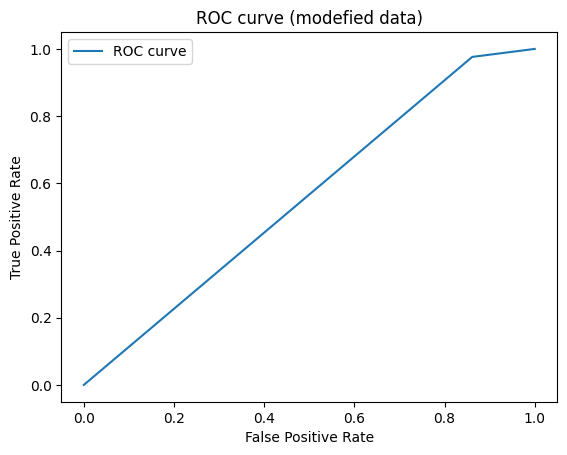

AUC: 0.5574050771419192
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  96.89%

model  finished training 


 Results for Neural Nework model 

7553/7553 [==============================] - 15s 2ms/step


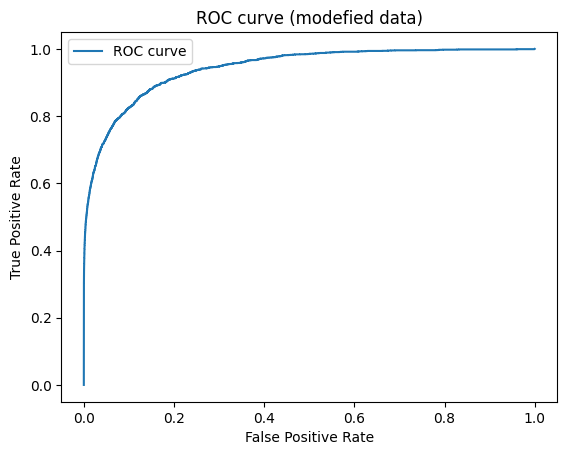

AUC: 0.9434353258144462
TPR:  73.64% 
FPR:  4.99% 
Threshold:  0.65
Predictive Equality:  35.24%


In [ ]:
variante_data_evaluation (x_train_variantIII, x_test_variantIII, y_train_variantIII, y_test_variantIII)

###Variant IV

In [ ]:
# Load Base.csv
df_VariantIV= pd.read_csv('/content/Variant IV.csv')
# Remove "device_fraud_count", it's 0 for all entries
df_VariantIV.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.8               0.854789                         -1   
1           0     0.8               0.906272                         44   
2           0     0.6               0.152537                         -1   
3           0     0.9               0.377427                         -1   
4           0     0.9               0.235135                         54   

   current_address_months_count  customer_age  days_since_request  \
0                           367            70            0.002221   
1                             0            20            8.326632   
2                            44            30            0.003582   
3                            35            50            0.015738   
4                            17            30           20.539897   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               43.264018           AA           785  ...                1   
1               -1.316227           AD          1614  ...                0   
2               15.954219           AA          1890  ...                1   
3               -1.284274           AB           905  ...                0   
4               37.741422           AA          1586  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  200.0                0  INTERNET   
1                  200.0                0  INTERNET   
2                  500.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                   7.256475     other                   0   
1                  23.099668     other                   1   
2                   4.662904     other                   0   
3                   4.164272   windows                   0   
4                   6.035516     other                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      5  
1                          1                  0      0  
2                          1                  0      4  
3                          1                  0      4  
4                          1                  0      0  

[5 rows x 32 columns]

In [ ]:
x_train_variantIV,x_test_variantIV,y_train_variantIV,y_test_variantIV = base_processing (df_VariantIV)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_train_variantIV.value_counts()

0    749950
1      8378
Name: fraud_bool, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )

x_train_variantIV, y_train_variantIV = randomover.fit_resample(x_train_variantIV, y_train_variantIV)

In [ ]:
y_train_variantIV.value_counts()

0    749950
1    749950
Name: fraud_bool, dtype: int64


 Results for Logistic regression 



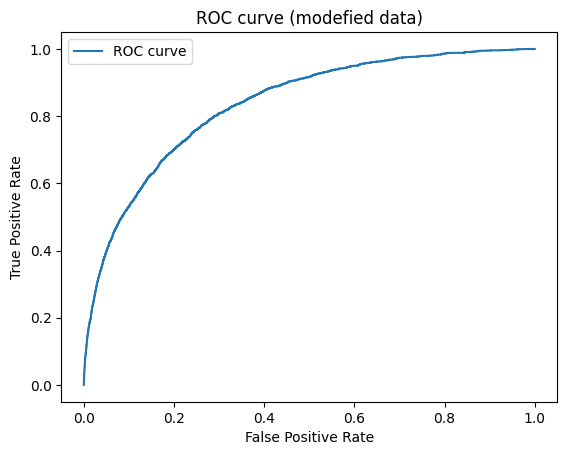

AUC: 0.8349004854286224
TPR:  39.739999999999995% 
FPR:  4.99% 
Threshold:  0.79
Predictive Equality:  81.55%

 Results for XGBClassifier 



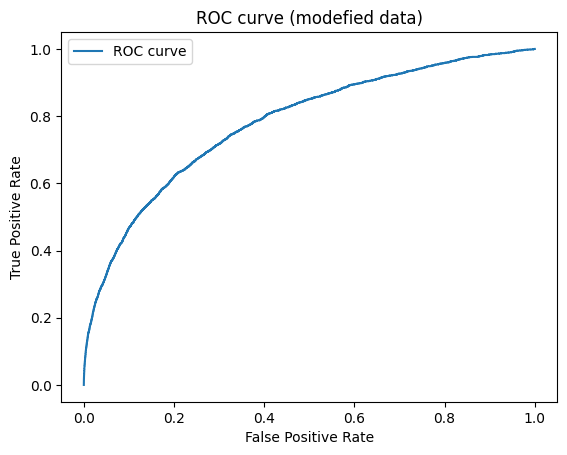

AUC: 0.7803318513833448
TPR:  32.81% 
FPR:  5.0% 
Threshold:  0.99
Predictive Equality:  78.21000000000001%

 Results for RandomForestClassifier 



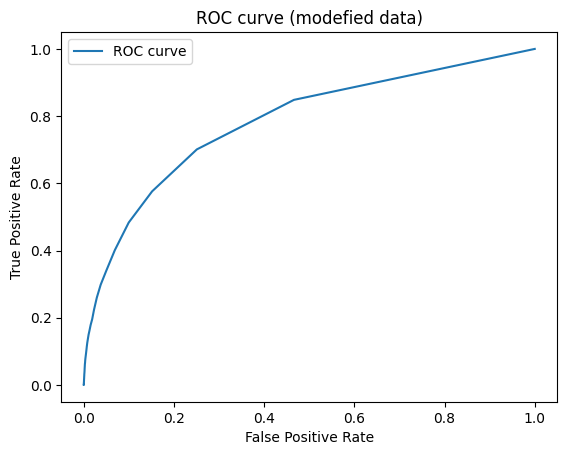

AUC: 0.7828961811194101
TPR:  34.01% 
FPR:  4.99% 
Threshold:  0.06
Predictive Equality:  41.699999999999996%

 Results for DecisionTree classifier



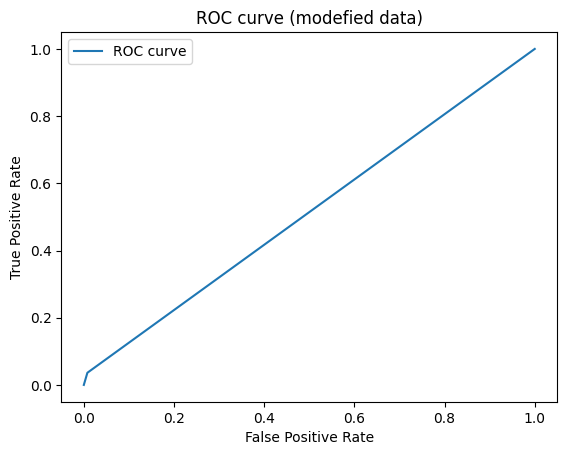

AUC: 0.514145903464789
TPR:  3.62% 
FPR:  0.79% 
Threshold:  1.0
Predictive Equality:  52.6%

 Results for naive bayes classifier 



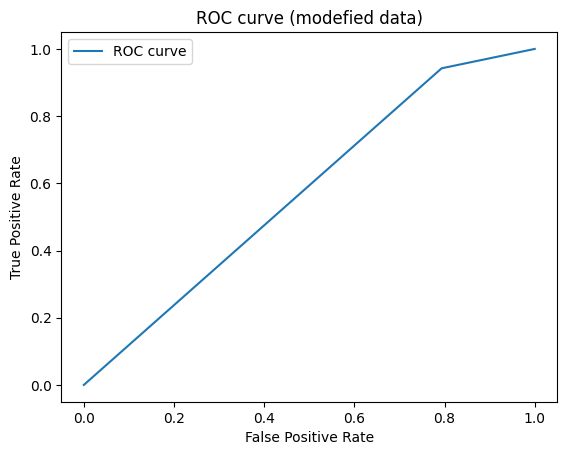

AUC: 0.5744067120228111
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  88.89%

model  finished training 


 Results for Neural Nework model 

7553/7553 [==============================] - 15s 2ms/step


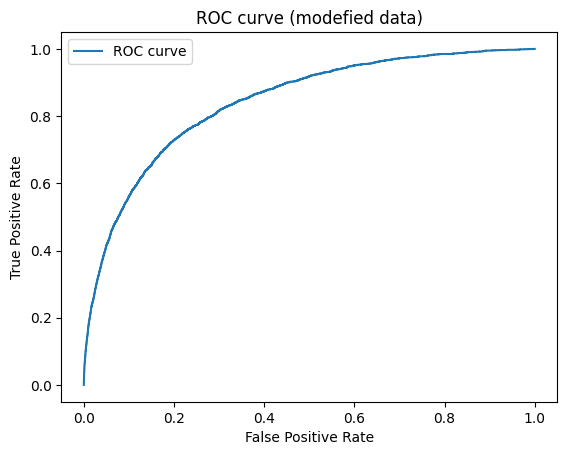

AUC: 0.8412414543902433
TPR:  41.4% 
FPR:  4.96% 
Threshold:  0.78
Predictive Equality:  59.150000000000006%


In [ ]:
variante_data_evaluation (x_train_variantIV, x_test_variantIV, y_train_variantIV, y_test_variantIV)

###Variant V

In [ ]:
# Load Base.csv
df_VariantV= pd.read_csv('/content/Variant V.csv')
# Remove "device_fraud_count", it's 0 for all entries
df_VariantV.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.1               0.054656                         -1   
1           0     0.2               0.516874                         -1   
2           0     0.1               0.870572                         -1   
3           0     0.1               0.234248                         29   
4           0     0.2               0.909504                         11   

   current_address_months_count  customer_age  days_since_request  \
0                            55            50            0.029642   
1                           178            50            0.036917   
2                            26            30           11.838249   
3                             9            20            0.030793   
4                             5            30            0.036117   

   intended_balcon_amount payment_type  zip_count_4w  ...  foreign_request  \
0               -0.779957           AB          1735  ...                0   
1               -0.471011           AB           910  ...                0   
2               51.068616           AA          1730  ...                0   
3               16.341333           AA           533  ...                0   
4               -1.151589           AB          2935  ...                0   

     source  session_length_in_minutes  device_os  keep_alive_session  \
0  INTERNET                   5.063178      linux                   0   
1  INTERNET                   5.403648      linux                   0   
2  INTERNET                   6.701977      linux                   1   
3  INTERNET                  12.787474      linux                   1   
4  INTERNET                   4.670977      linux                   0   

  device_distinct_emails_8w  device_fraud_count  month        x1        x2  
0                         1                   0      2 -0.833286 -0.239018  
1                         1                   0      3 -0.044042  1.174898  
2                         1                   0      2  2.094070  0.643121  
3                         1                   0      7 -1.060523  0.285319  
4                         1                   0      2  1.989430 -0.803668  

[5 rows x 34 columns]

In [ ]:
x_train_variantV,x_test_variantV,y_train_variantV,y_test_variantV = base_processing (df_VariantV)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
y_train_variantV.value_counts()

0    749950
1      8378
Name: fraud_bool, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randomover = RandomOverSampler(random_state= 500 )

x_train_variantV, y_train_variantV = randomover.fit_resample(x_train_variantV, y_train_variantV)

In [ ]:
y_train_variantV.value_counts()

0    749950
1    749950
Name: fraud_bool, dtype: int64


 Results for Logistic regression 



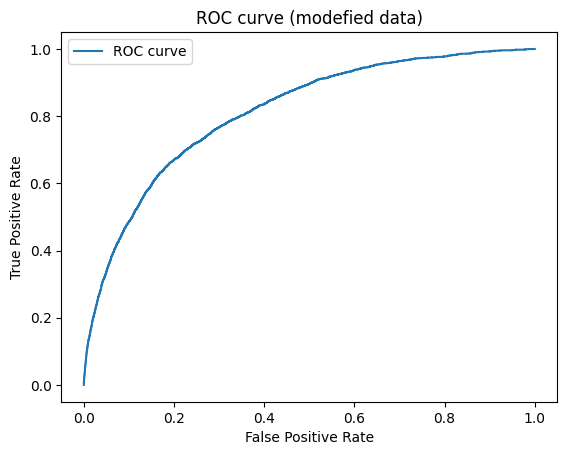

AUC: 0.8119326585316387
TPR:  33.67% 
FPR:  4.9799999999999995% 
Threshold:  0.76
Predictive Equality:  75.11%

 Results for XGBClassifier 



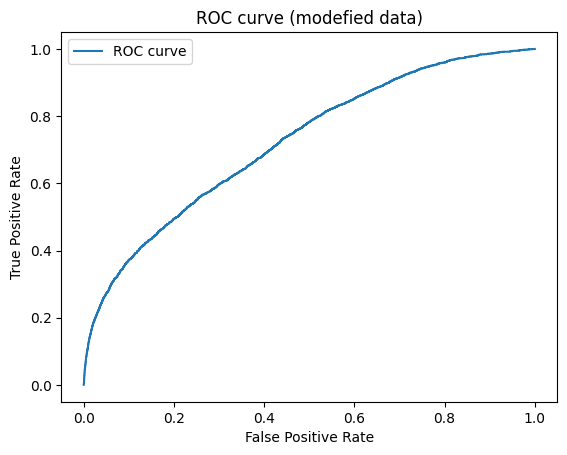

AUC: 0.7225240480453556
TPR:  27.26% 
FPR:  5.0% 
Threshold:  0.98
Predictive Equality:  53.349999999999994%

 Results for RandomForestClassifier 



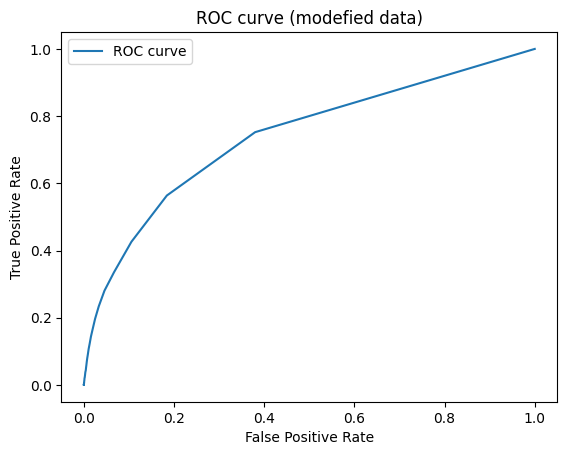

AUC: 0.7400022060921715
TPR:  28.050000000000004% 
FPR:  4.58% 
Threshold:  0.05
Predictive Equality:  53.949999999999996%

 Results for DecisionTree classifier



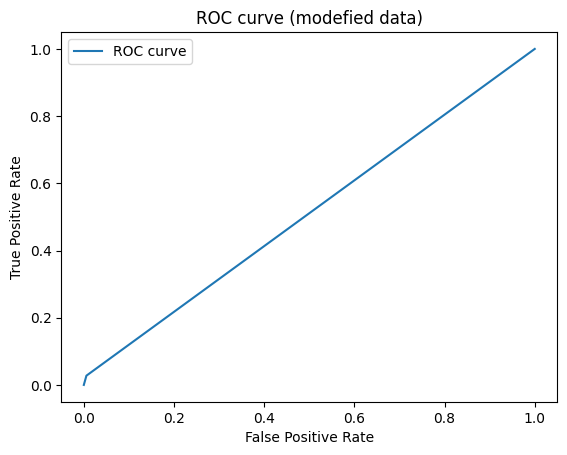

AUC: 0.5108868692460024
TPR:  2.75% 
FPR:  0.58% 
Threshold:  1.0
Predictive Equality:  58.040000000000006%

 Results for naive bayes classifier 



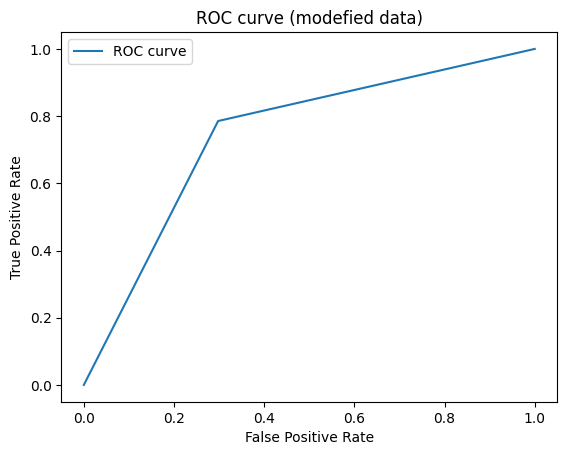

AUC: 0.7438039730609389
TPR:  0.0% 
FPR:  0.0% 
Threshold:  2
Predictive Equality:  81.44%

model  finished training 


 Results for Neural Nework model 

7553/7553 [==============================] - 15s 2ms/step


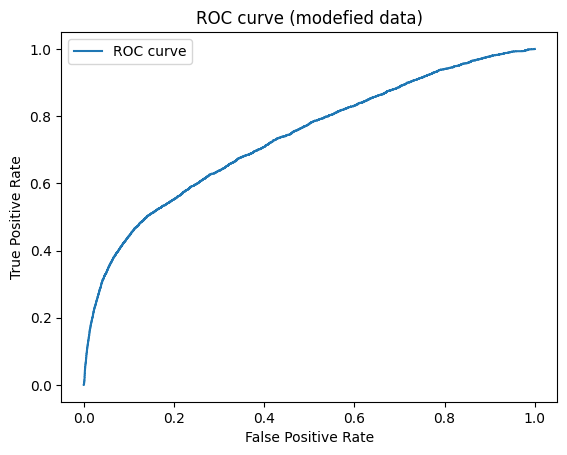

AUC: 0.7357232723035856
TPR:  33.45% 
FPR:  4.99% 
Threshold:  0.66
Predictive Equality:  39.7%


In [ ]:
variante_data_evaluation (x_train_variantV, x_test_variantV, y_train_variantV, y_test_variantV)